In [19]:
import math
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib3
from sklearn.externals import joblib
import random
import matplotlib
from sompy.sompy import SOMFactory
from sklearn.datasets import fetch_california_housing
from sompy.visualization.plot_tools import plot_hex_map
from pandas_plink import read_grm
from sklearn.preprocessing import *
from sklearn.decomposition import PCA, KernelPCA
import umap
from sklearn.manifold import *
import warnings
warnings.filterwarnings('ignore')

In [173]:
phenotypes = pd.read_csv('/mnt/d/Project_PhD/Sepsis/spss_gwas2/grm/phenotypes/sepsis_gwas_v2.csv')

In [174]:
columns = ['gender', 'age.days','ethnicity','hosp.dur','picu.dur','comorbidity','outcome.death','pathogen.grp','clin.focus',
           'psofa.score', 'psofa.cvs','psofa.resp','psofa.cns','psofa.ren', 'psofa.hep','psofa.hem',
           'cons05.score','cons05.mods','cons05.cvs','cons05.resp','cons05.cns','cons05.ren', 'cons05.hep','cons05.hem',
           'pelod.score','pelod.cvs','pelod.resp','pelod.cns', 'pelod.ren', 'pelod.hem']


In [175]:
phenotypes = phenotypes[columns]


def get_key(val, dict): 
    for key, value in dict.items(): 
         if val == value: 
            return key 
k = 0
mapping_pathogen = {}       
for pathogen in set(phenotypes['pathogen.grp']):
    mapping_pathogen[pathogen] = k
    k += 1

    
k = 0
mapping_ethnicity = {}
for ethnicity in set(phenotypes['ethnicity']):
    mapping_ethnicity[ethnicity] = k
    k += 1
    
k = 0
mapping_focus = {}
for focus in set(phenotypes['clin.focus']):
    mapping_focus[focus] = k
    k += 1
    
mapping_binary = {'no':0, 'yes':1}
mapping_gender = {'female':0, 'male':1}
mapping_comorbidity = {'comorbid':1,'healthy':0}


In [176]:
phenotypes = phenotypes.replace(mapping_binary)

In [177]:
phenotypes = phenotypes.replace({'gender':mapping_gender,'comorbidity':mapping_comorbidity, 'ethnicity':mapping_ethnicity,'clin.focus':mapping_focus, 'pathogen.grp':mapping_pathogen})

In [178]:
phenotypes['picu.dur'] = phenotypes['picu.dur'].fillna(0)
phenotypes = phenotypes.dropna()
phenotypes.shape

(646, 30)

In [157]:
columns_cluster = ['psofa.score', 'psofa.cvs','psofa.resp','psofa.cns','psofa.ren', 'psofa.hep','psofa.hem',
           'cons05.score','cons05.mods','cons05.cvs','cons05.resp','cons05.cns','cons05.ren', 'cons05.hep','cons05.hem',
           'pelod.score','pelod.cvs','pelod.resp','pelod.cns', 'pelod.ren', 'pelod.hem']
data = phenotypes[columns_cluster]

In [179]:
data = np.array(phenotypes)

In [180]:
data.shape

(646, 30)

In [181]:
len(columns)

30

# SOM

In [182]:
names = columns
# Train the model with different parameters. The more, the better. Each iteration is stored in disk for further study
for i in range(200):
    sm = SOMFactory().build(data, mapsize=[random.choice(list(range(5, 15))), 
                                           random.choice(list(range(5, 15)))],
                            normalization = 'var', initialization='random', component_names=names, lattice="hexa")
    sm.train(n_job=4, verbose=False, train_rough_len=30, train_finetune_len=100)
    joblib.dump(sm, "./SOMmodels/model_{}.joblib".format(i))

In [ ]:
e_q

In [183]:
models_pool = glob.glob("./SOMmodels/model*")
errors=[]
for model_filepath in models_pool:
    sm = joblib.load(model_filepath)
    topographic_error = sm.calculate_topographic_error()
    quantization_error = sm.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top, e_q = zip(*errors)


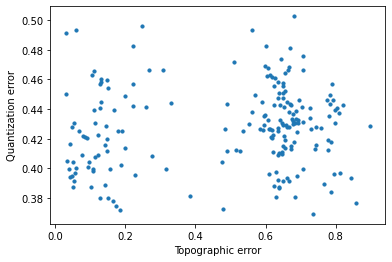

In [184]:
plt.scatter(np.array(e_top), np.array(e_q), s=10)
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()

In [185]:
np.where(e_top==np.min(e_top))

(array([80]),)

In [186]:
selected_model = 80
sm = joblib.load(models_pool[selected_model])

topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ("Topographic error = %s\n Quantization error = %s" % (topographic_error, quantization_error))

Topographic error = 0.029411764705882353
 Quantization error = 0.49100493573261544


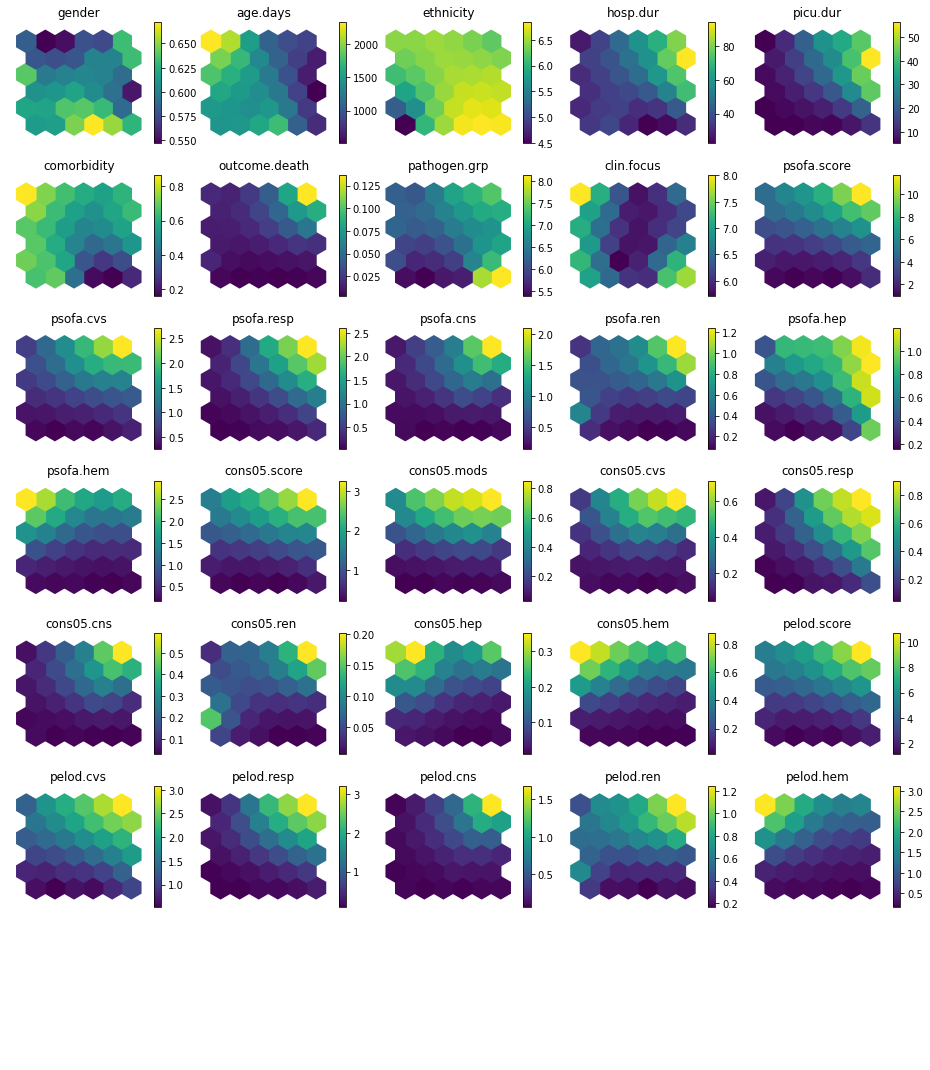

In [187]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"", text_size=10)
view2D.show(sm, col_sz=5, which_dim="all", denormalize=True)
plt.show()

In [133]:
exogeneous_vars = [c for c in phenotypes.columns if not c in columns_cluster] 
phenotypes["bmus"] = sm.project_data(data)
empirical_codebook = phenotypes.groupby("bmus").mean().values
matplotlib.rcParams.update({'font.size': 10})
plot_hex_map(empirical_codebook.reshape(sm.codebook.mapsize + [empirical_codebook.shape[-1]]), 
             titles=phenotypes.columns[:-1], shape=[4, 5], colormap=None)

(29, 29)


ValueError: cannot reshape array of size 841 into shape (5,6,29)

In [188]:
phenotypes.columns[:-1]

Index(['gender', 'age.days', 'ethnicity', 'hosp.dur', 'picu.dur',
       'comorbidity', 'outcome.death', 'pathogen.grp', 'clin.focus',
       'psofa.score', 'psofa.cvs', 'psofa.resp', 'psofa.cns', 'psofa.ren',
       'psofa.hep', 'psofa.hem', 'cons05.score', 'cons05.mods', 'cons05.cvs',
       'cons05.resp', 'cons05.cns', 'cons05.ren', 'cons05.hep', 'cons05.hem',
       'pelod.score', 'pelod.cvs', 'pelod.resp', 'pelod.cns', 'pelod.ren'],
      dtype='object')

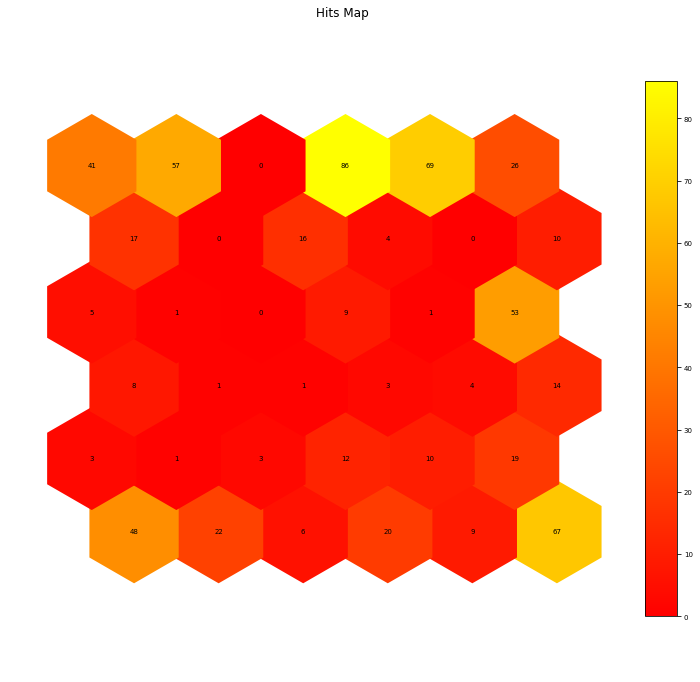

In [189]:
from sompy.visualization.bmuhits import BmuHitsView
#sm.codebook.lattice="rect"
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="autumn", logaritmic=False)
plt.show()

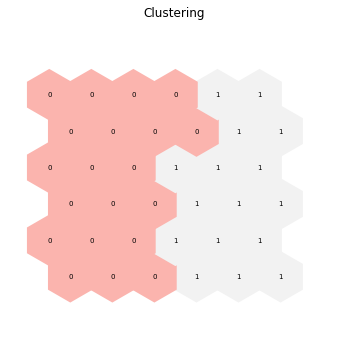

In [193]:
from sompy.visualization.hitmap import HitMapView
sm.cluster(2)

hits  = HitMapView(6, 6,"Clustering",text_size=10, cmap=plt.cm.jet)
a=hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")
plt.show()


# PCA

Text(0, 0.5, 'Y')

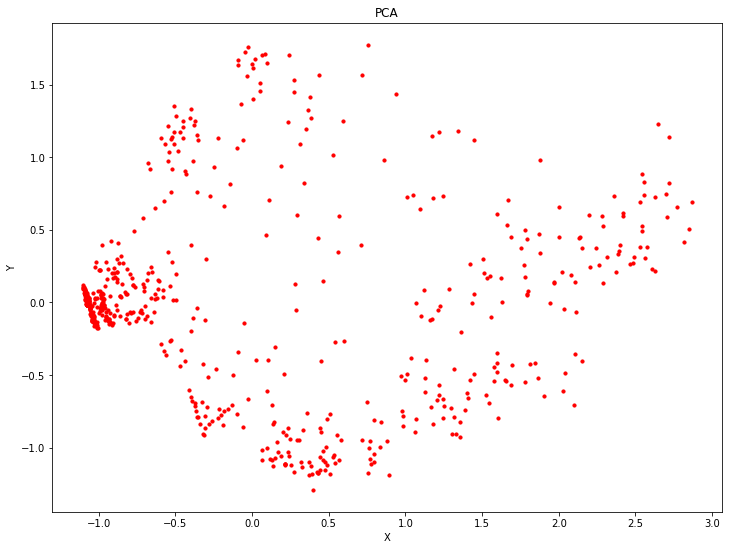

In [66]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
fig = plt.figure(figsize=(12,9))
plt.scatter(data_pca[:, 0], data_pca[:, 1], s=10, c='r')
plt.title('PCA')
plt.xlabel('X')
plt.ylabel('Y')


/home/bowfan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/home/bowfan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/home/bowfan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too

/home/bowfan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/home/bowfan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/home/bowfan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too

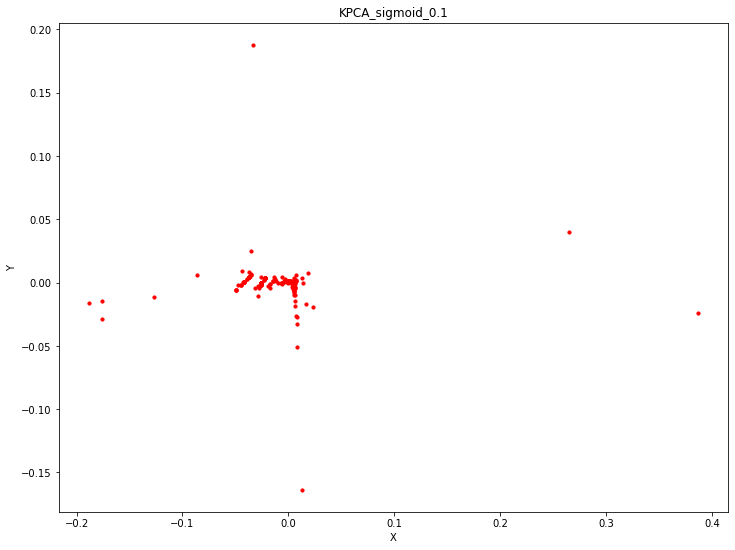

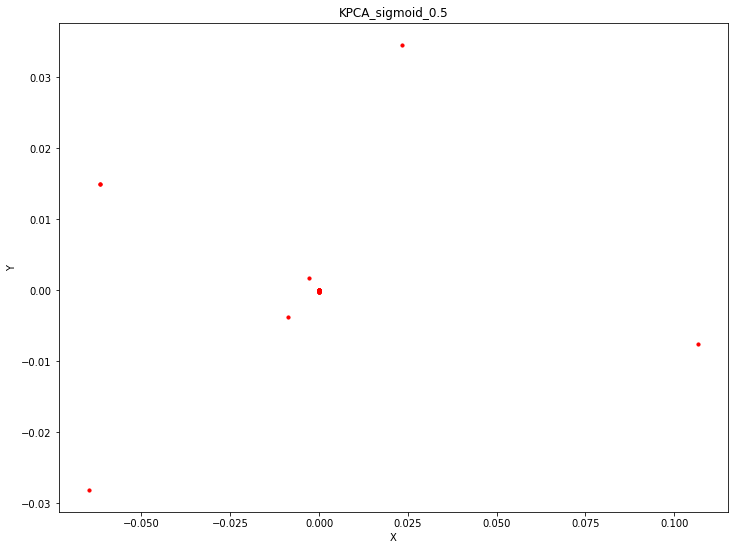

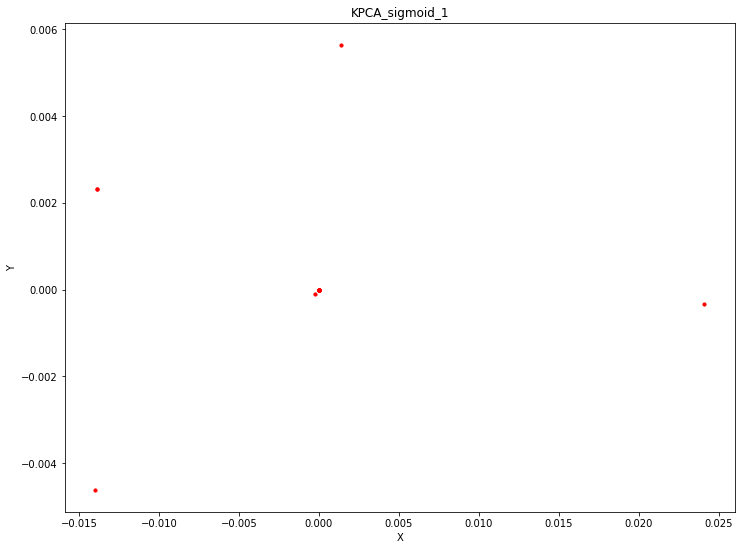

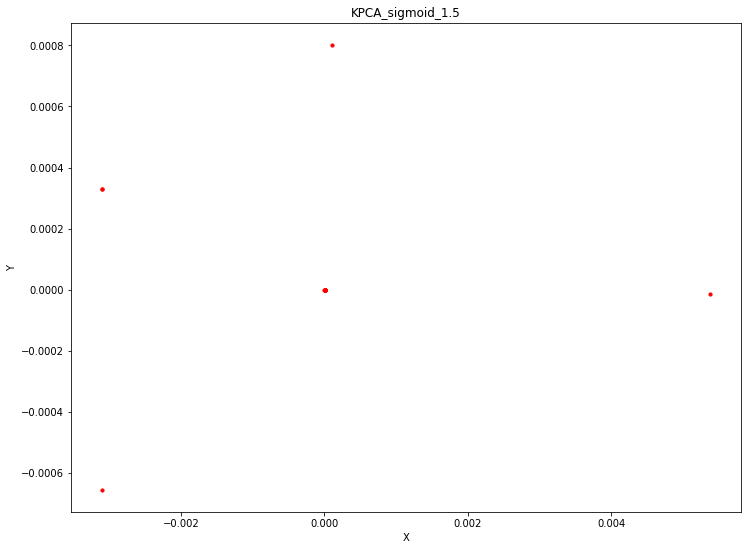

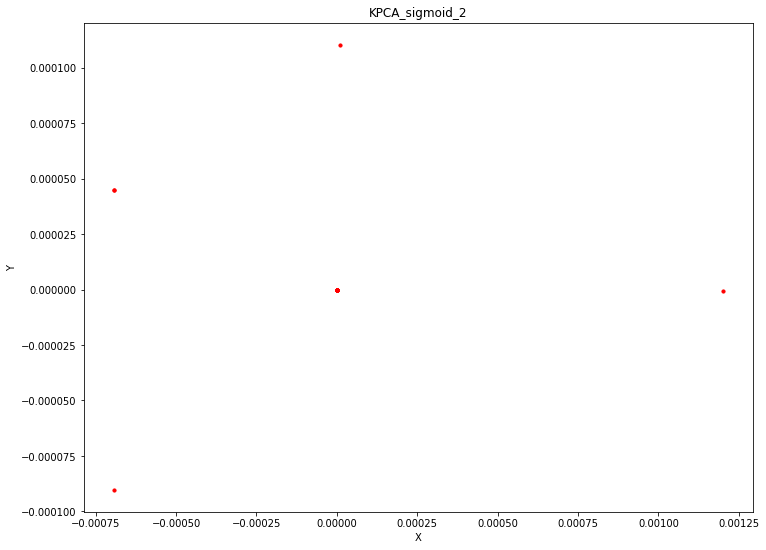

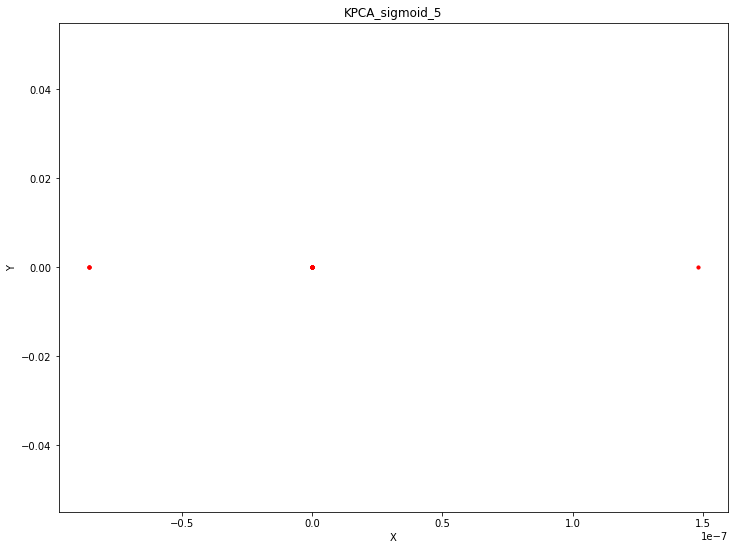

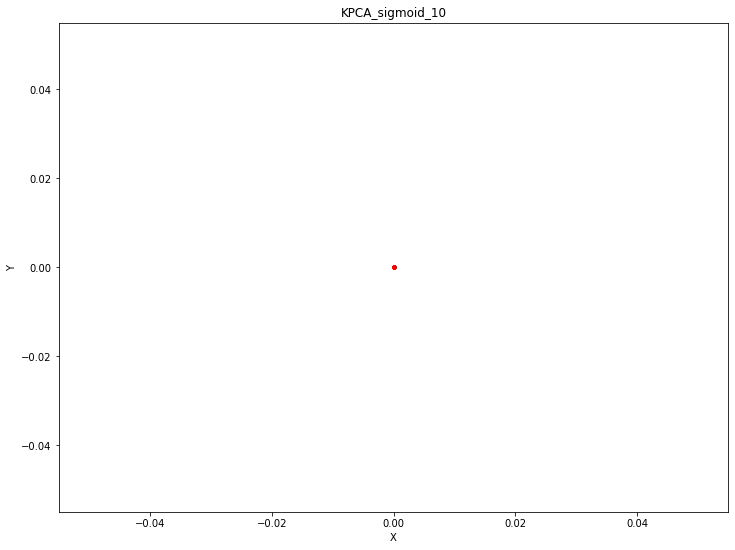

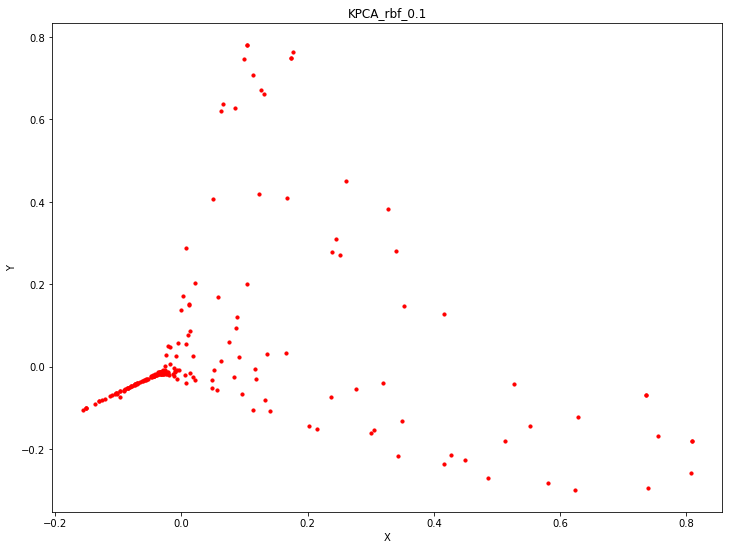

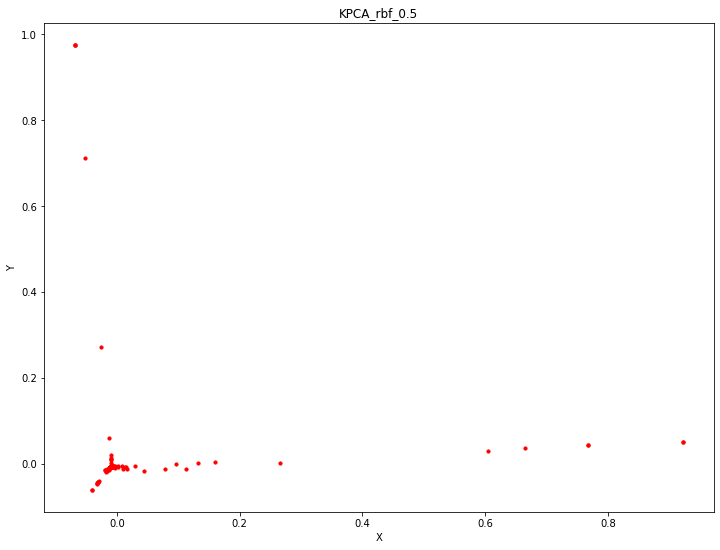

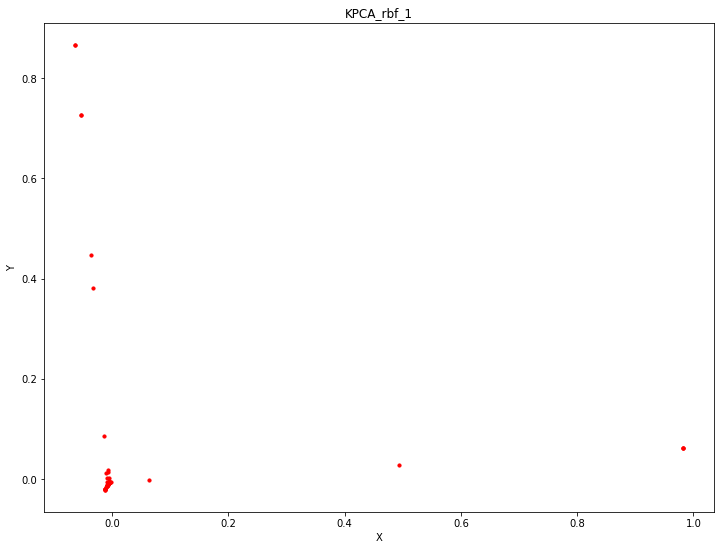

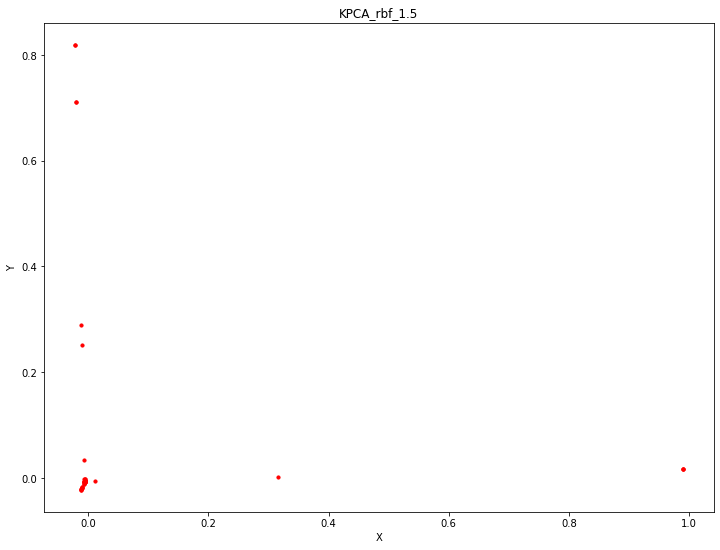

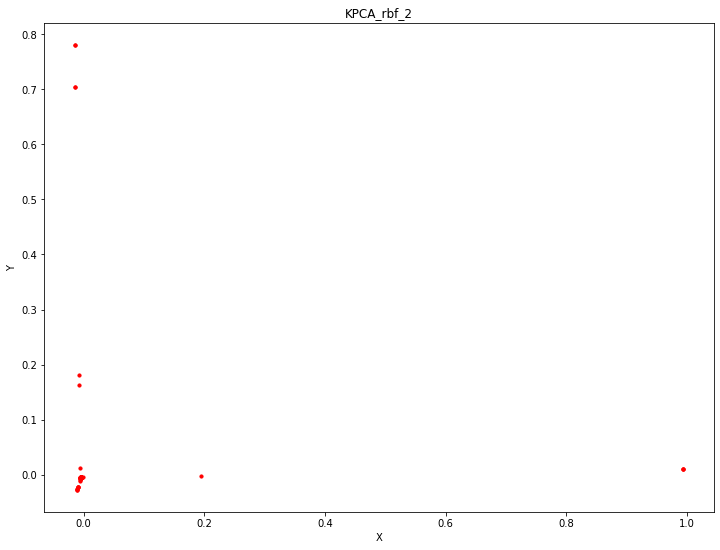

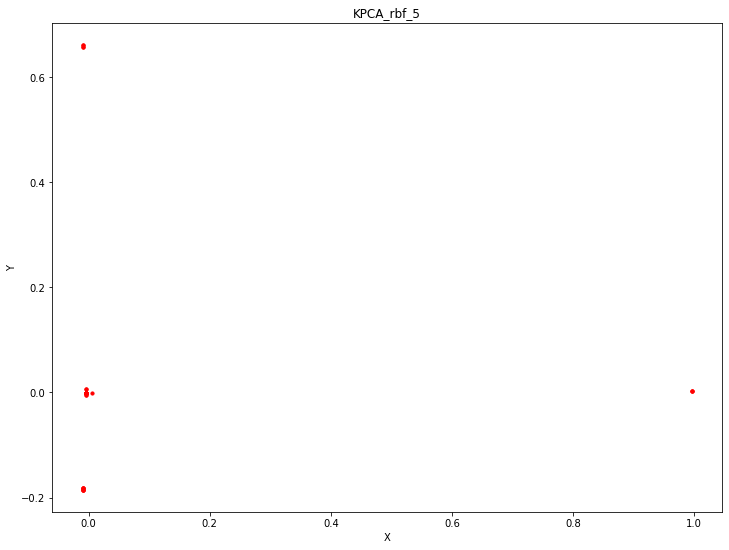

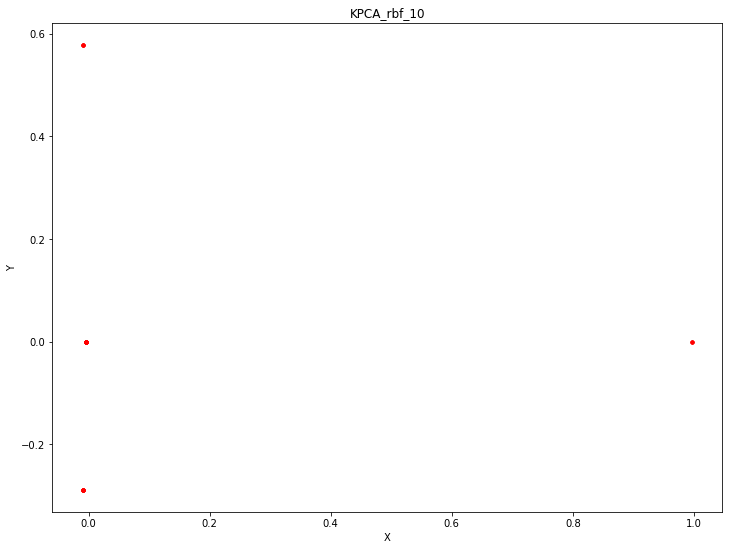

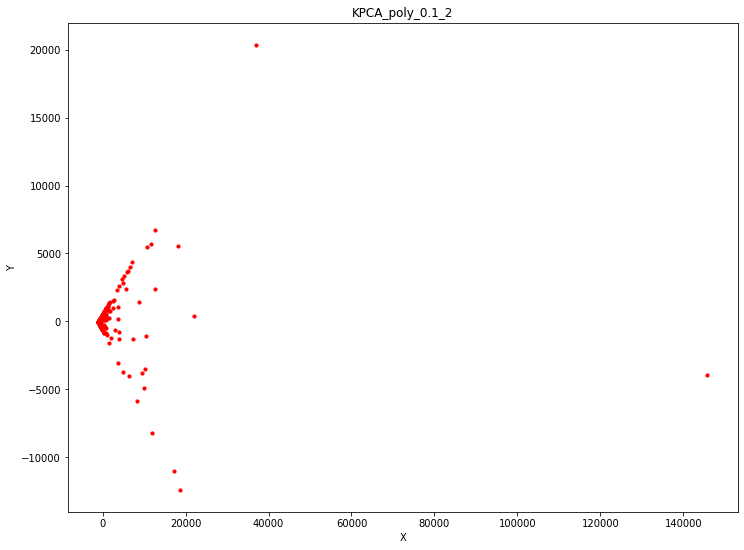

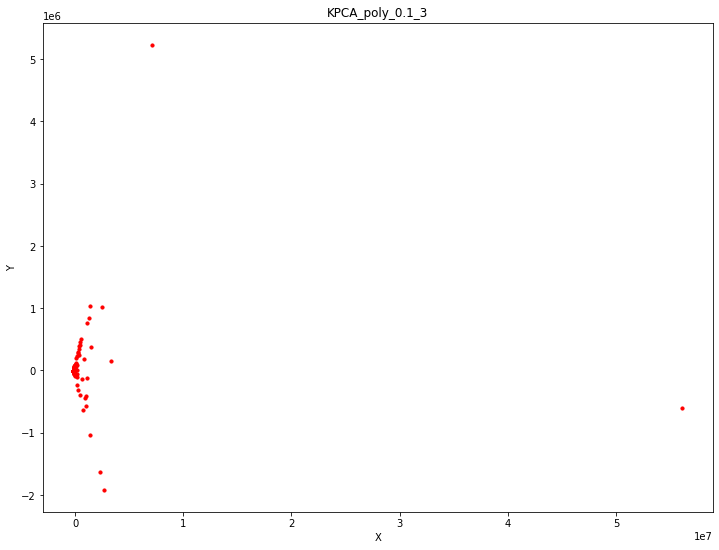

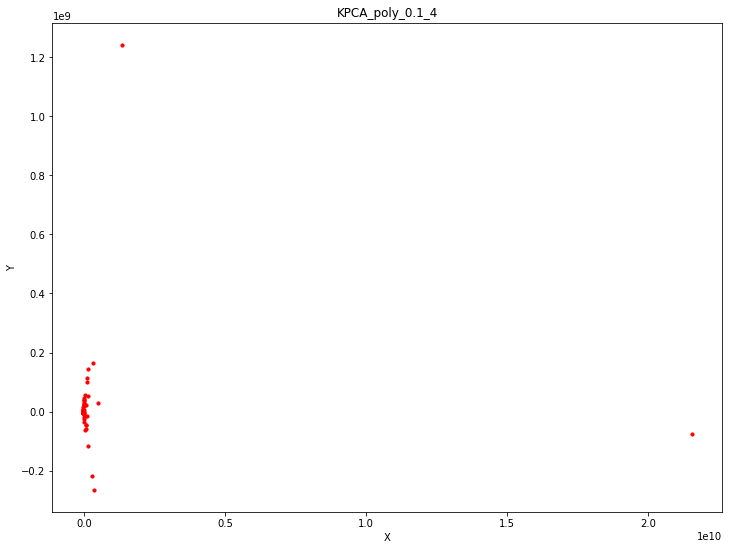

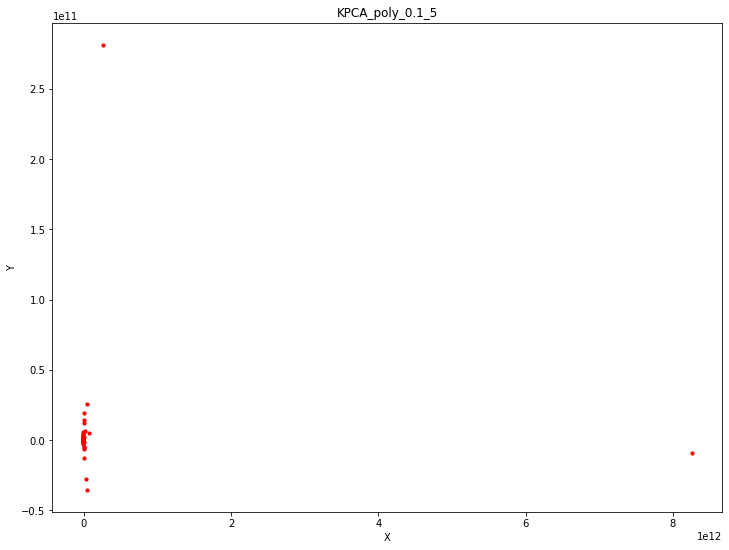

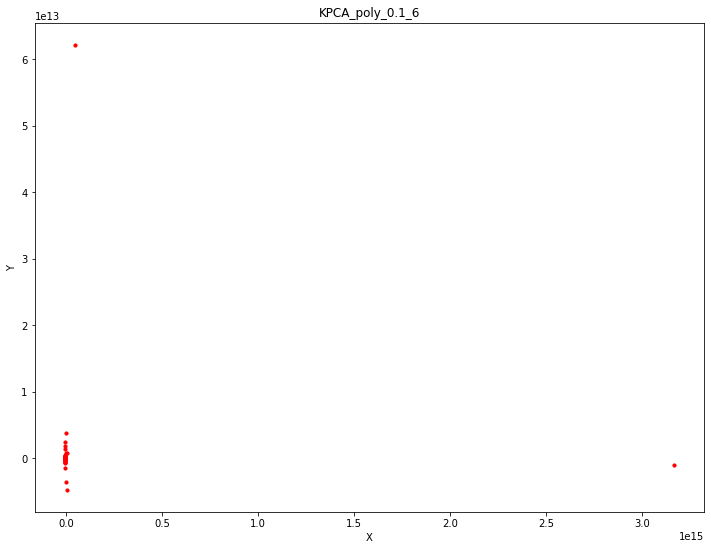

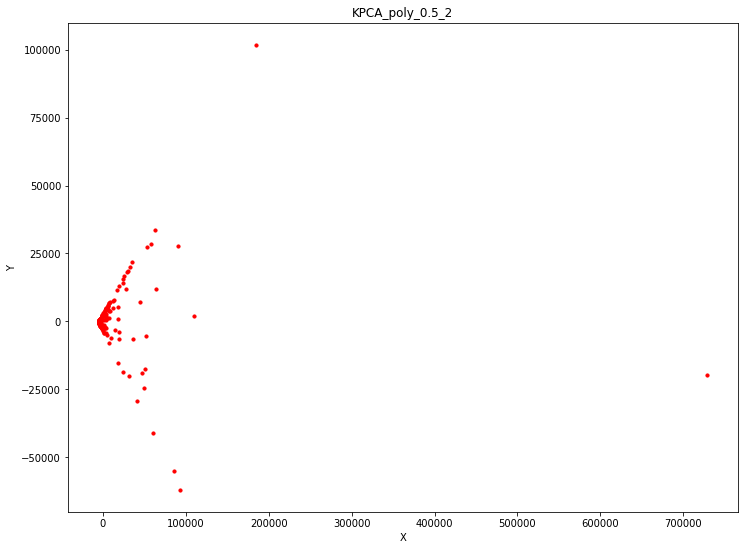

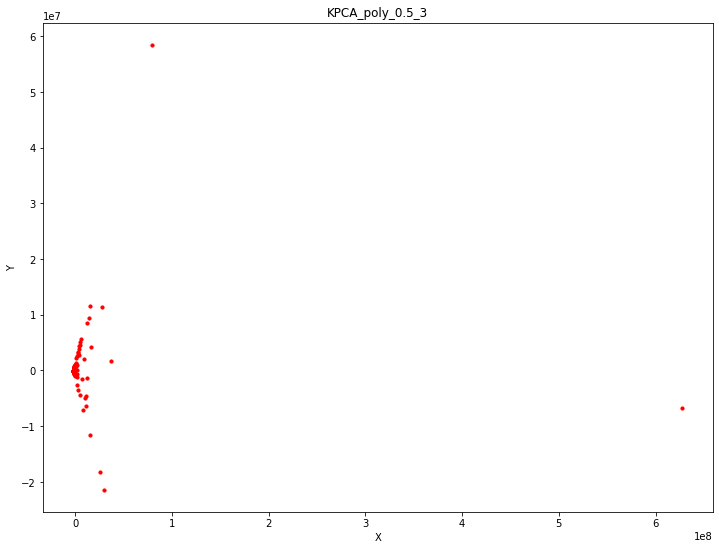

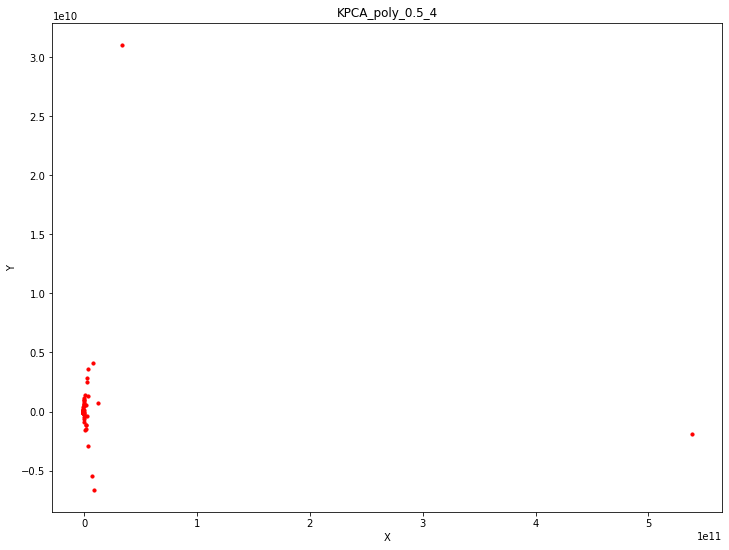

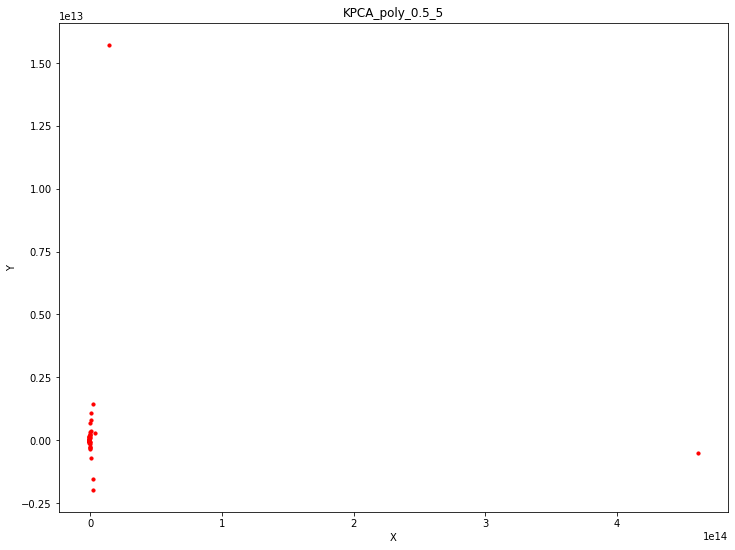

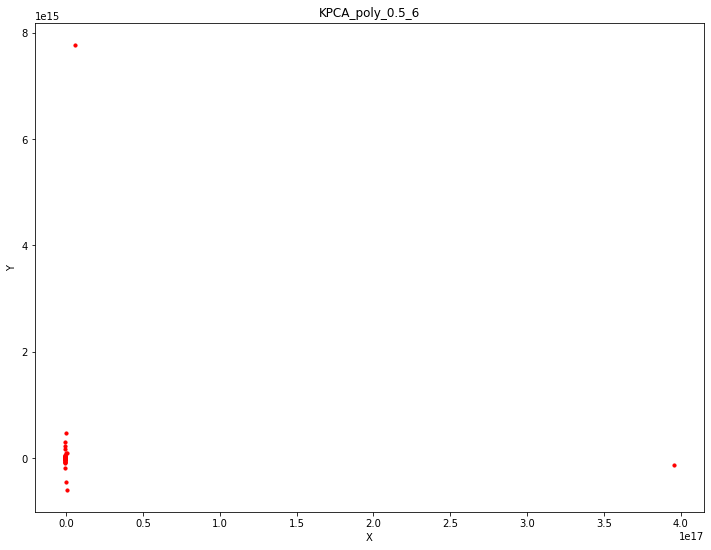

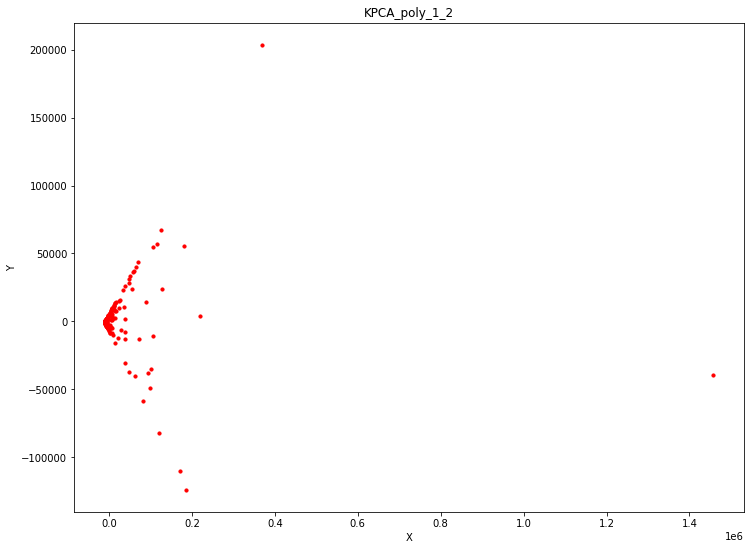

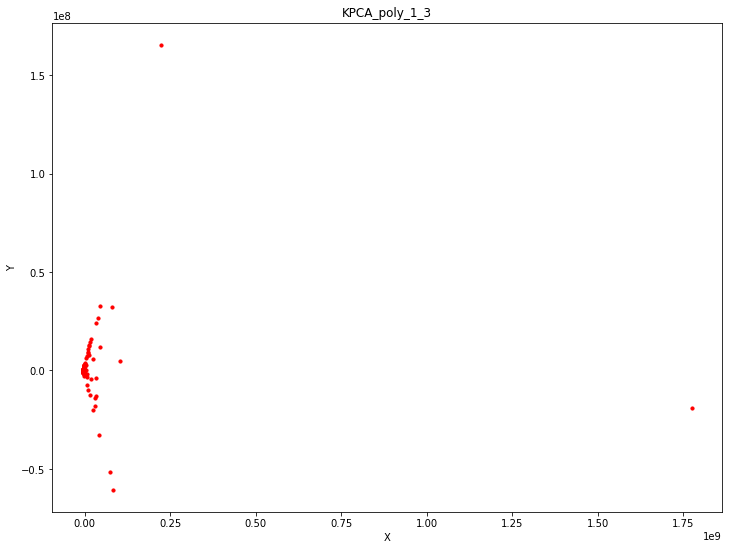

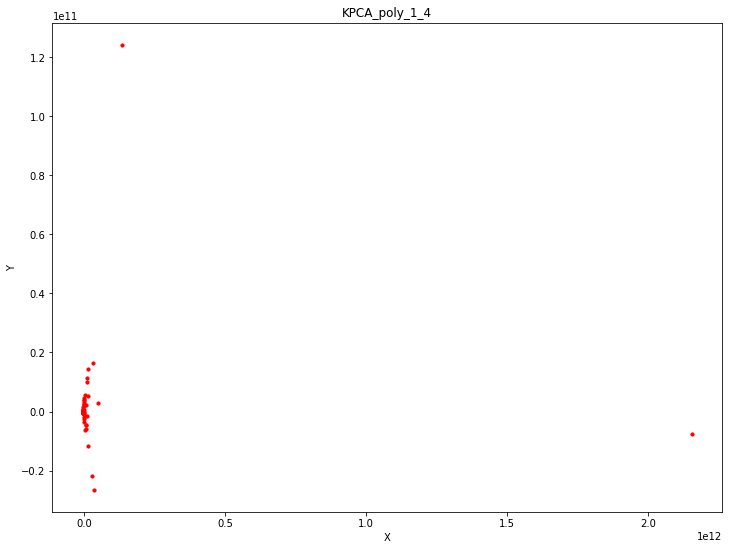

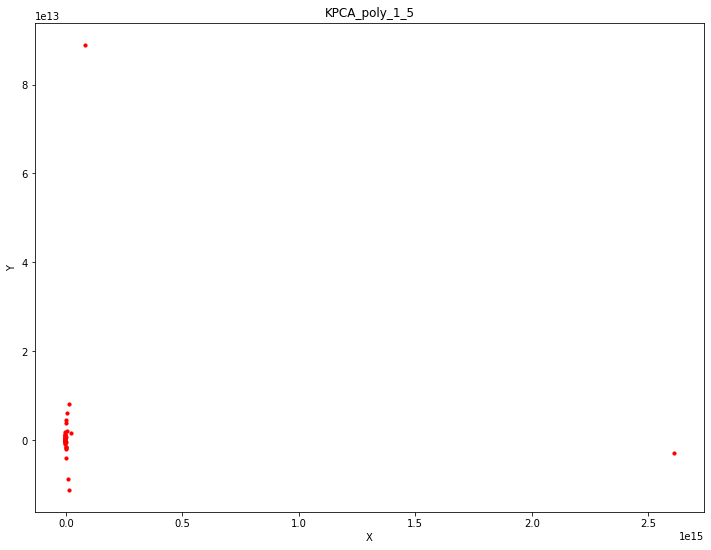

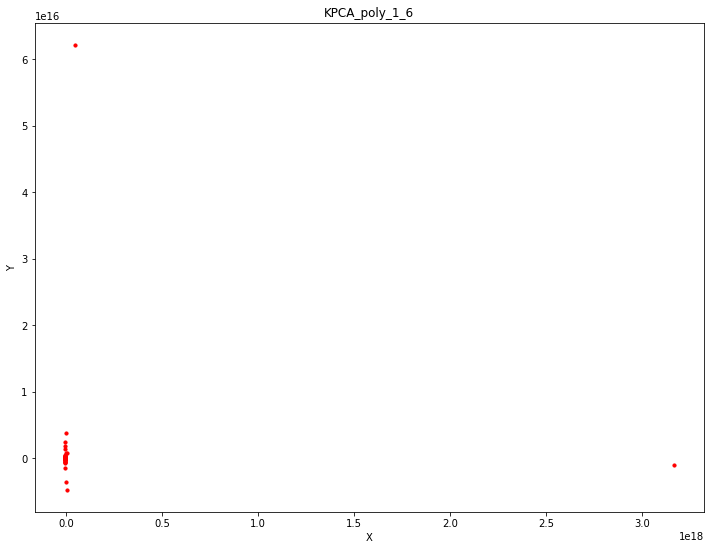

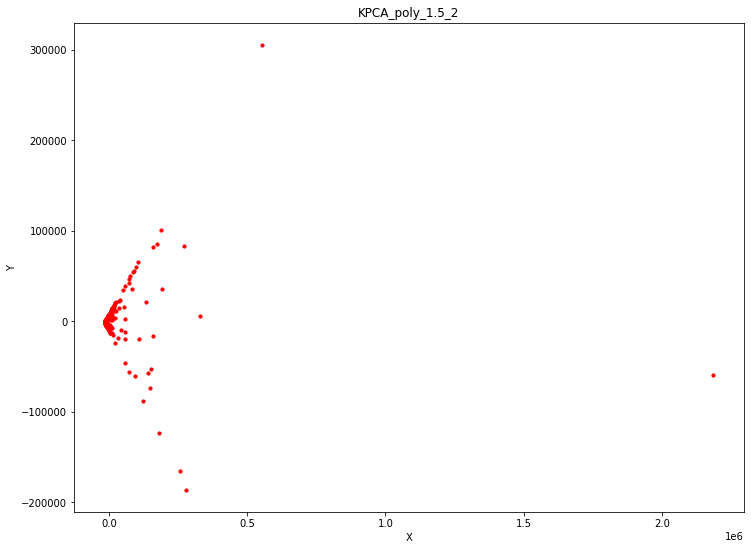

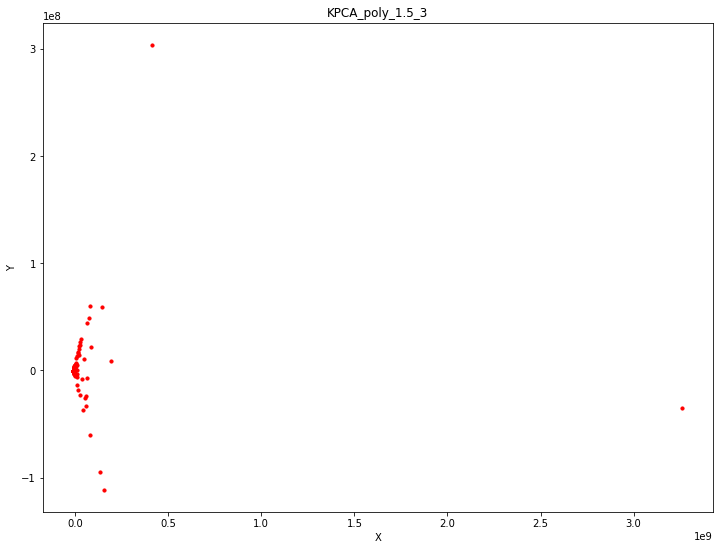

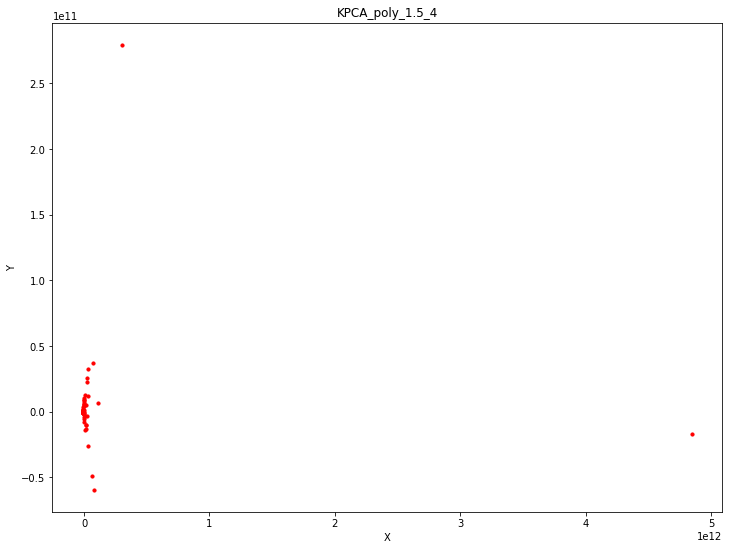

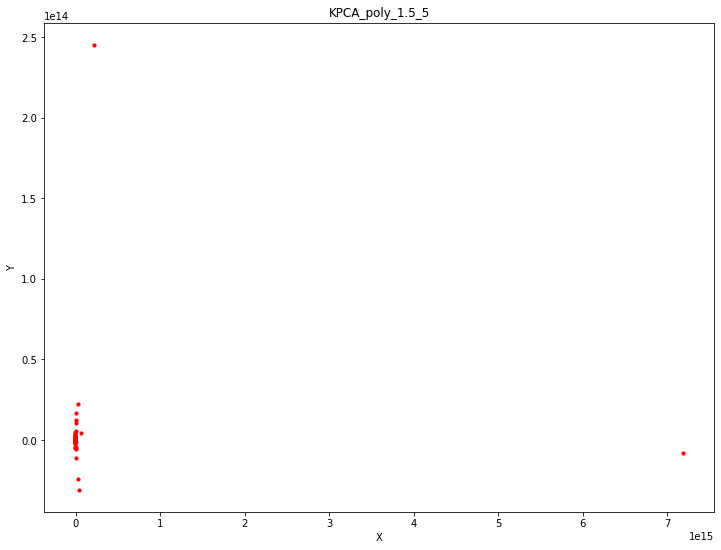

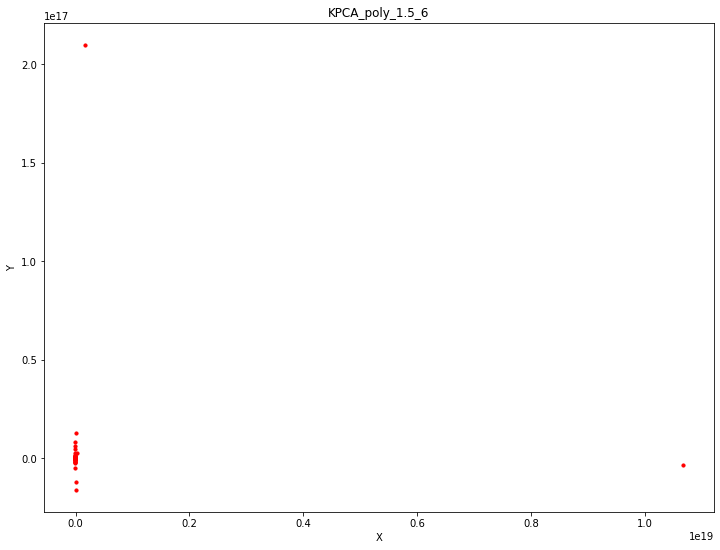

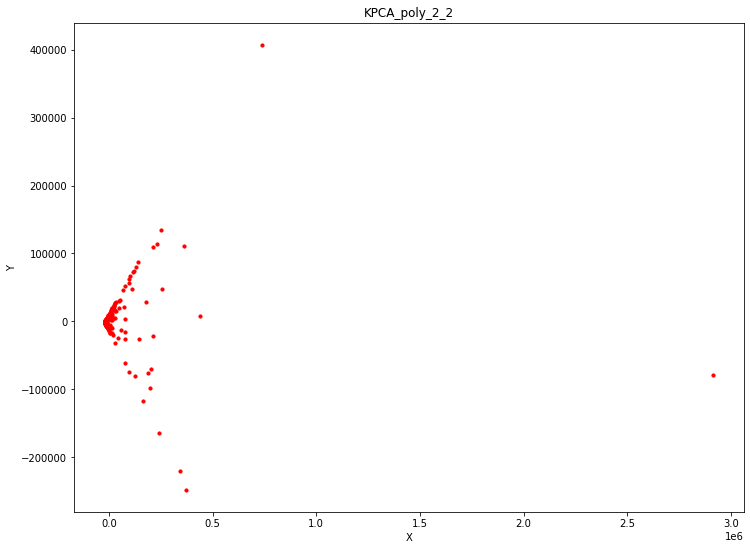

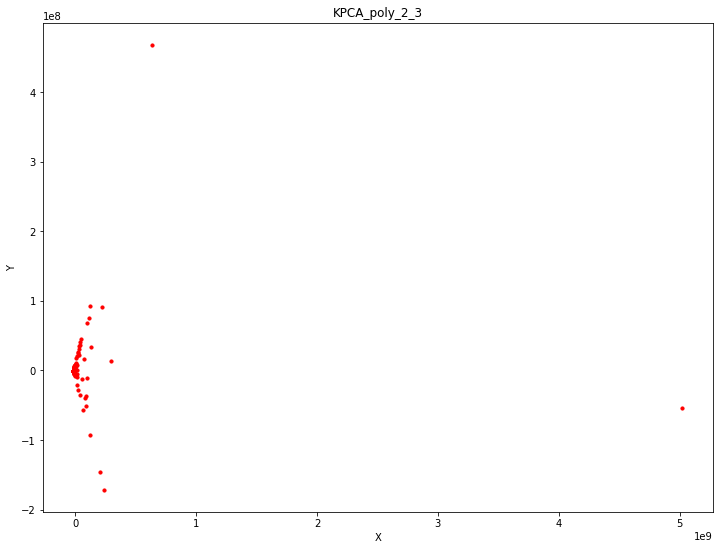

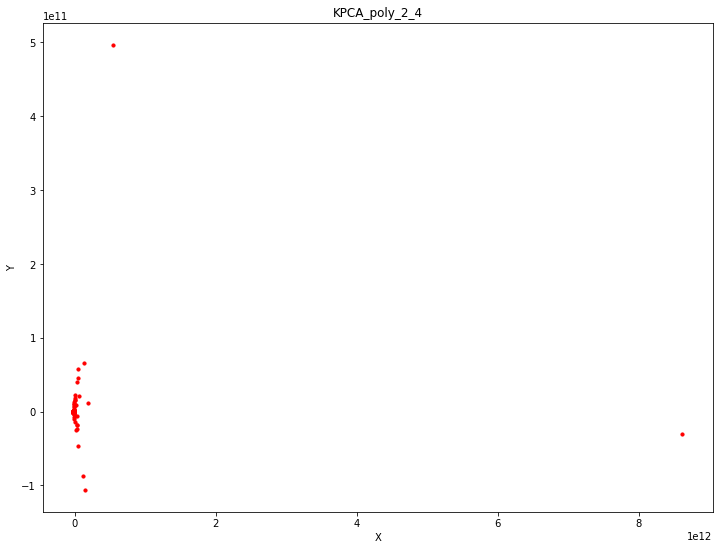

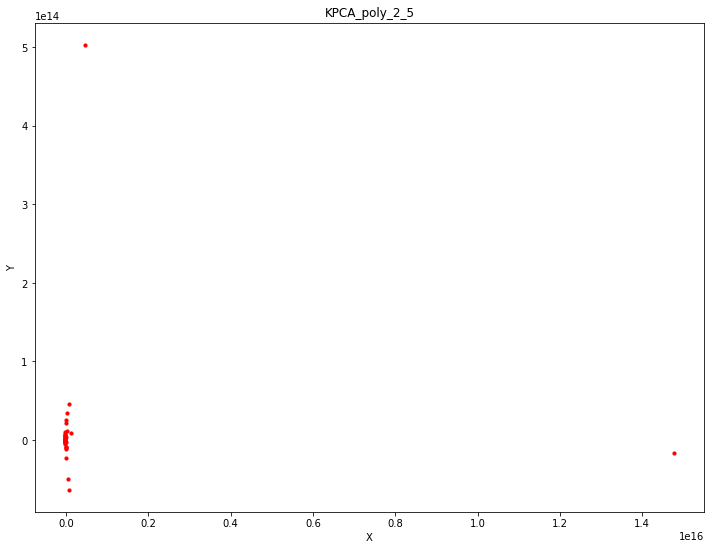

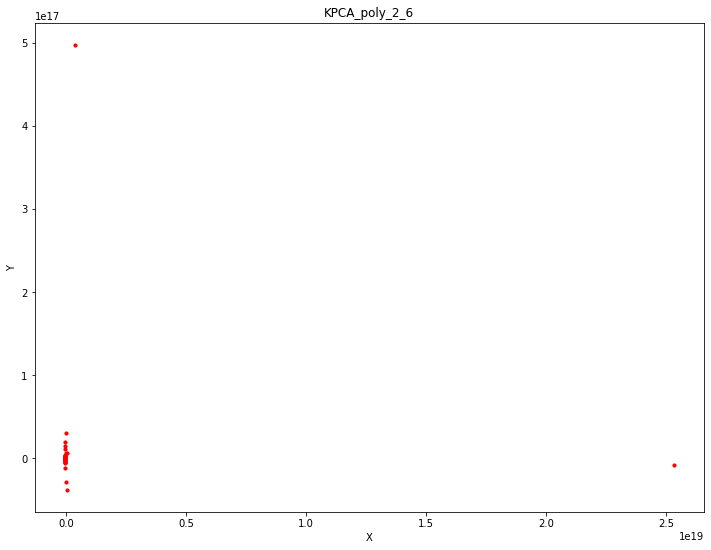

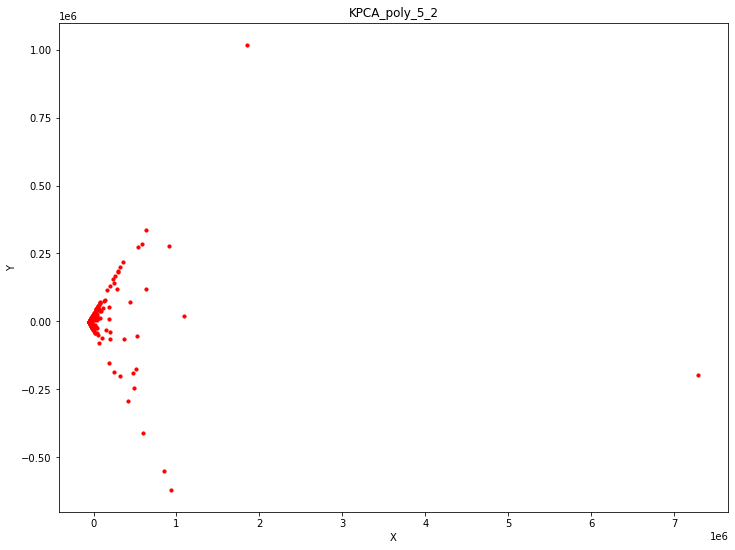

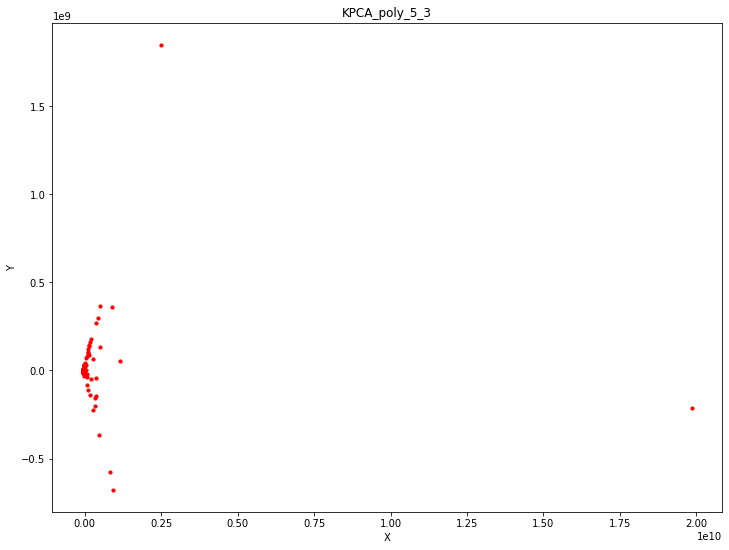

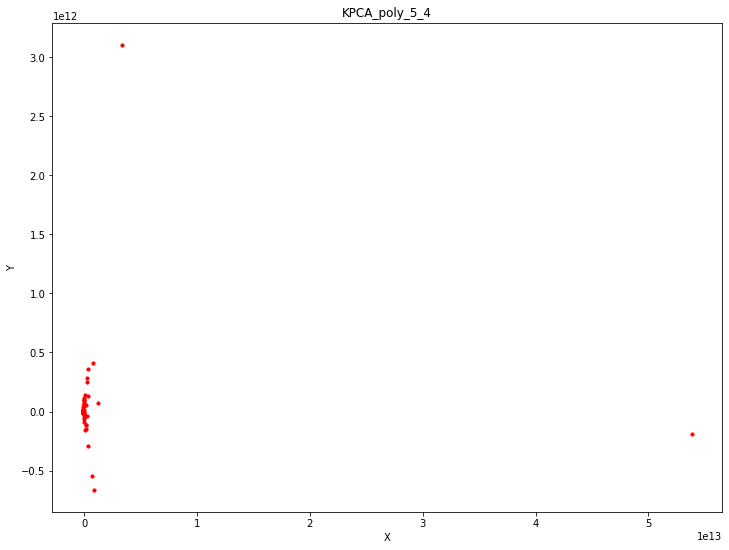

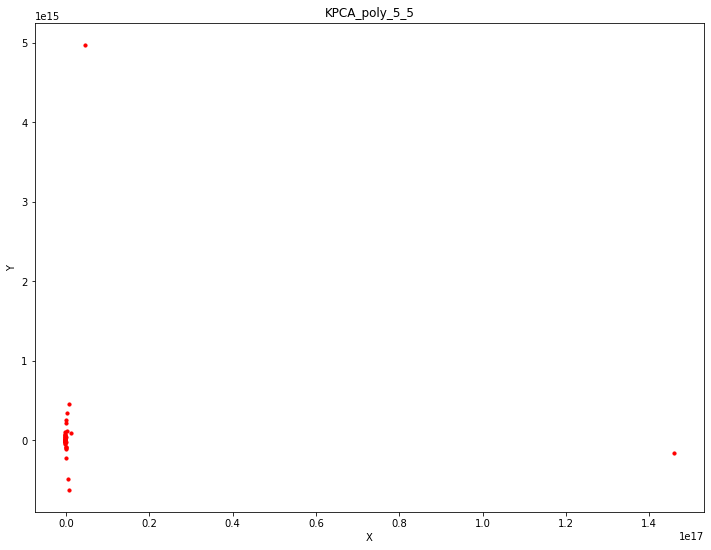

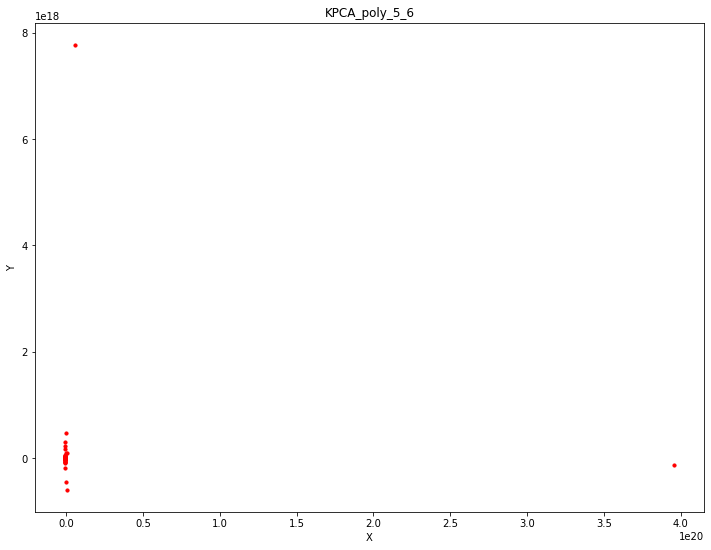

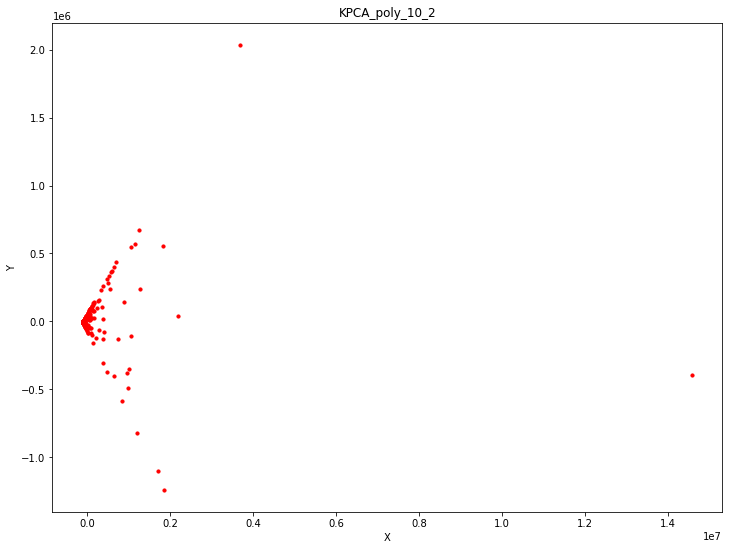

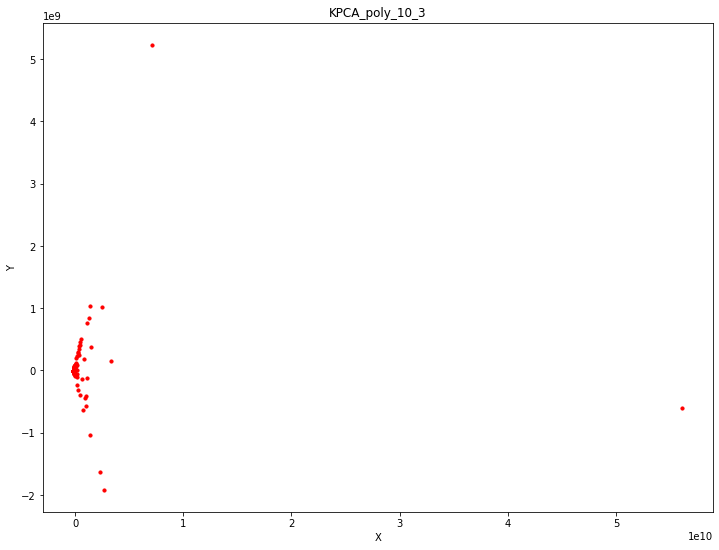

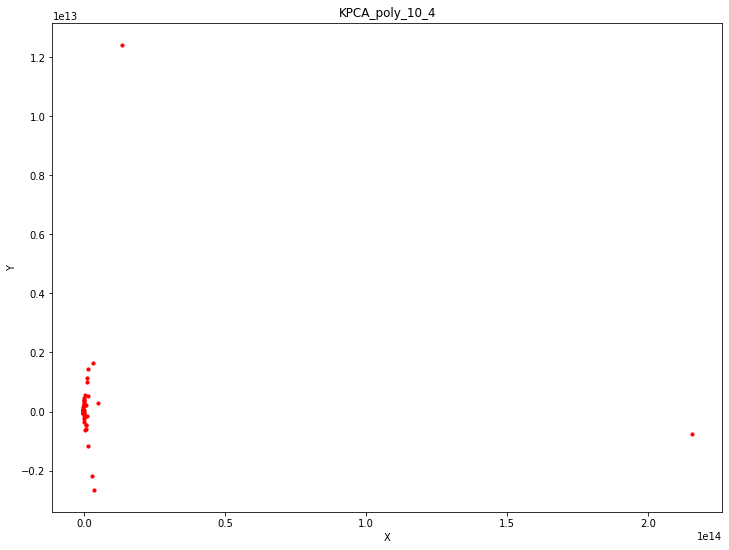

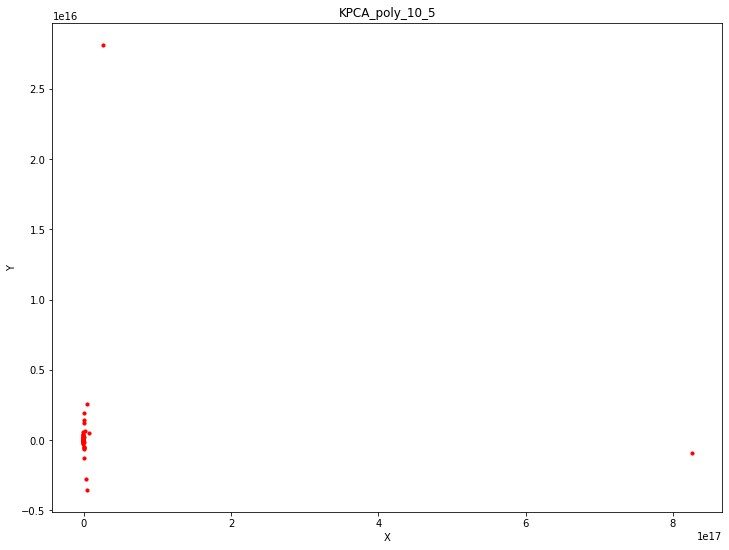

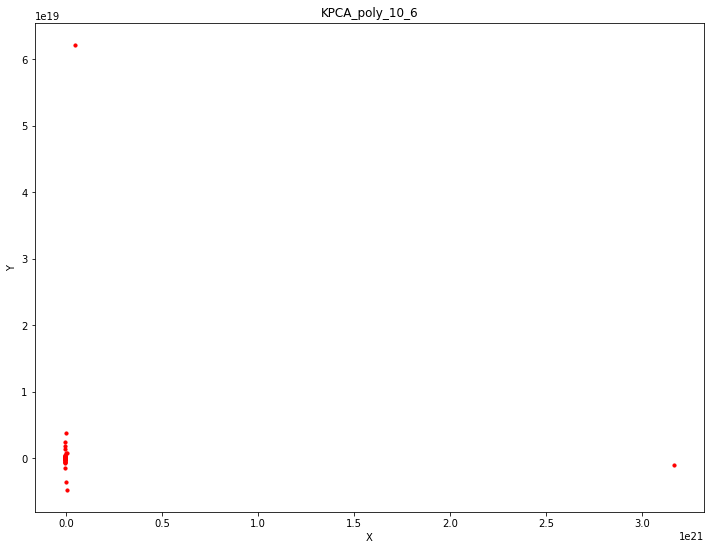

In [67]:
kpca = KernelPCA(kernel='sigmoid', degree=1, gamma=5, n_components=2)
data_kpca = kpca.fit_transform(data)
for kernel in ['sigmoid', 'rbf','poly']:
    for gamma in [0.1, 0.5, 1, 1.5, 2, 5, 10]:
        if kernel == 'poly':
            for degree in range(2,7):
                kpca = KernelPCA(kernel=kernel, degree=degree, gamma=gamma, n_components=2)
                data_kpca = kpca.fit_transform(data_raw)
                fig = plt.figure(figsize=(12,9))
                plt.scatter(data_kpca[:, 0], data_kpca[:, 1], s=10, c='r')
                plt.title('KPCA_{}_{}_{}'.format(kernel, str(gamma), str(degree)))
                plt.xlabel('X')
                plt.ylabel('Y')
        else:
            kpca = KernelPCA(kernel=kernel,gamma=gamma, n_components=2)
            data_kpca = kpca.fit_transform(data_raw)
            fig = plt.figure(figsize=(12,9))
            plt.scatter(data_kpca[:, 0], data_kpca[:, 1], s=10, c='r')
            plt.title('KPCA_{}_{}'.format(kernel, str(gamma)))
            plt.xlabel('X')
            plt.ylabel('Y')

# t-SNE

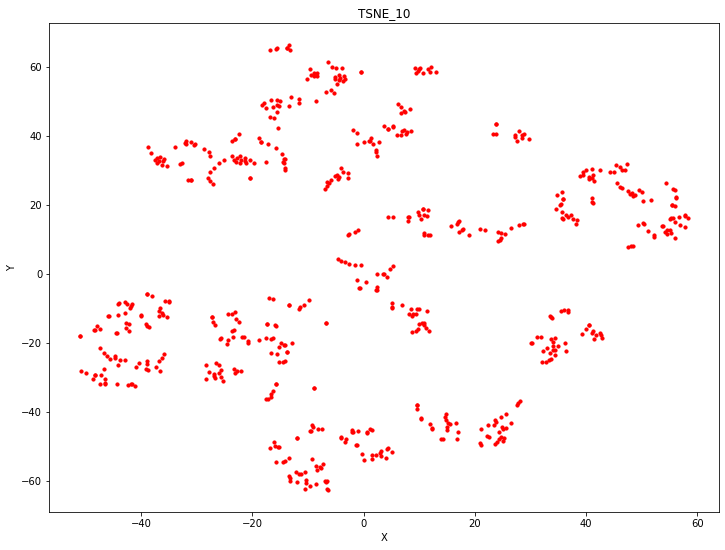

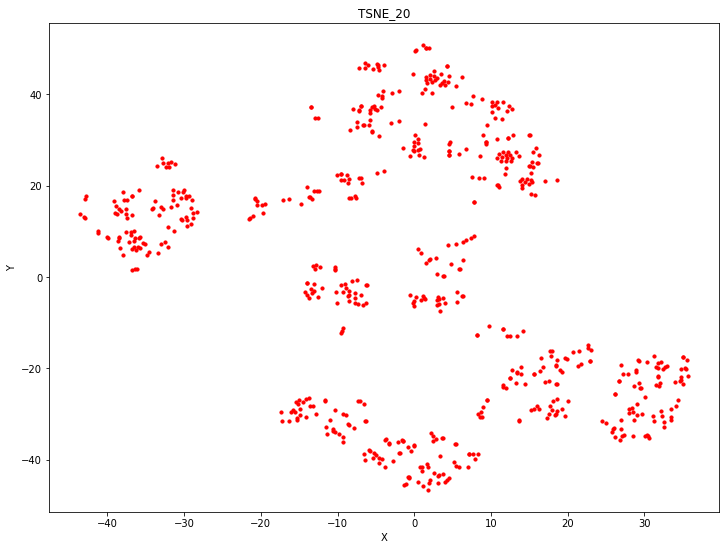

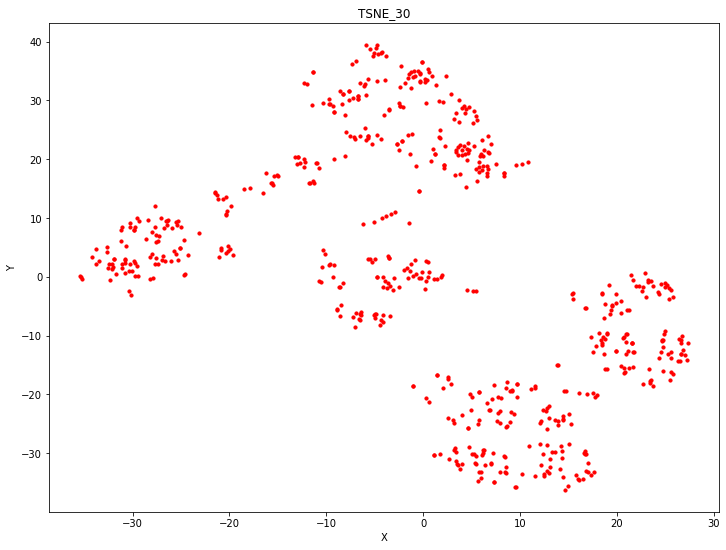

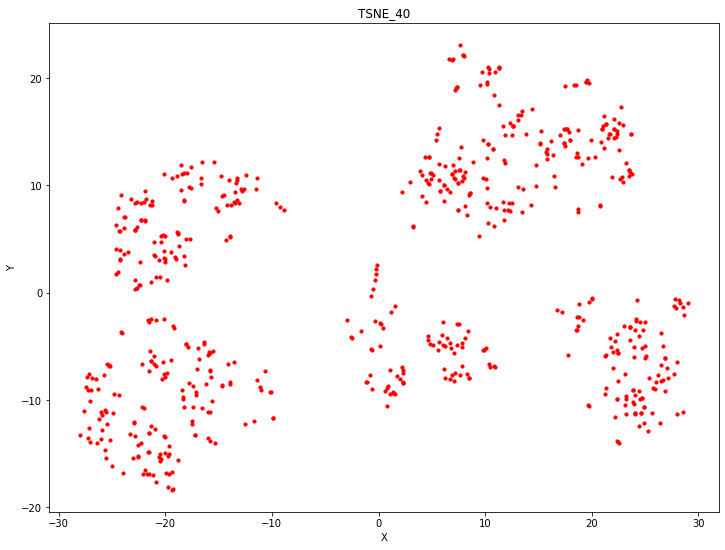

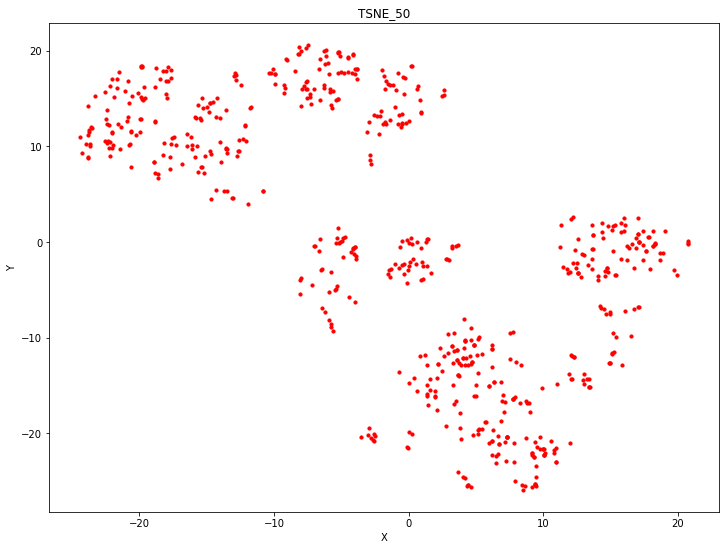

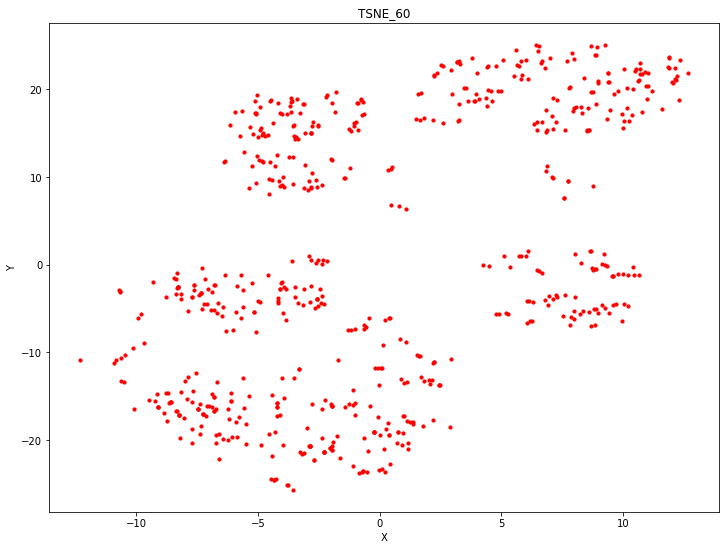

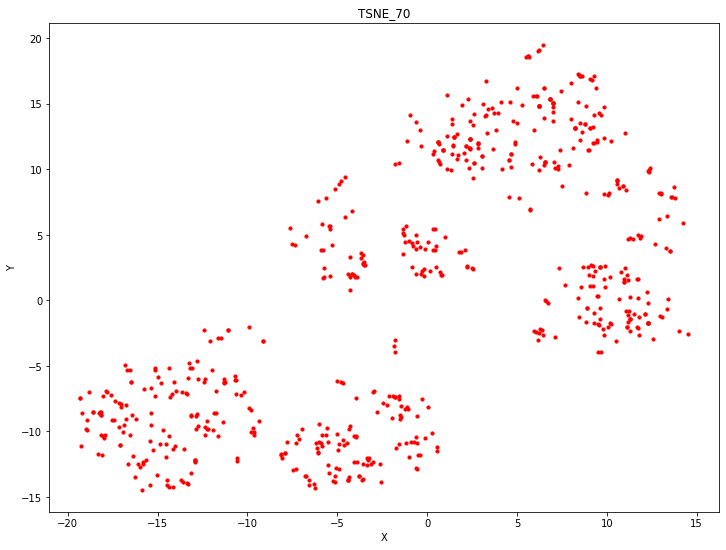

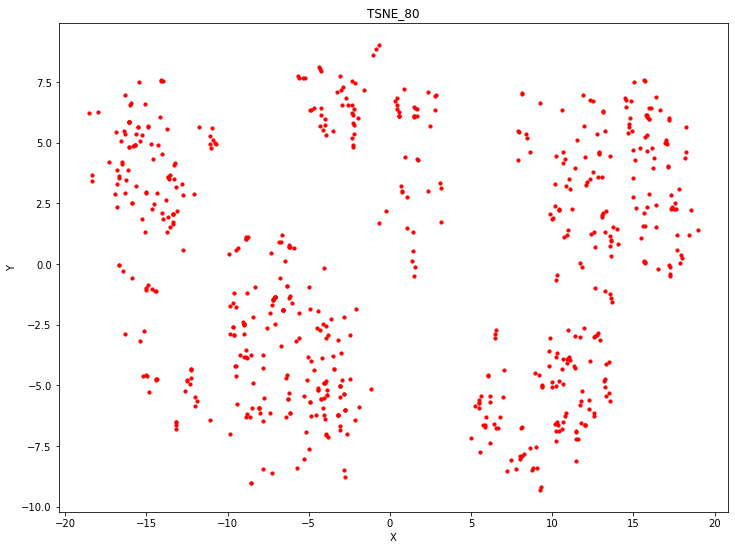

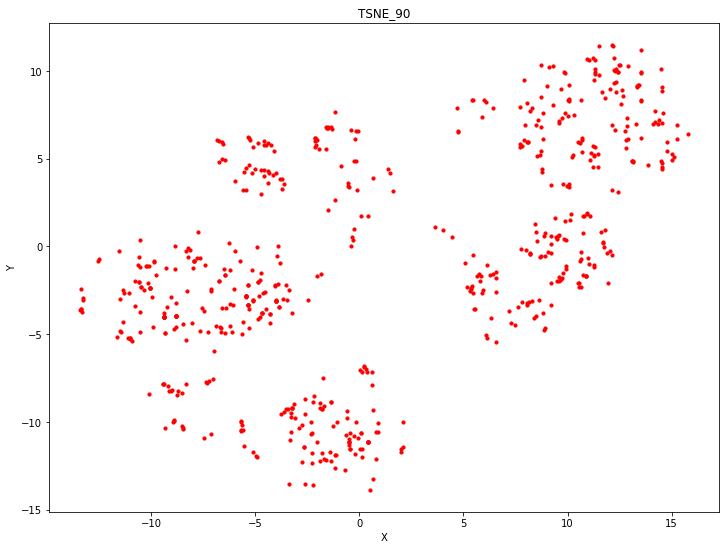

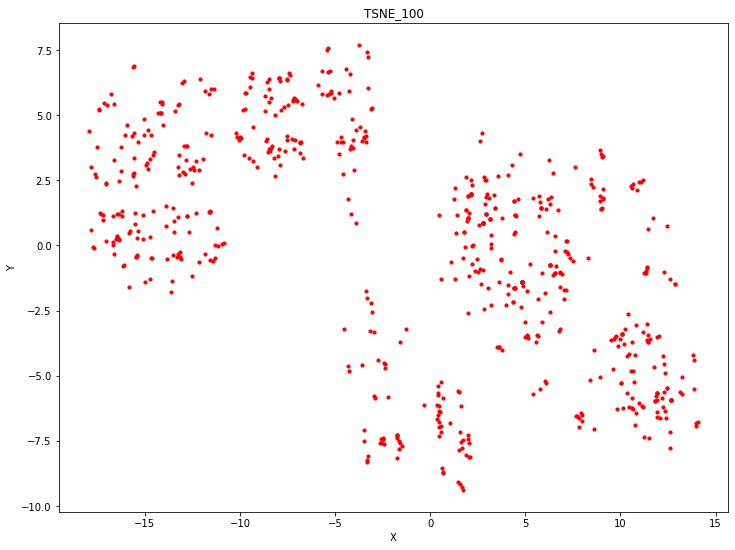

In [68]:
for perplexity in range(10, 110, 10):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    data_tsne = tsne.fit_transform(data)
    fig = plt.figure(figsize=(12,9))
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], s=10, c='r')
    plt.title('TSNE_{}'.format(str(perplexity)))
    plt.xlabel('X')
    plt.ylabel('Y')


In [69]:
# UMAP

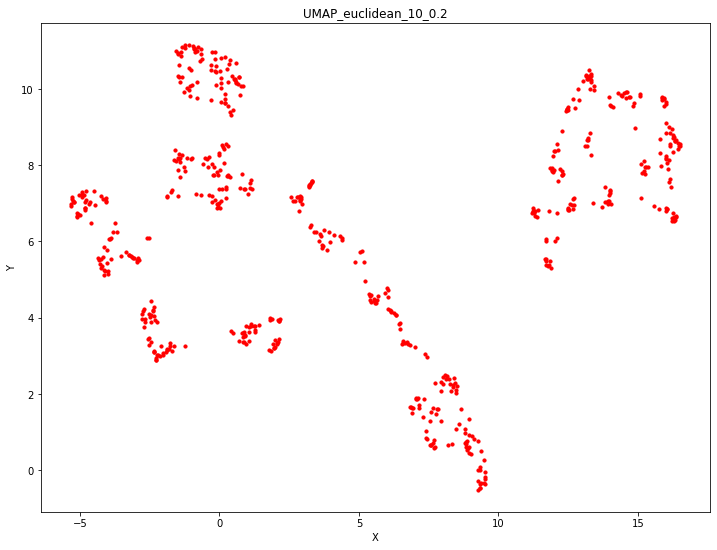

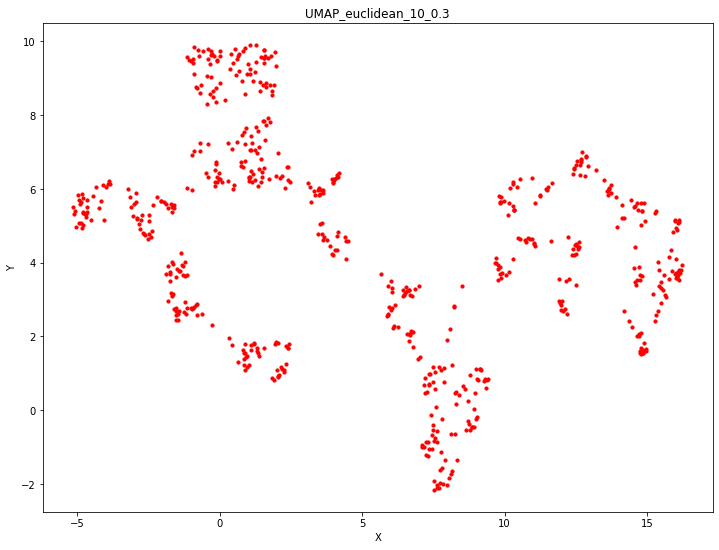

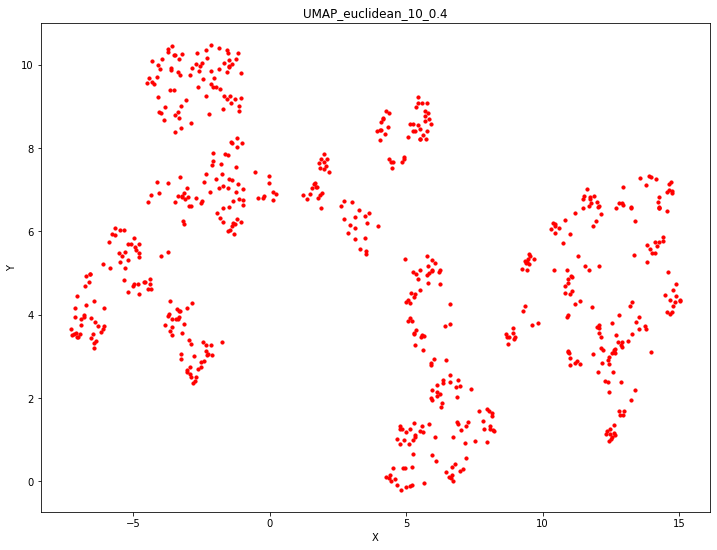

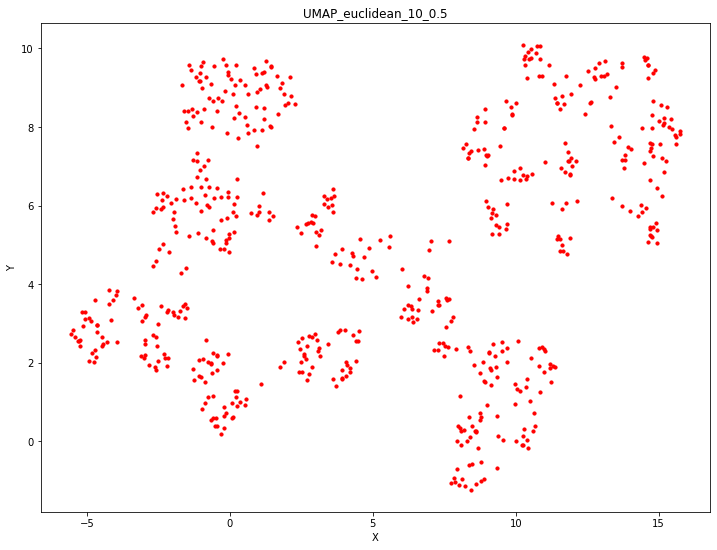

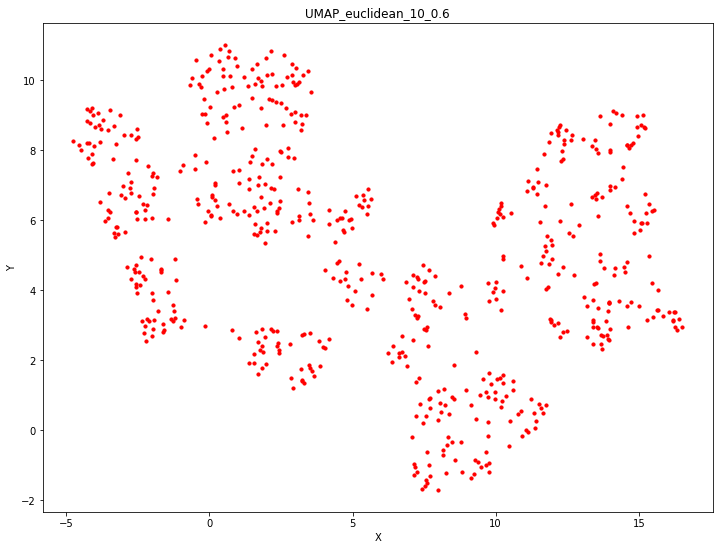

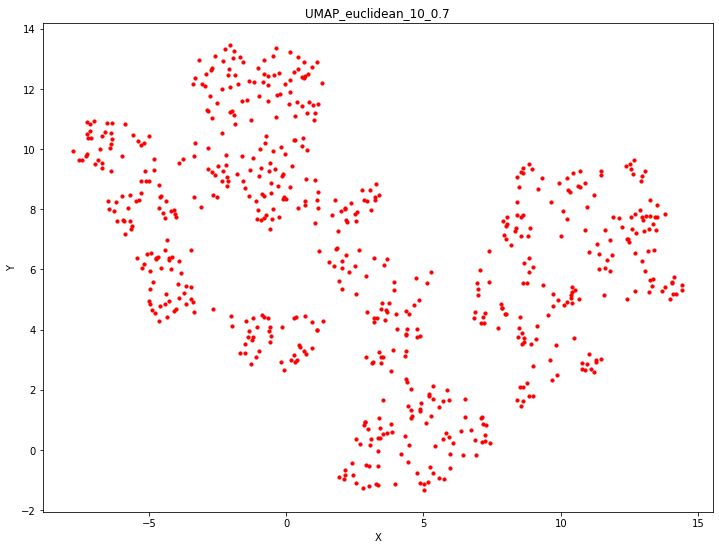

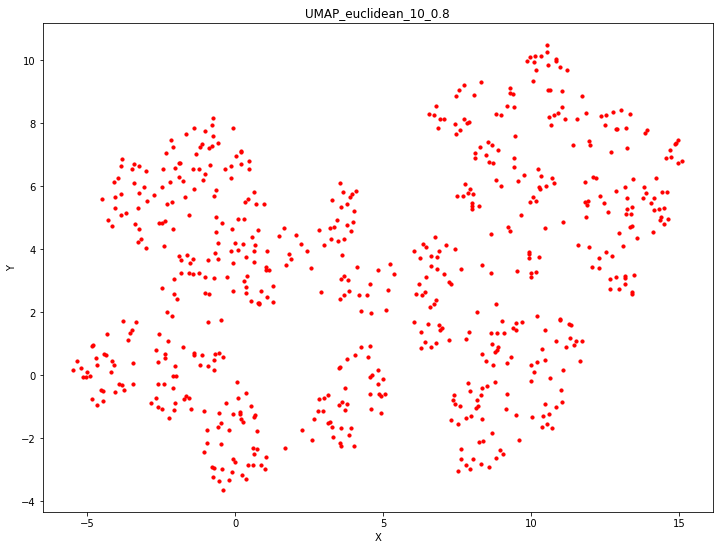

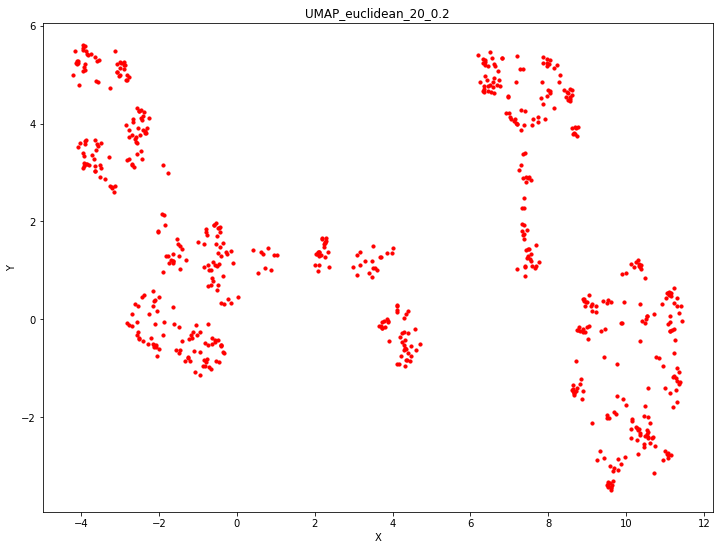

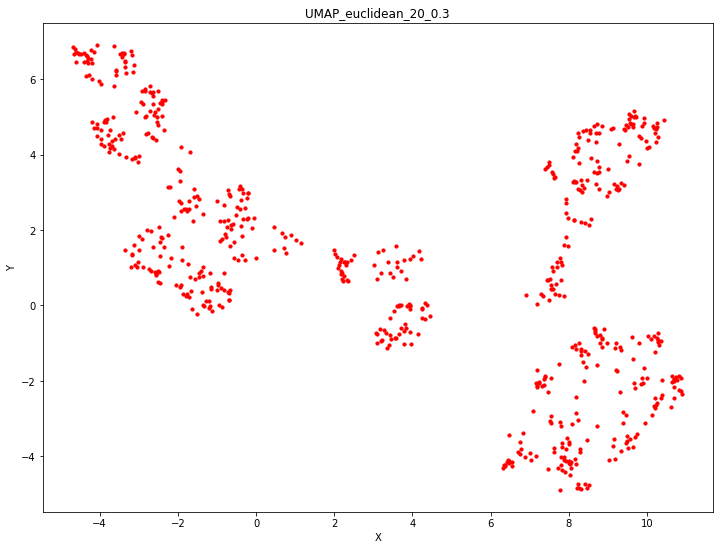

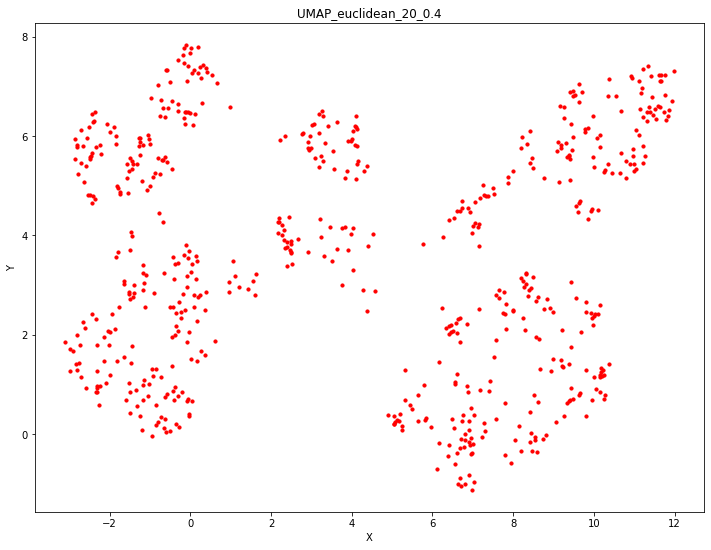

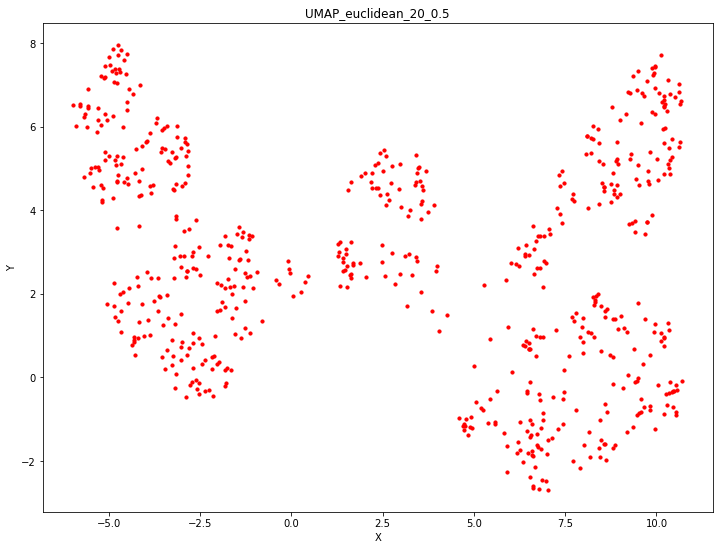

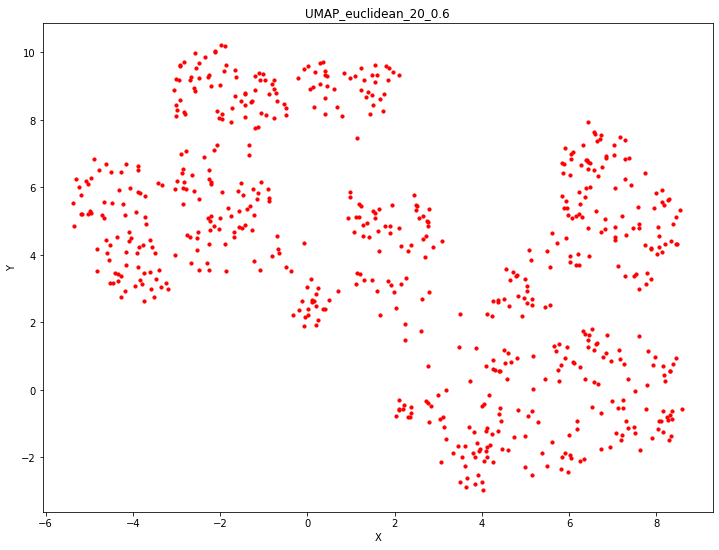

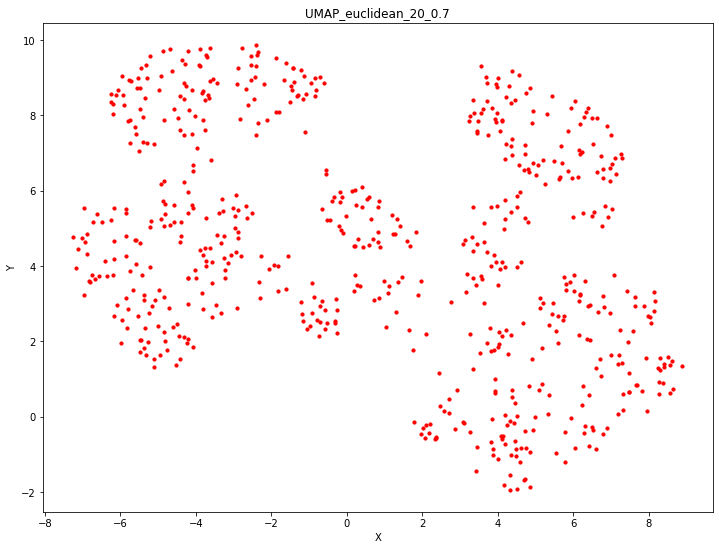

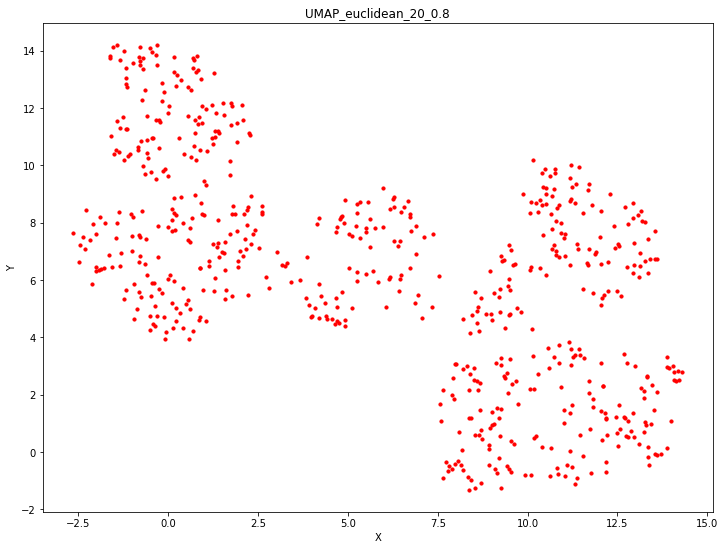

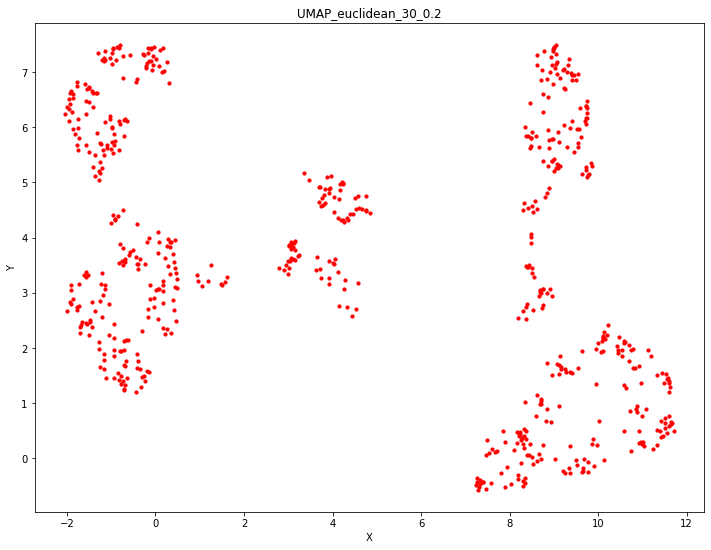

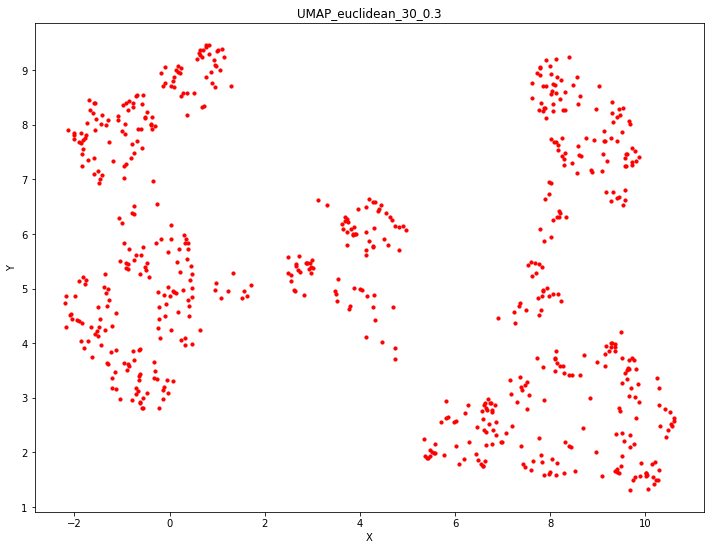

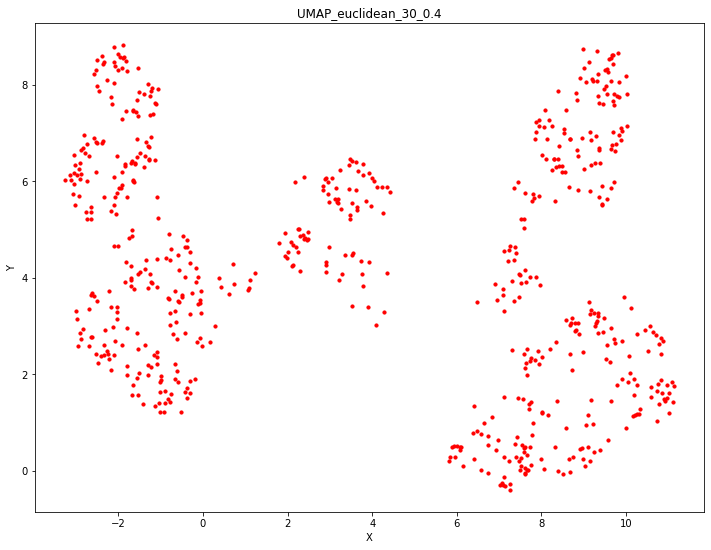

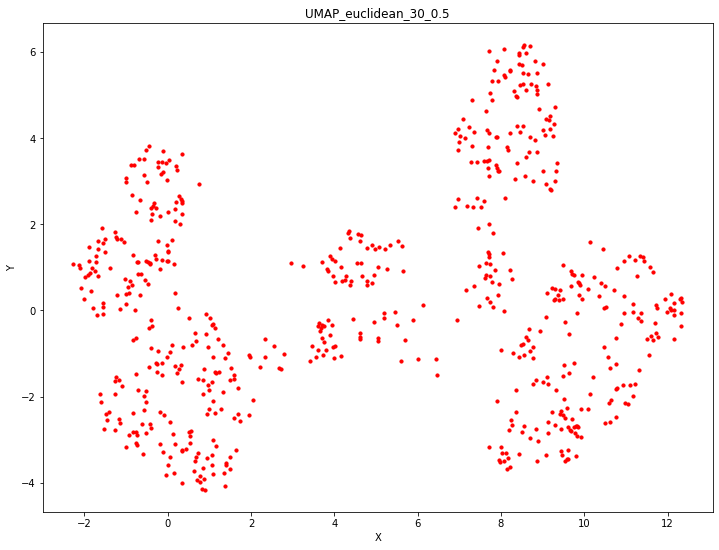

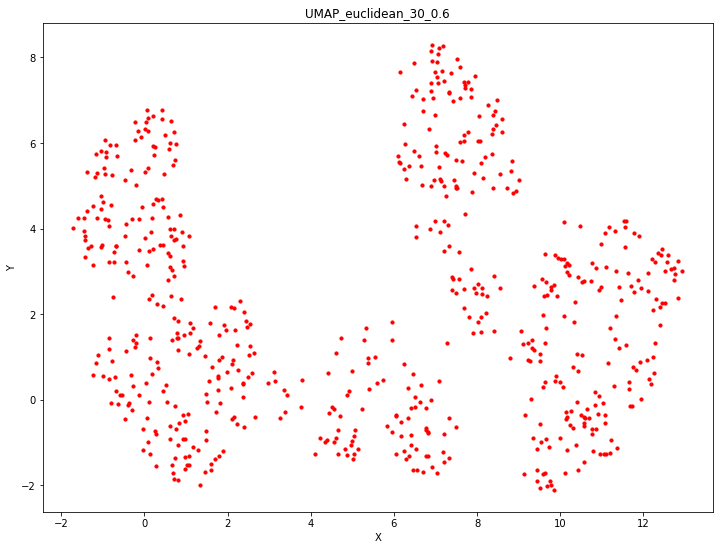

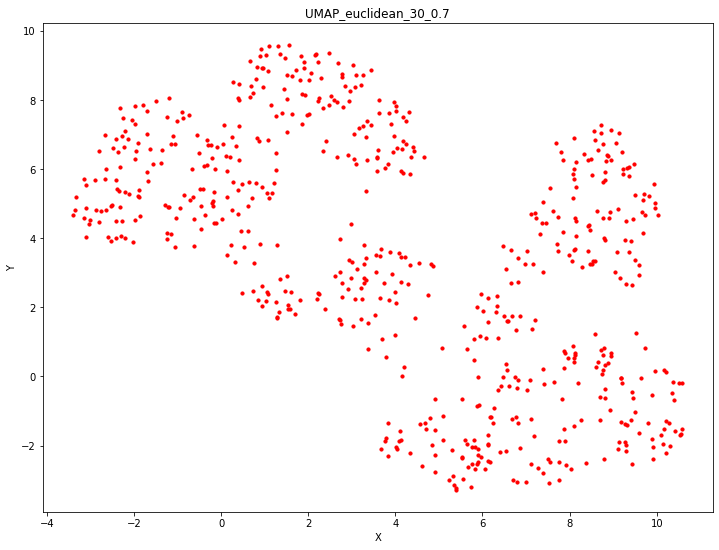

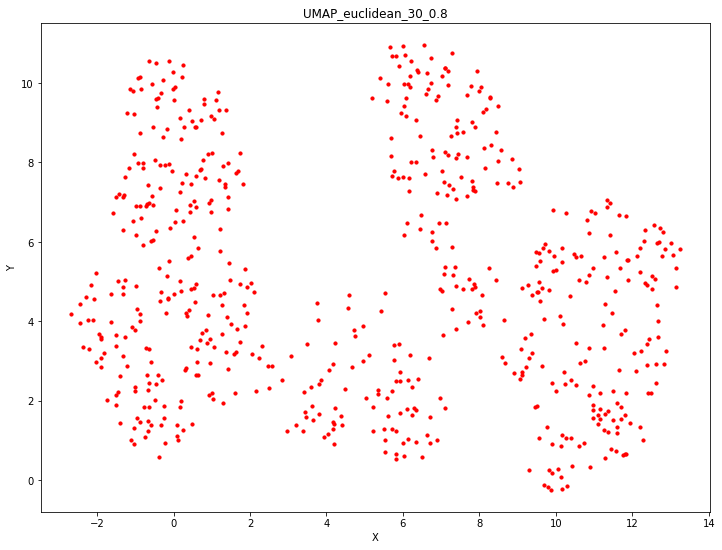

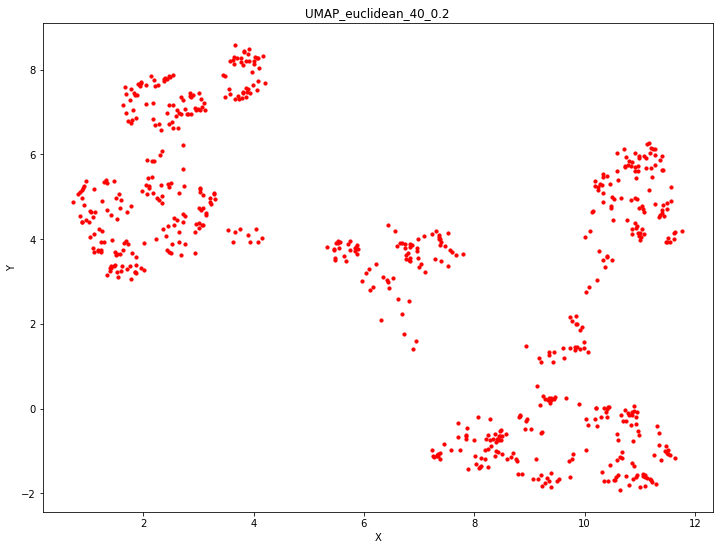

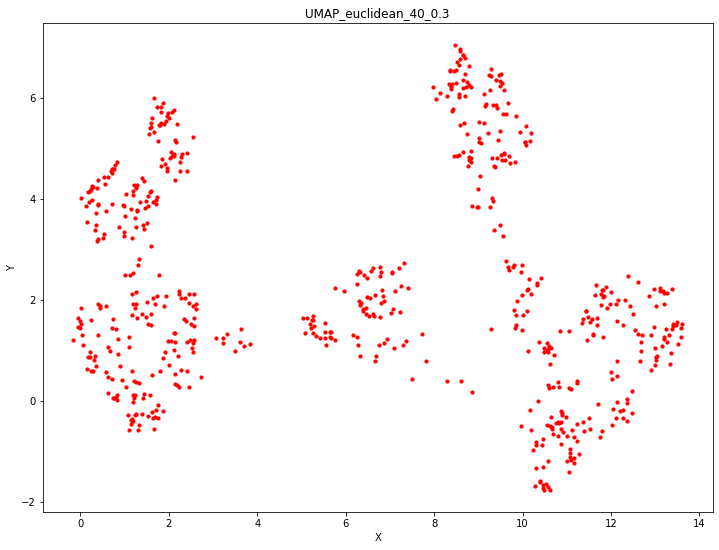

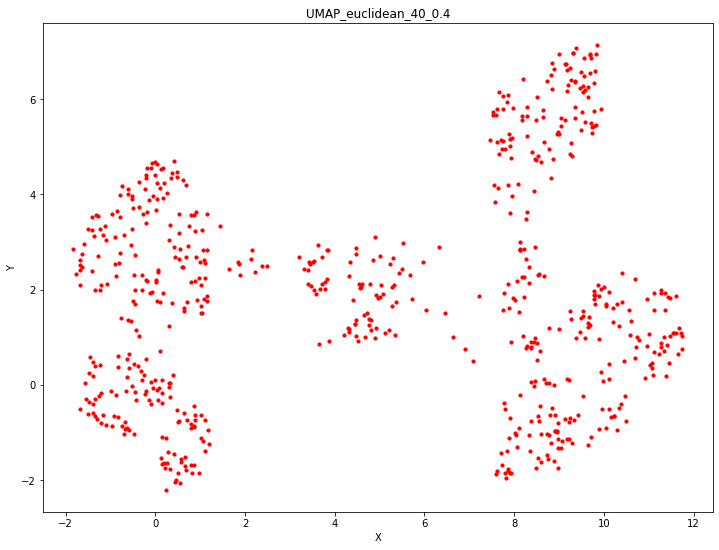

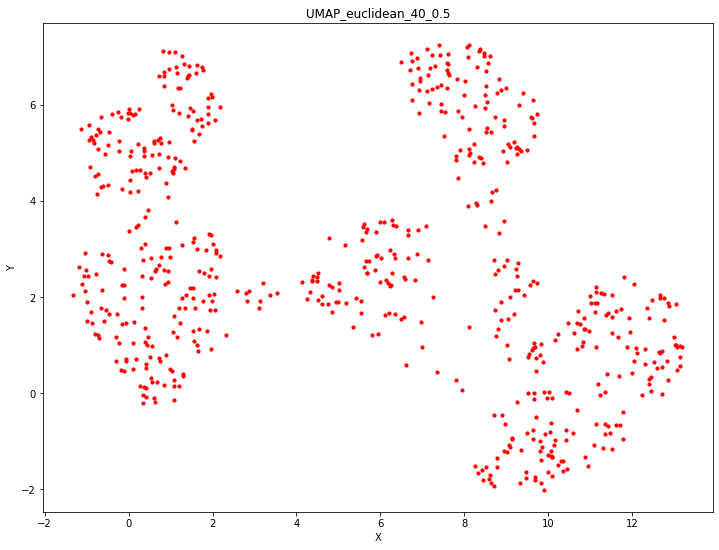

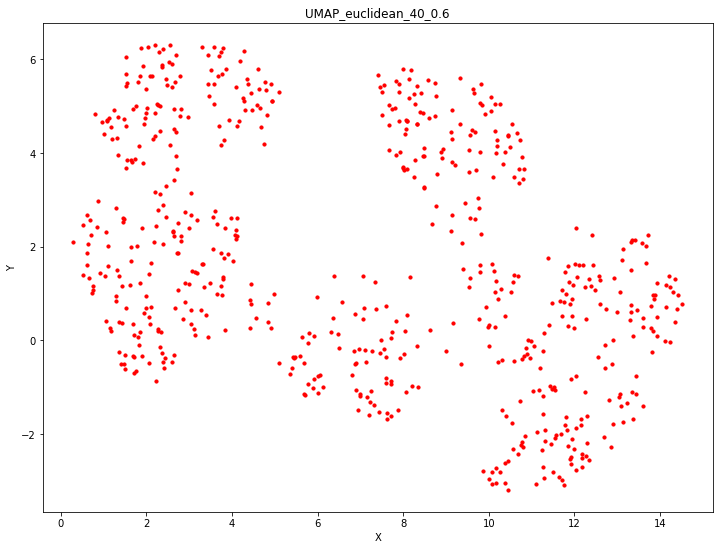

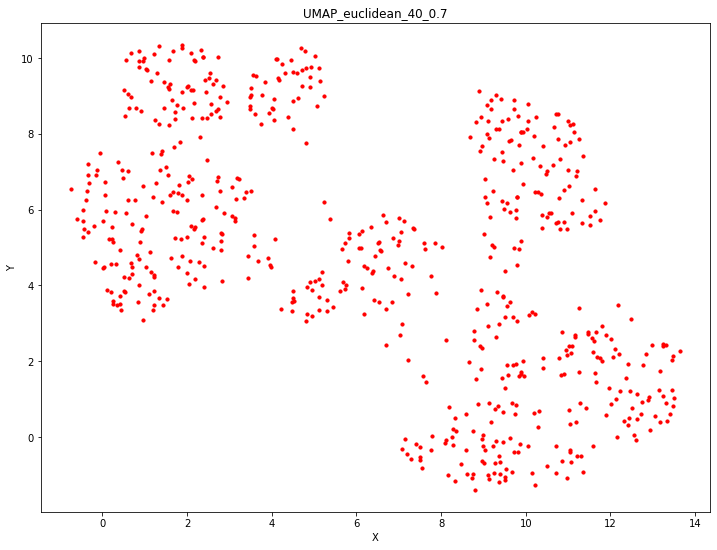

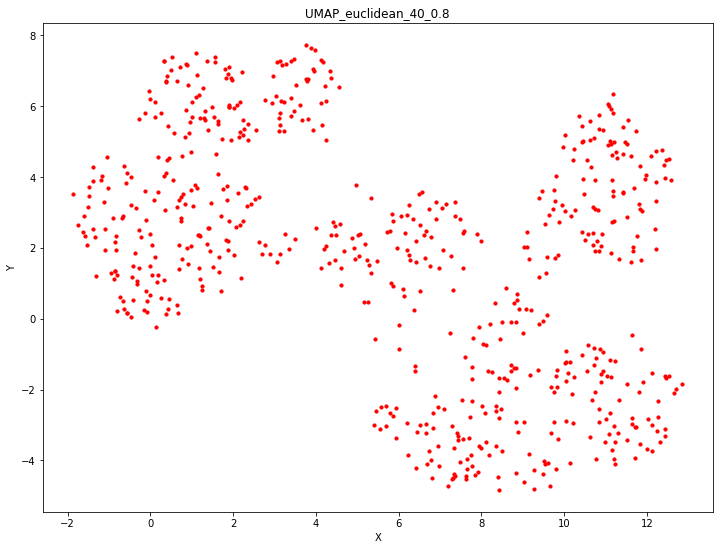

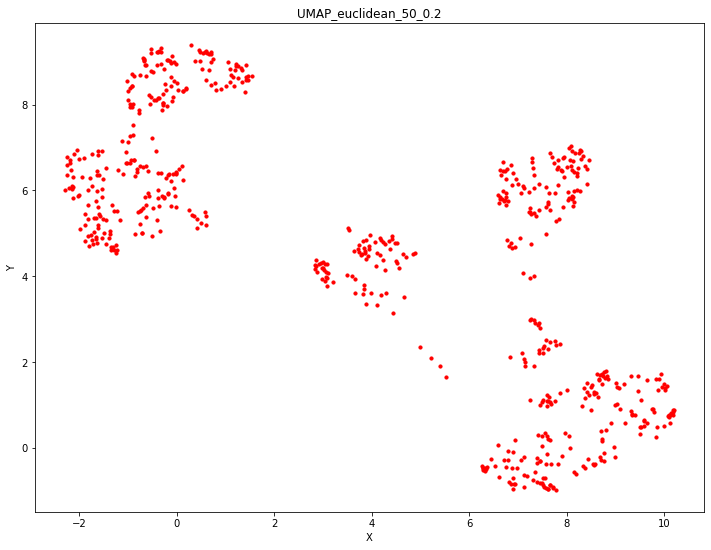

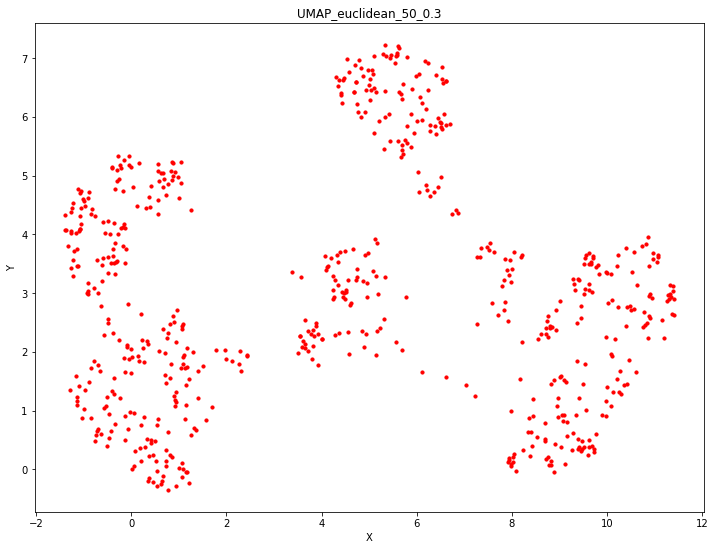

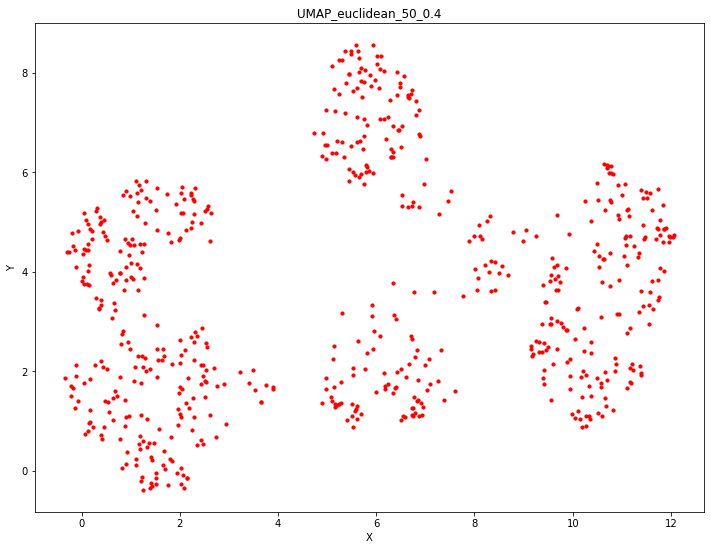

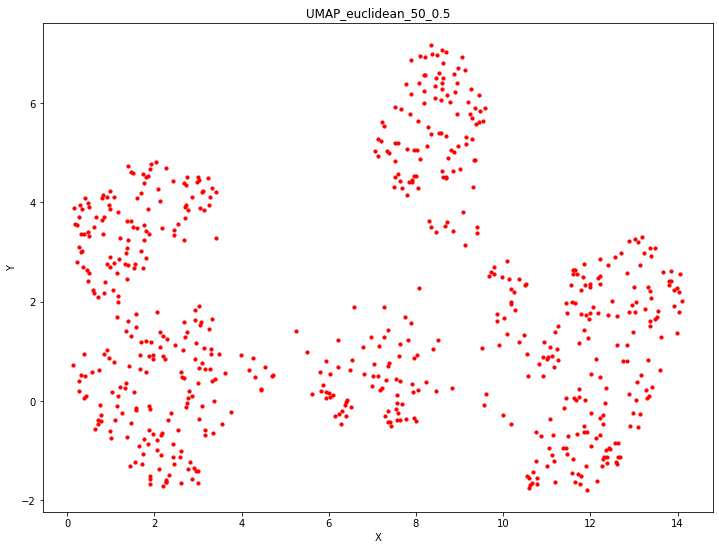

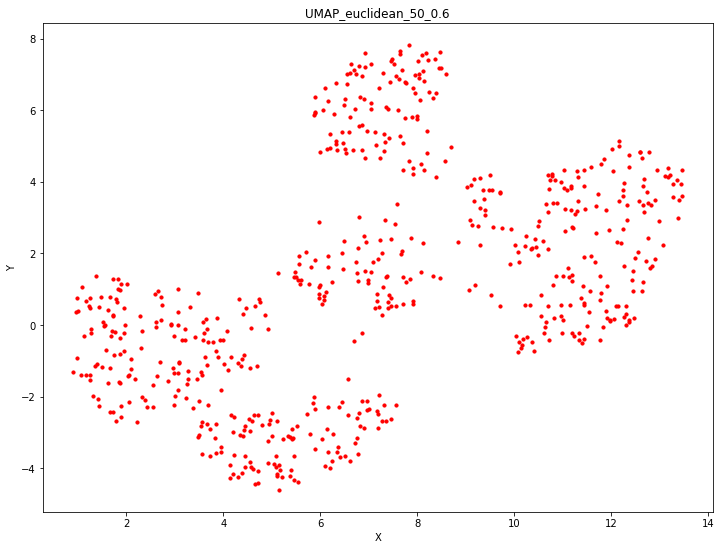

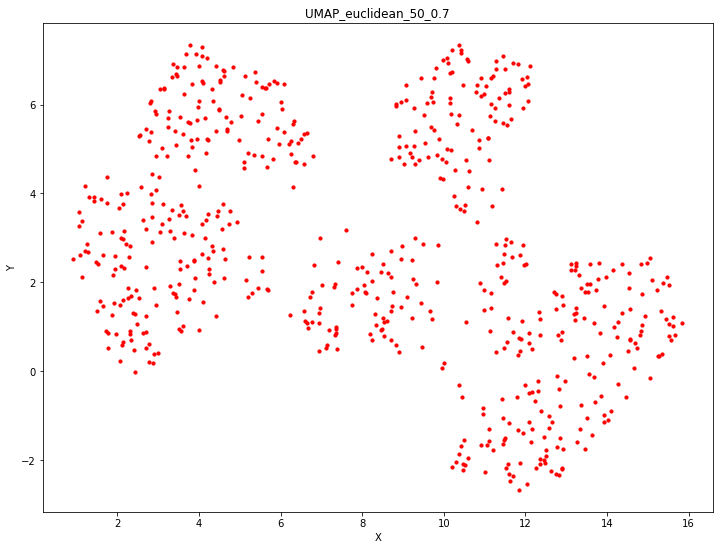

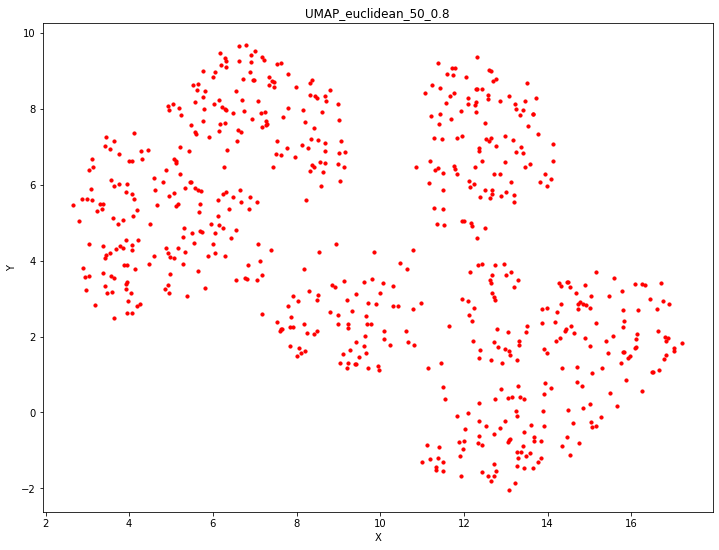

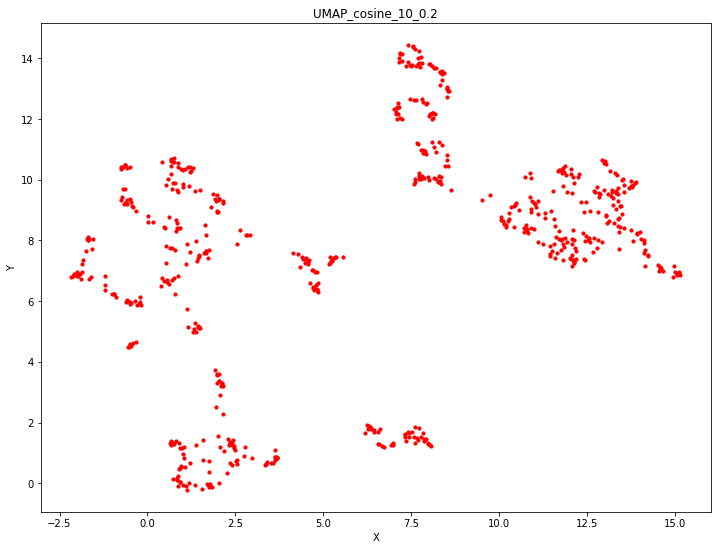

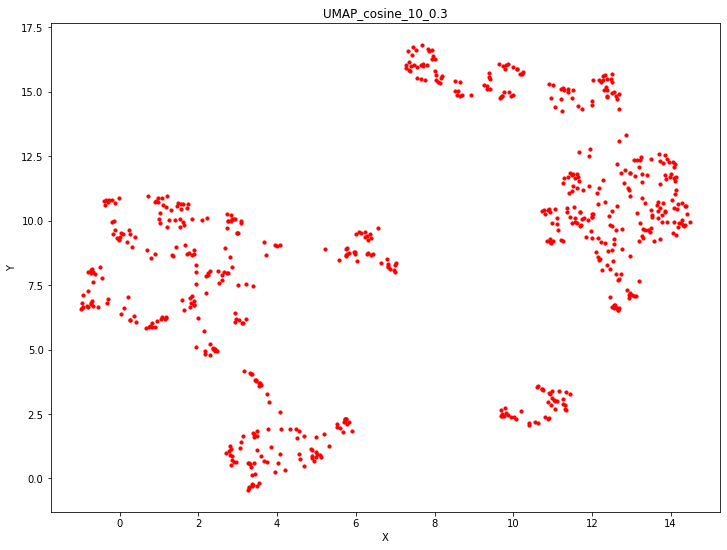

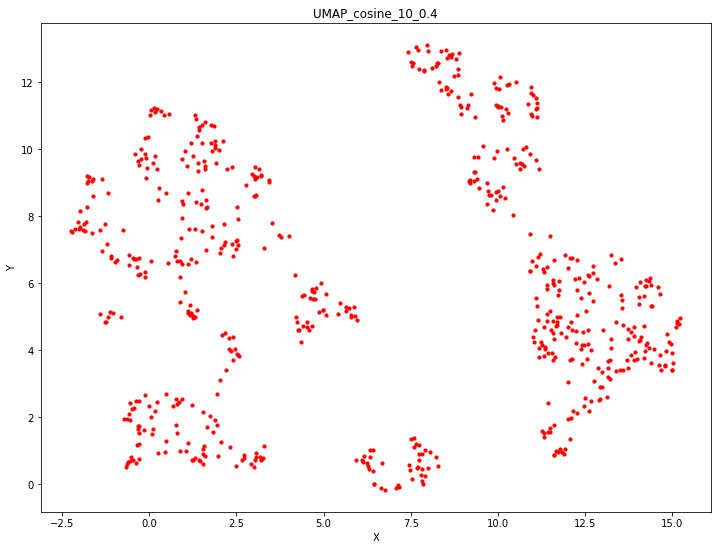

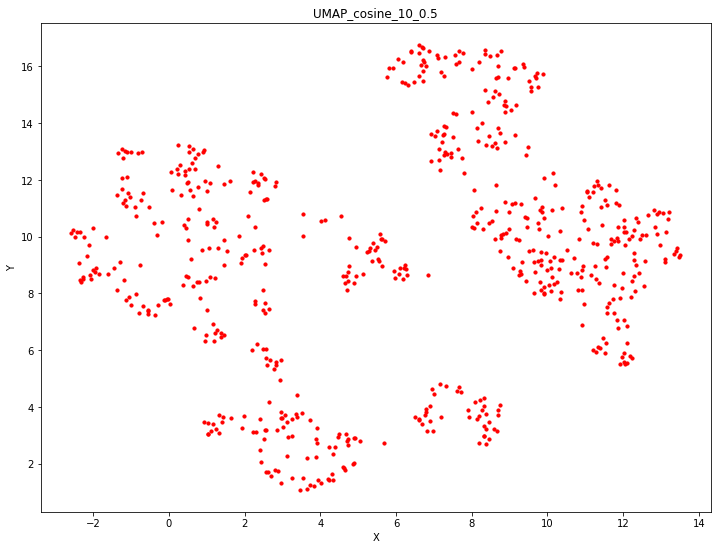

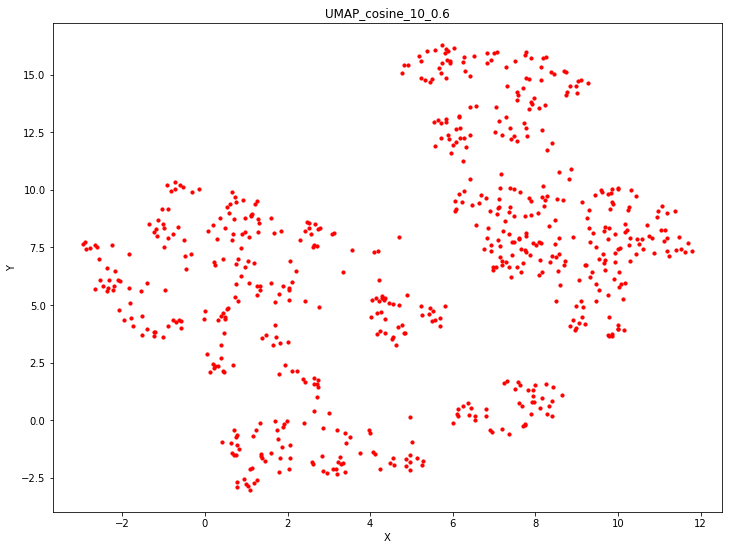

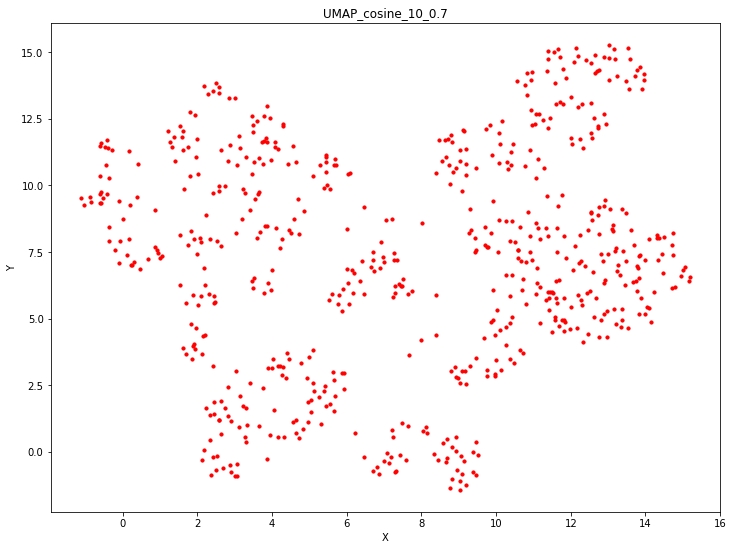

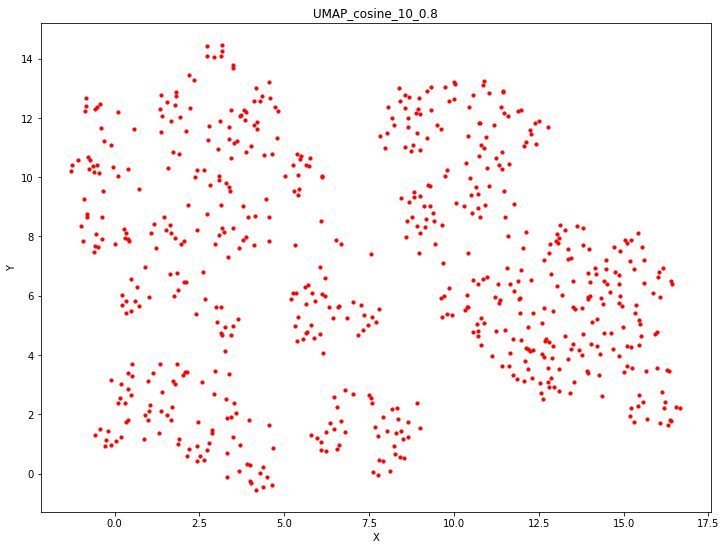

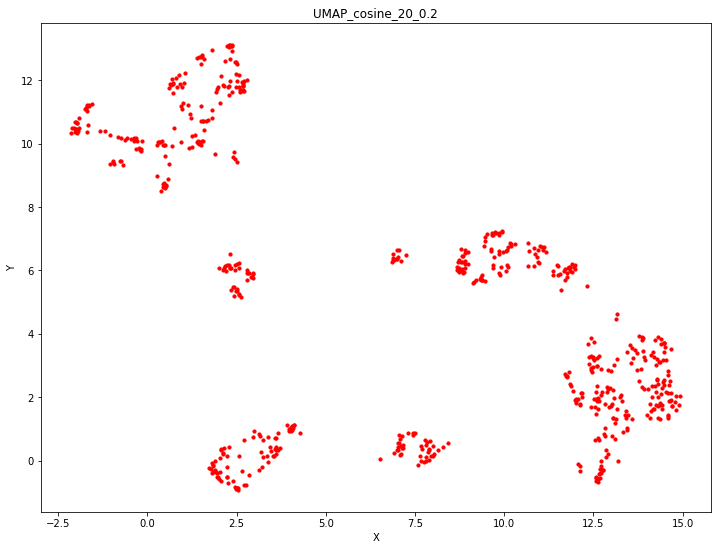

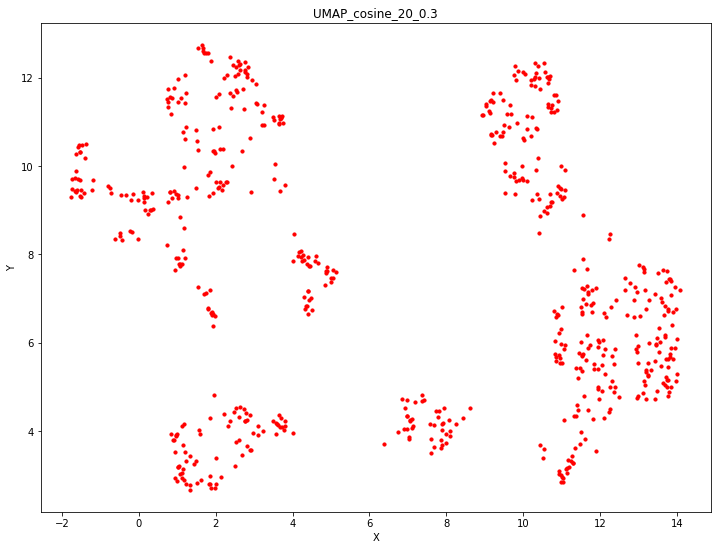

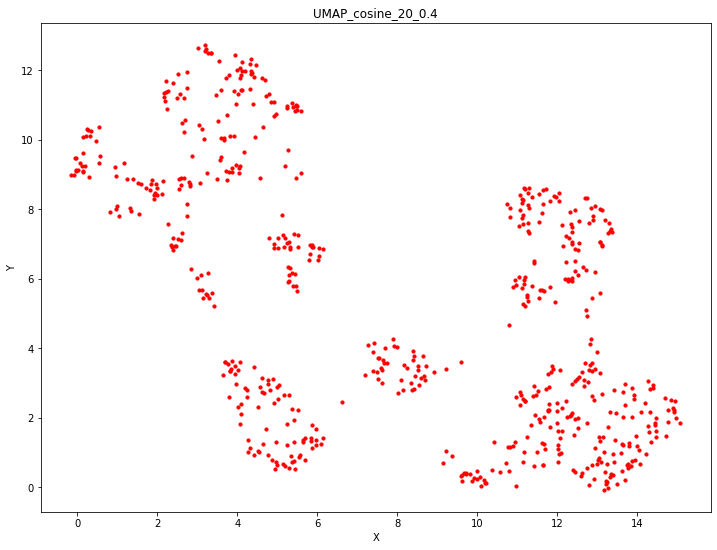

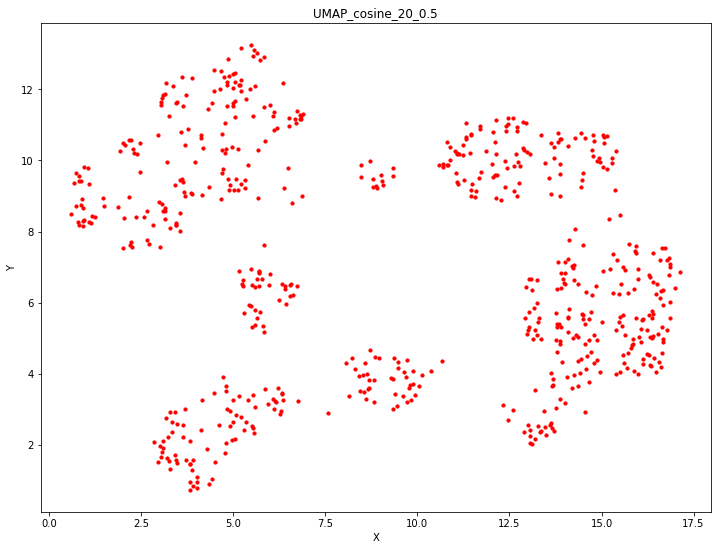

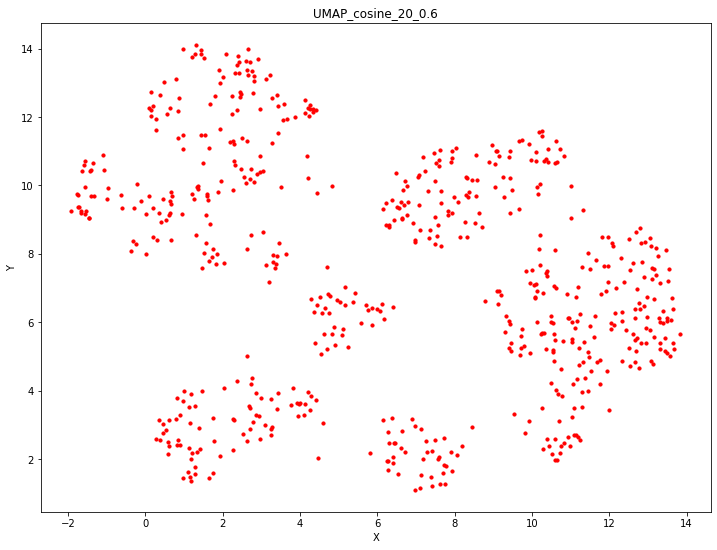

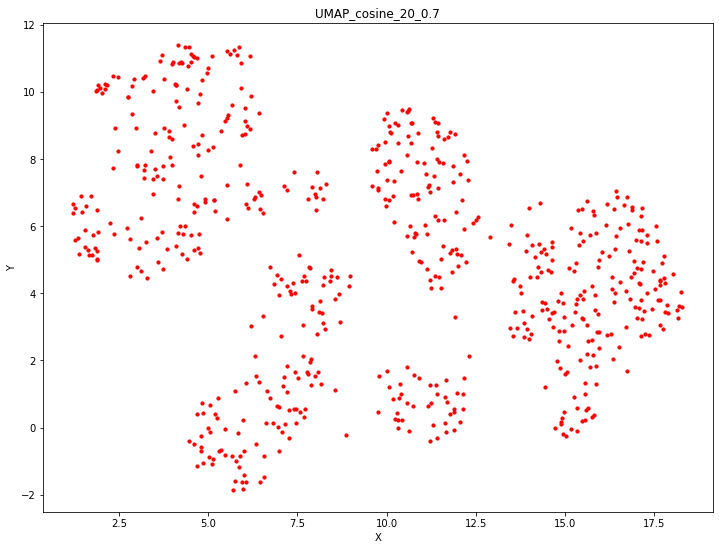

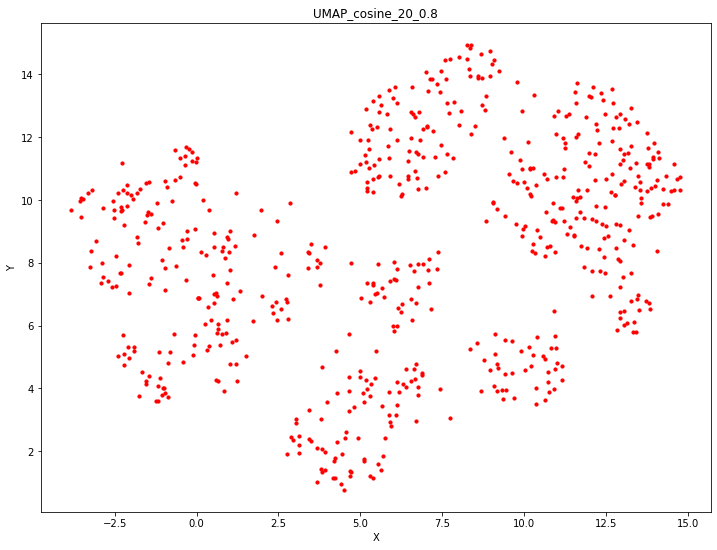

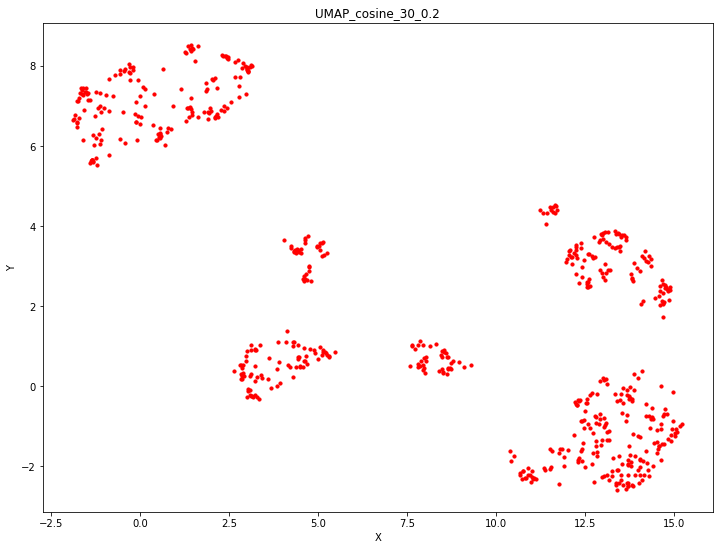

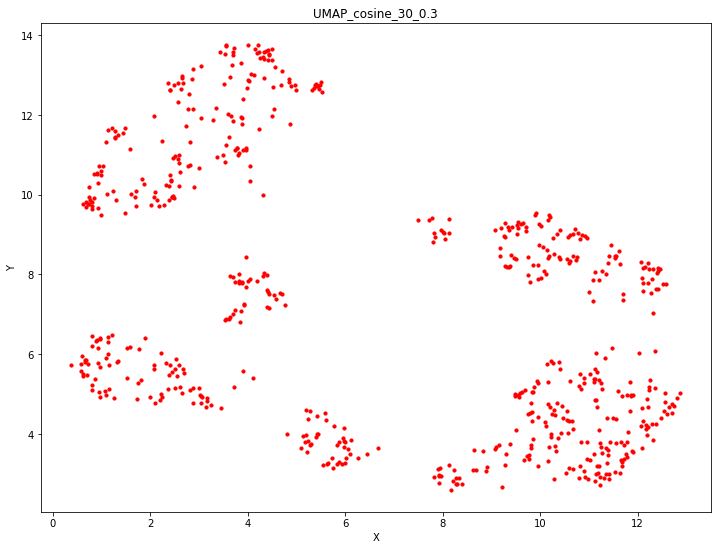

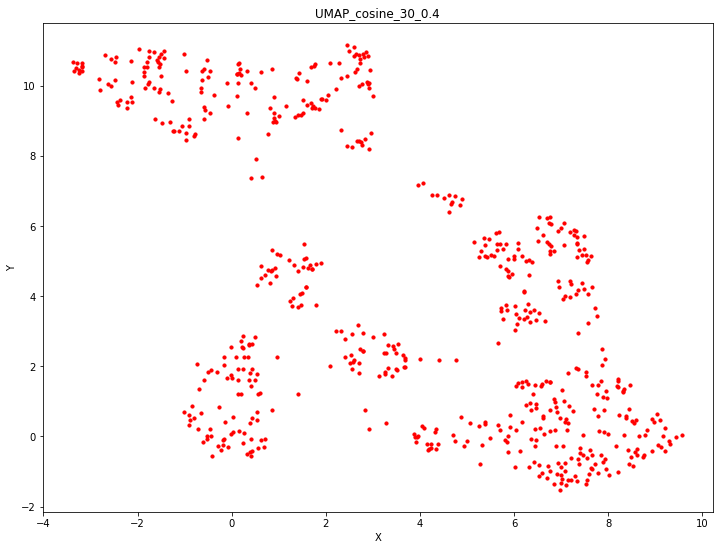

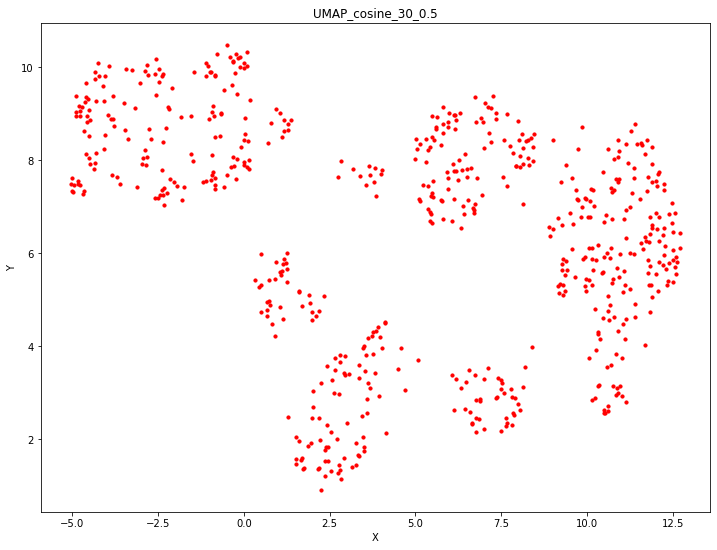

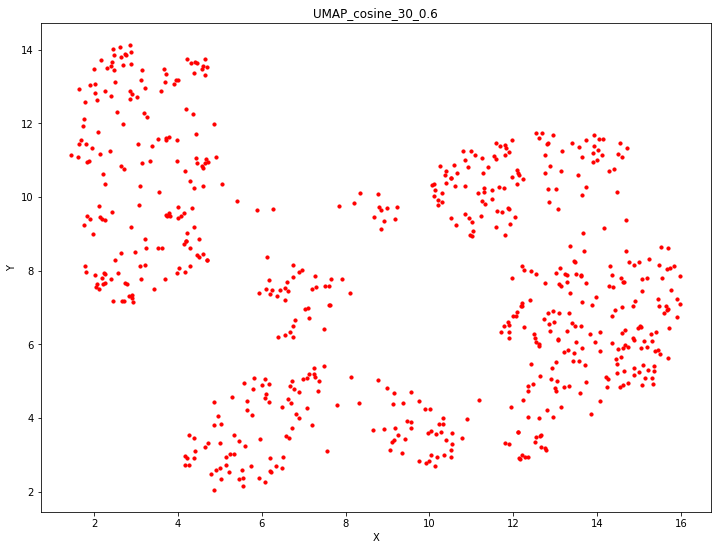

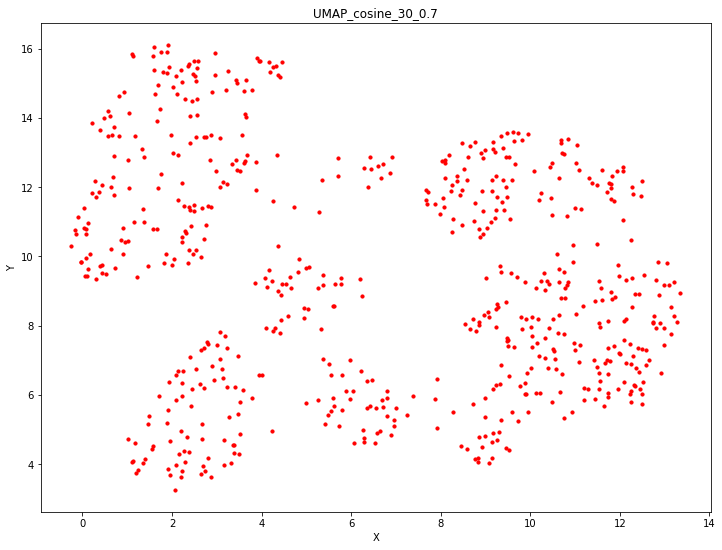

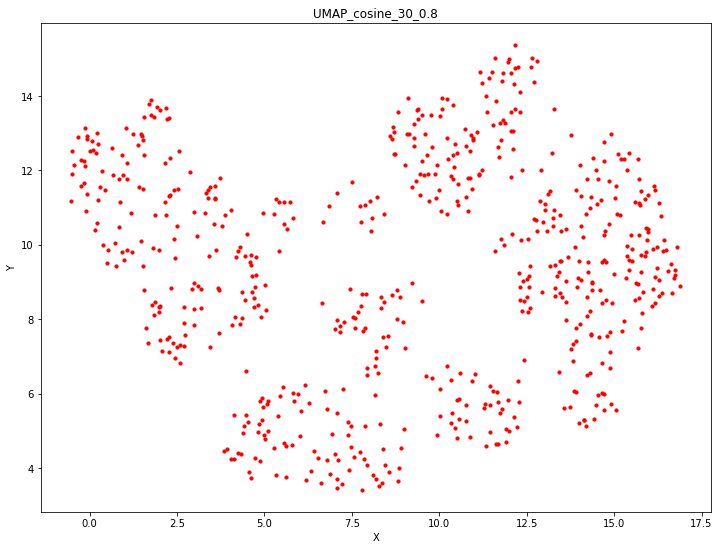

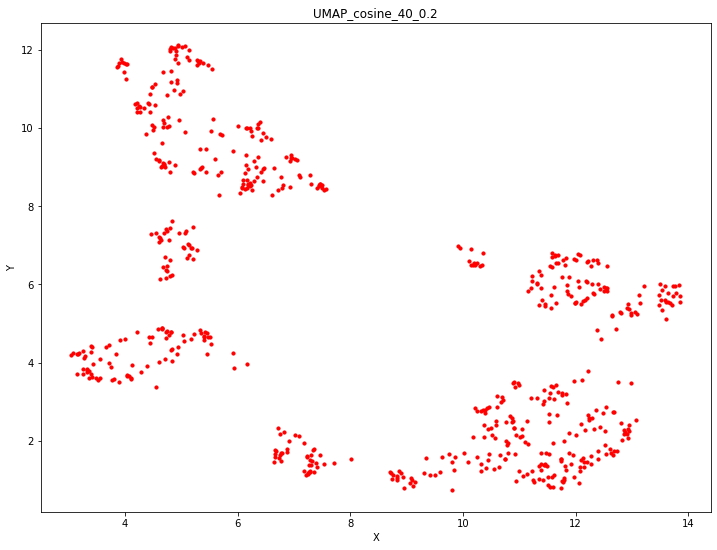

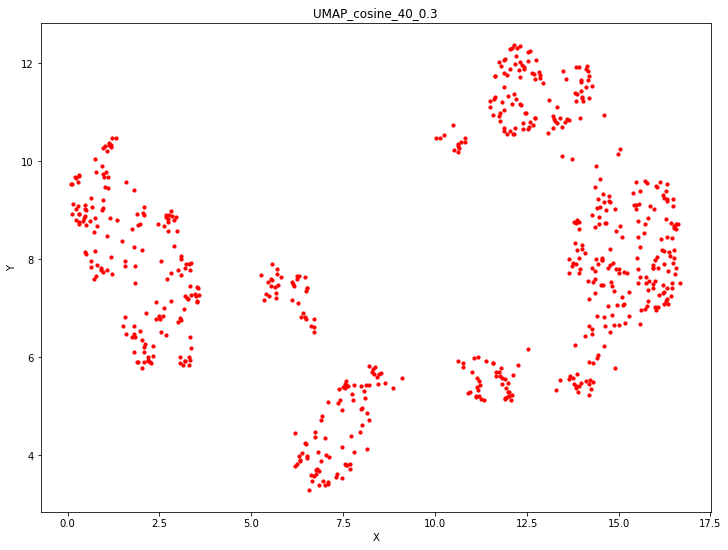

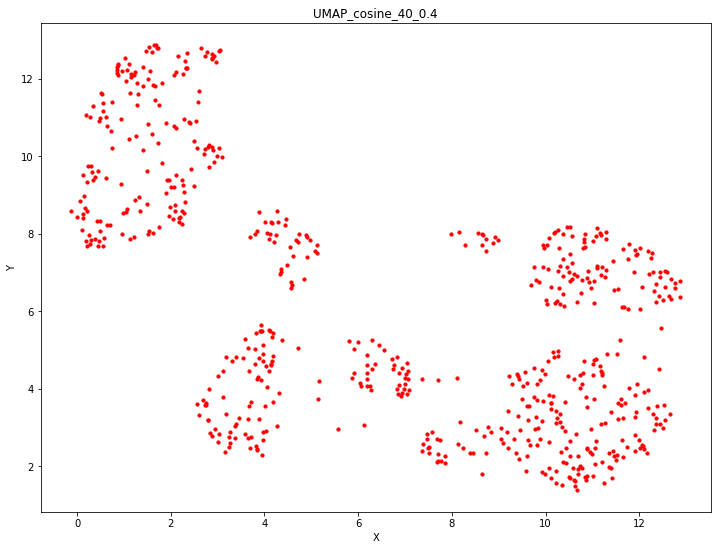

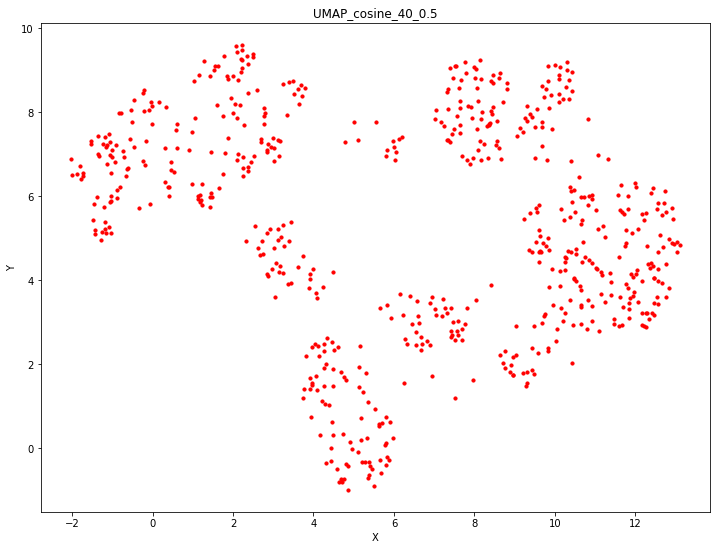

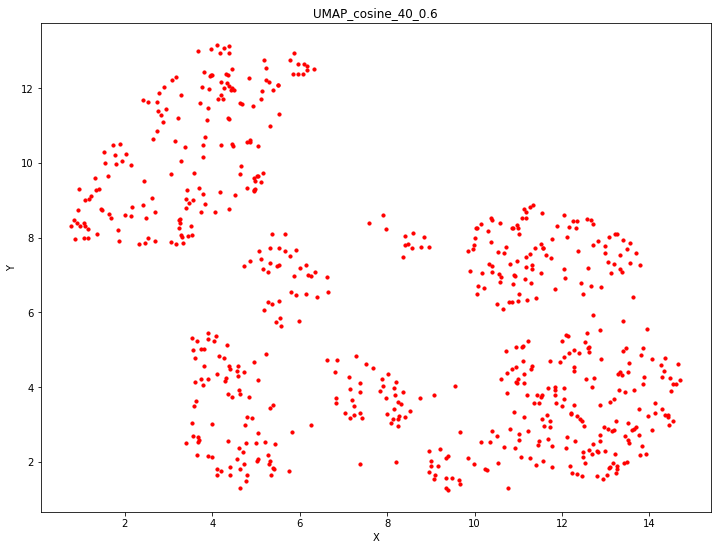

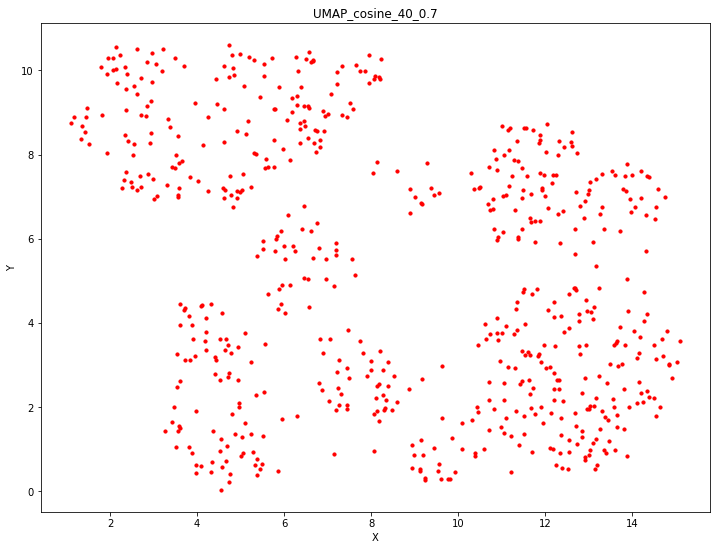

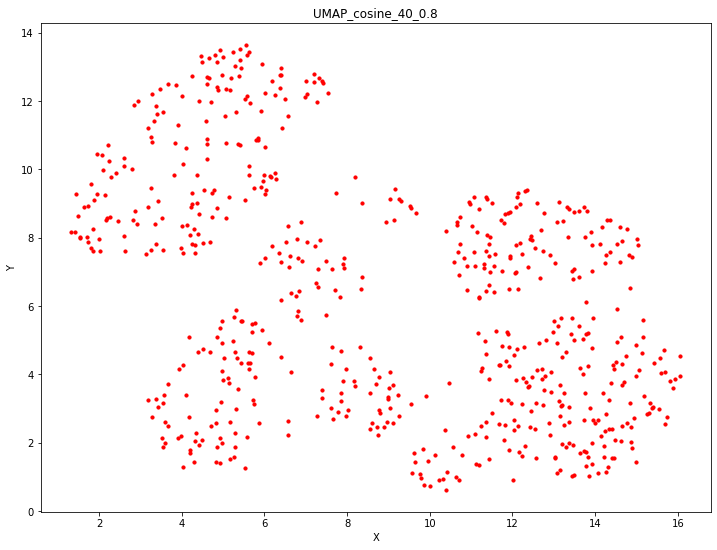

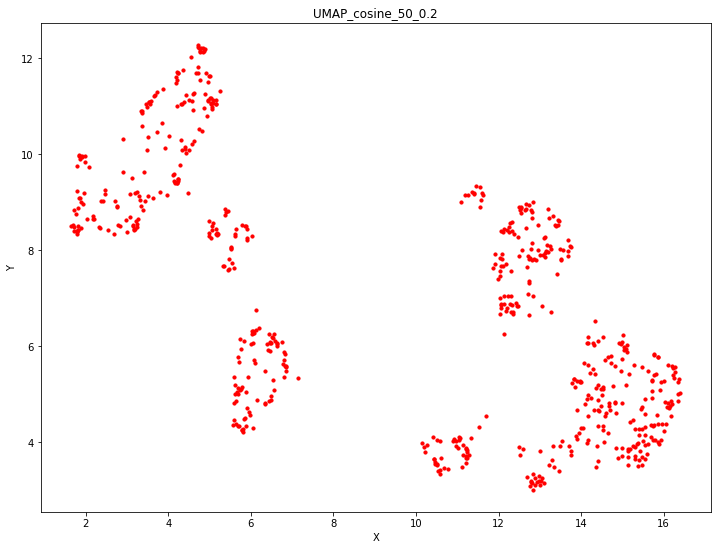

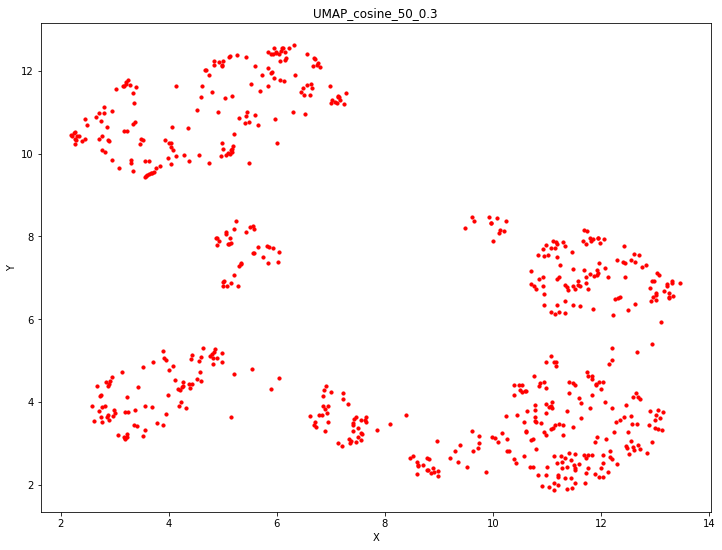

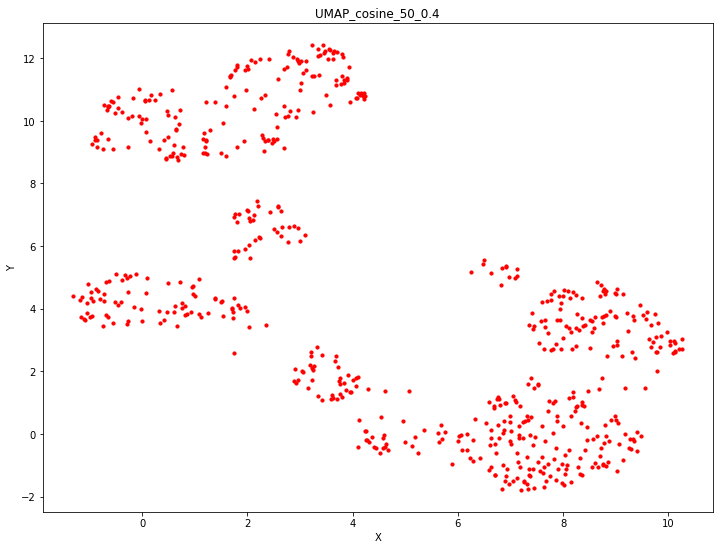

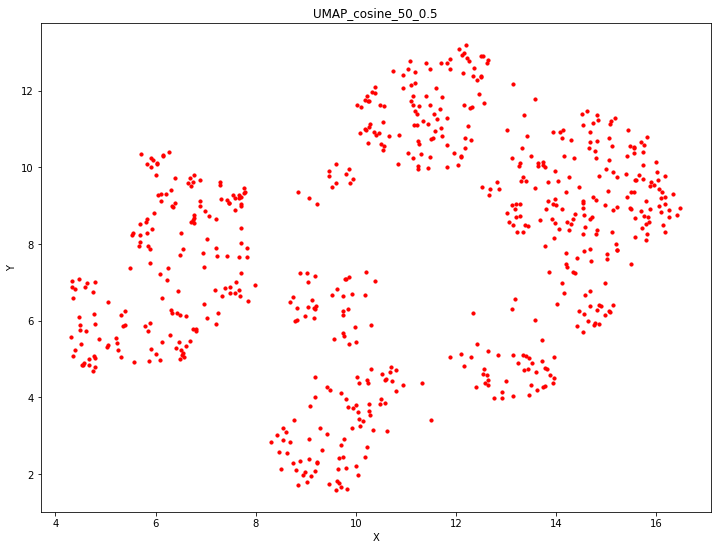

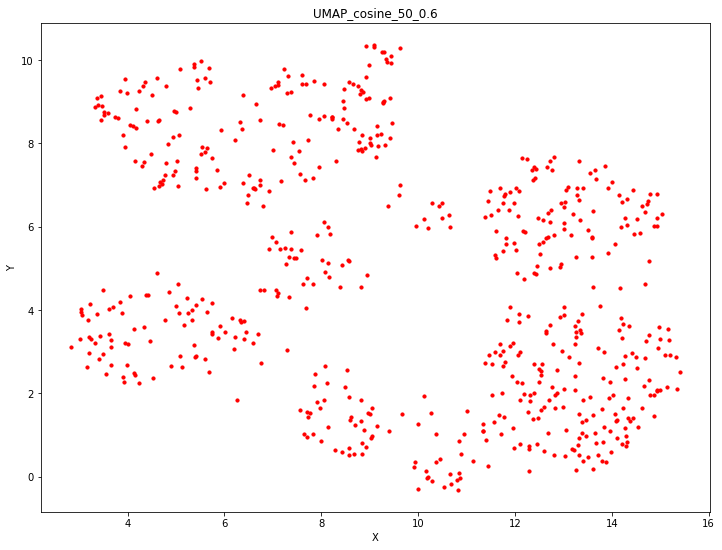

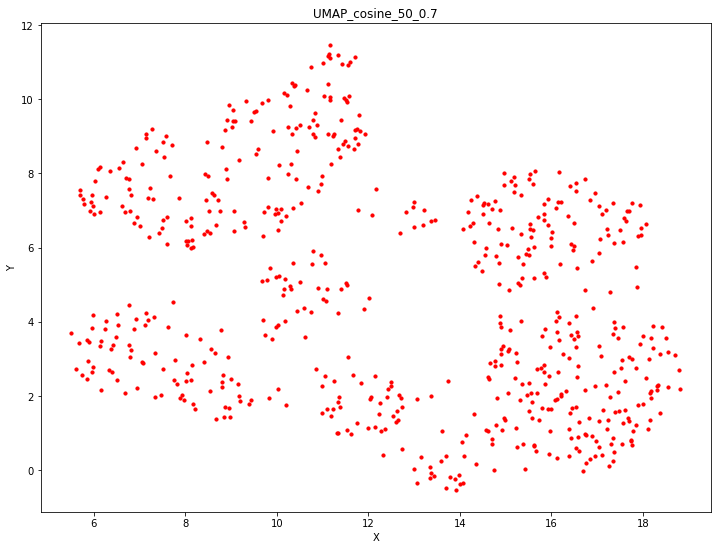

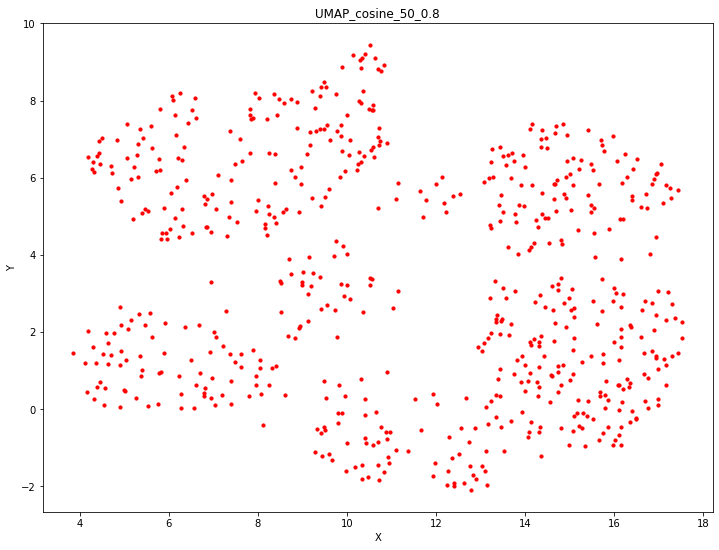

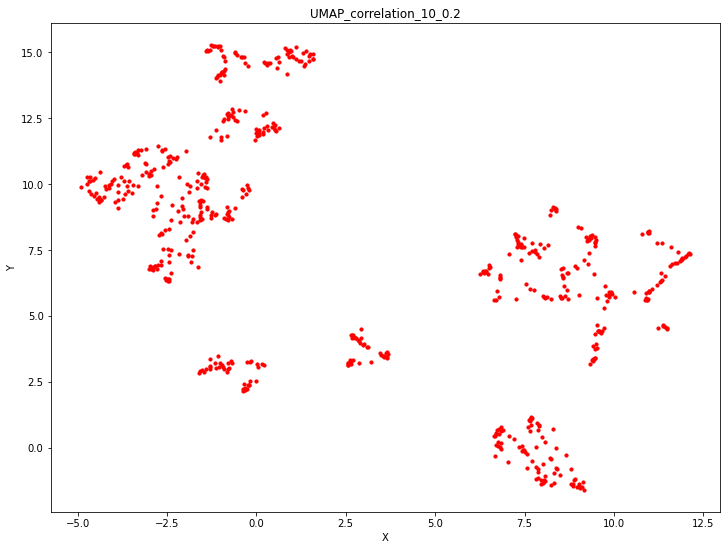

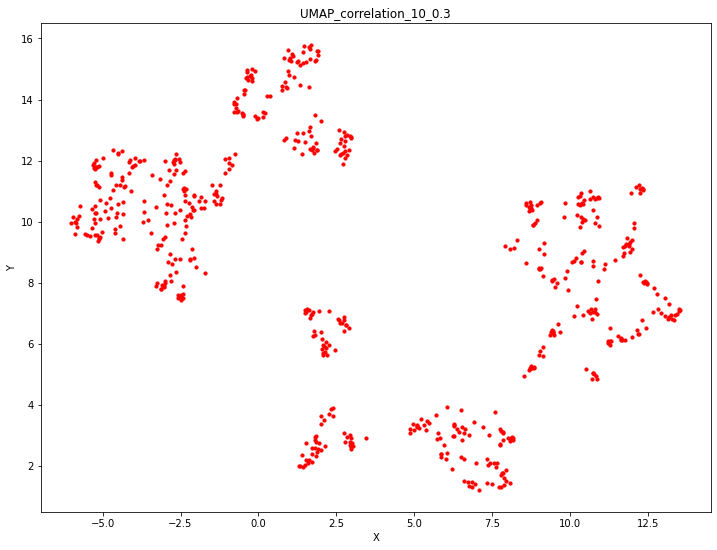

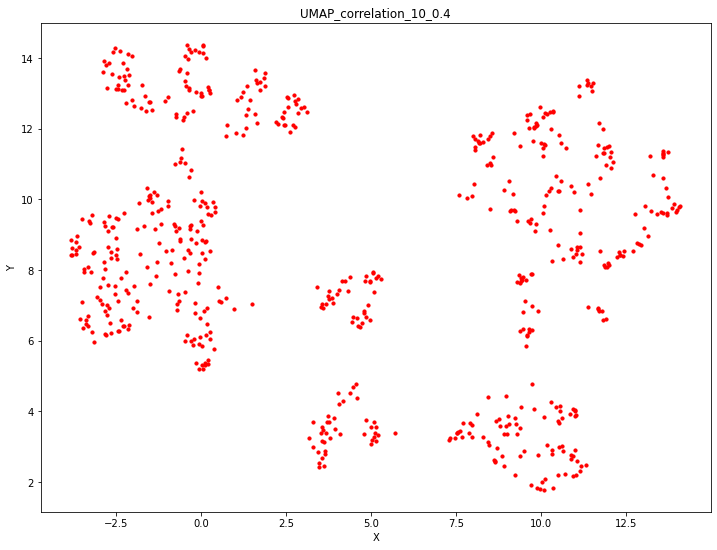

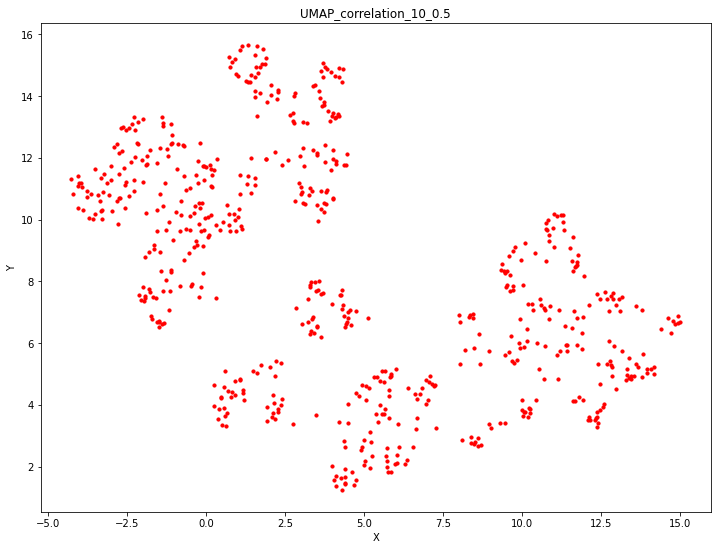

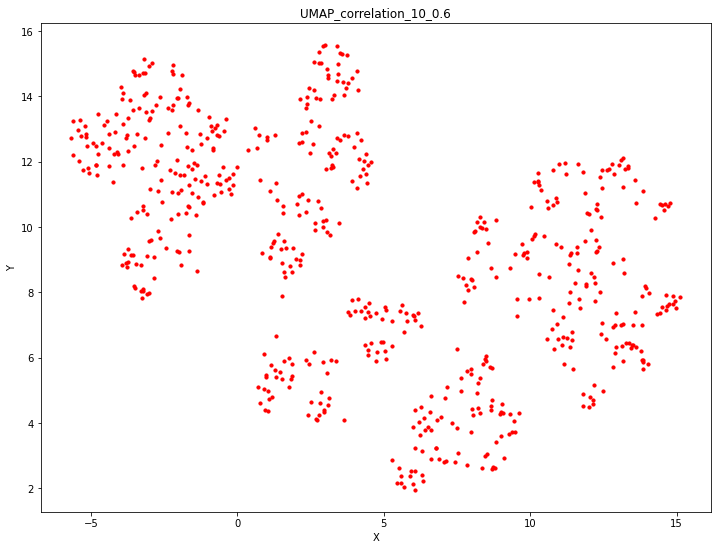

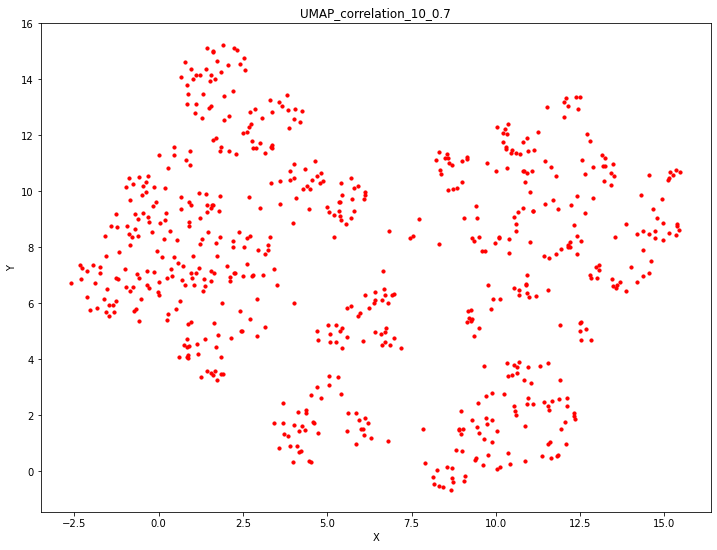

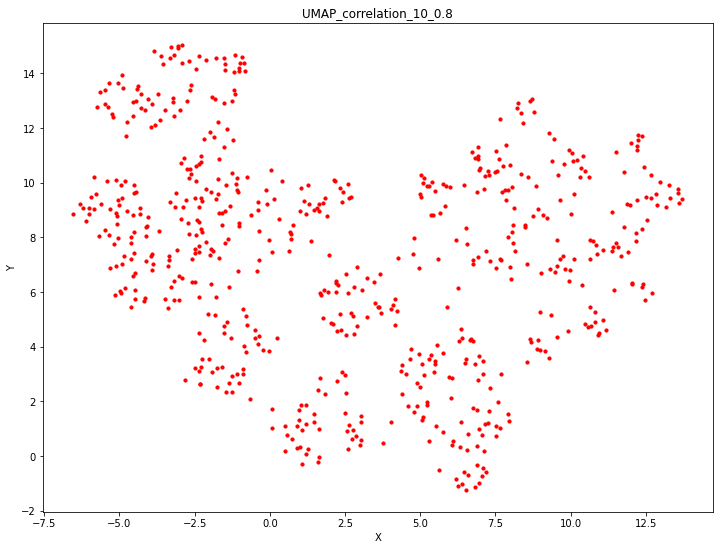

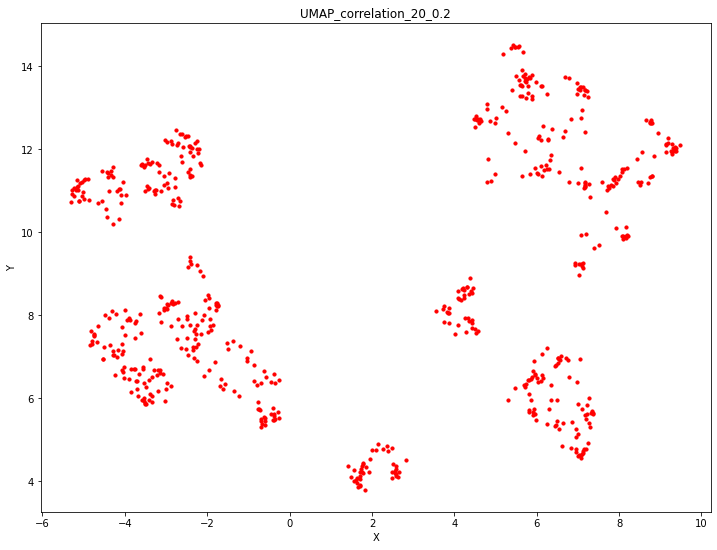

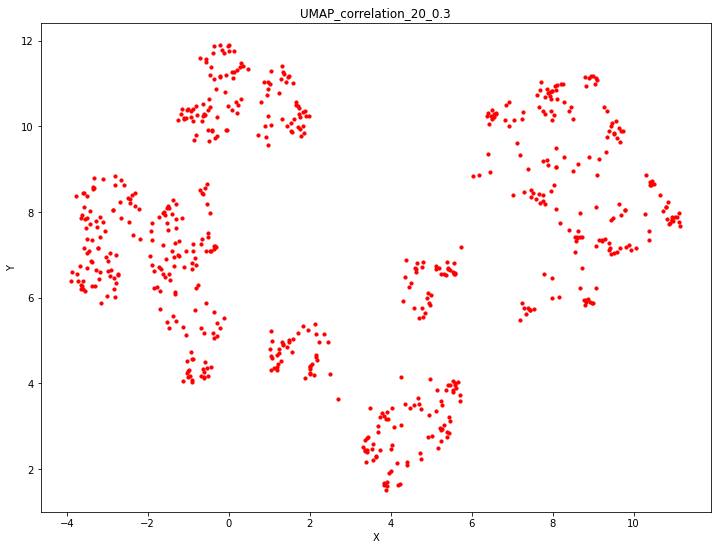

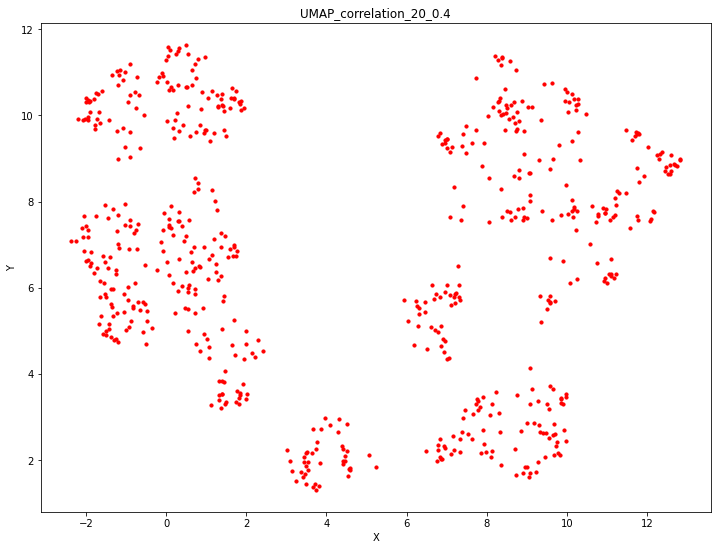

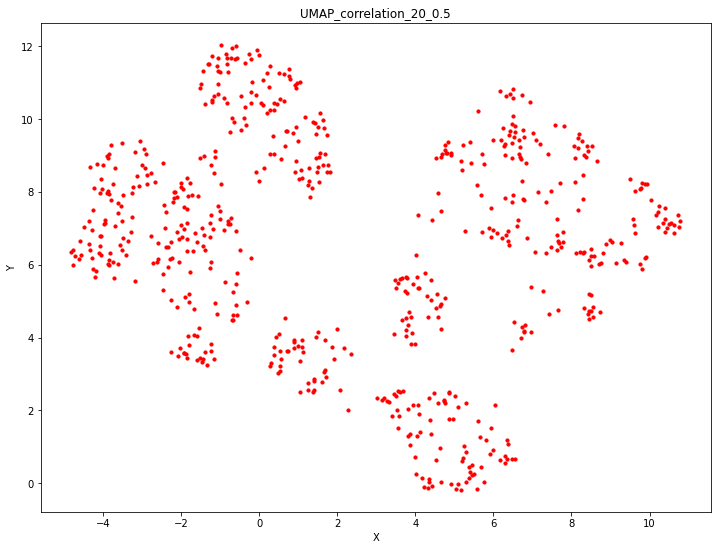

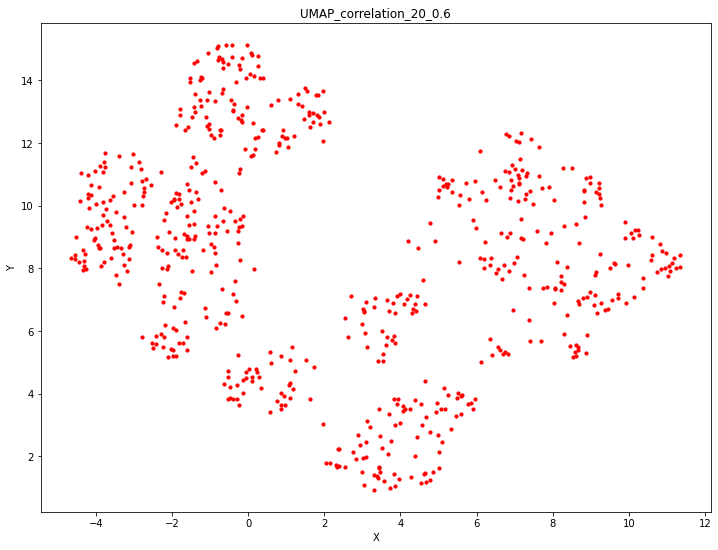

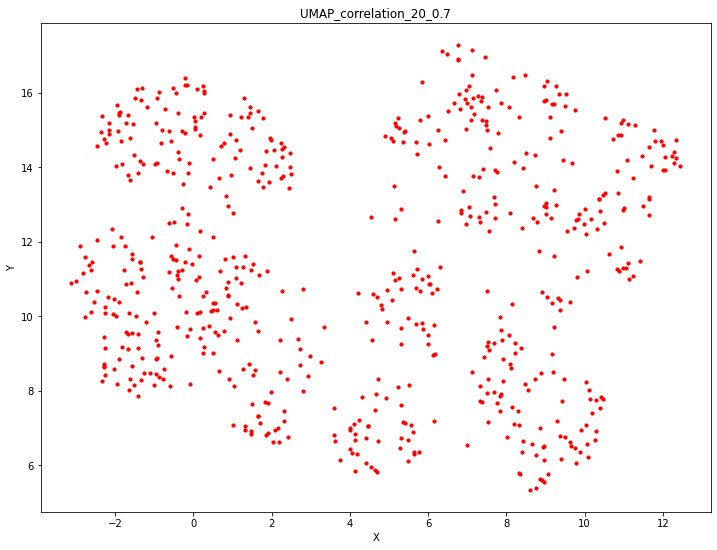

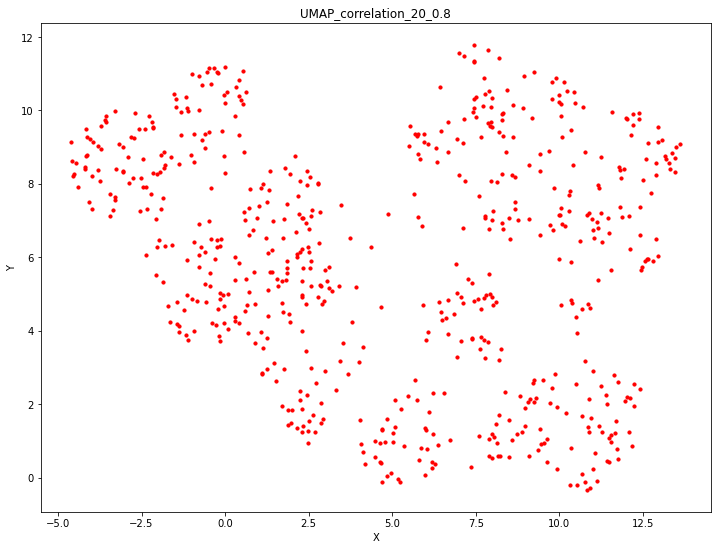

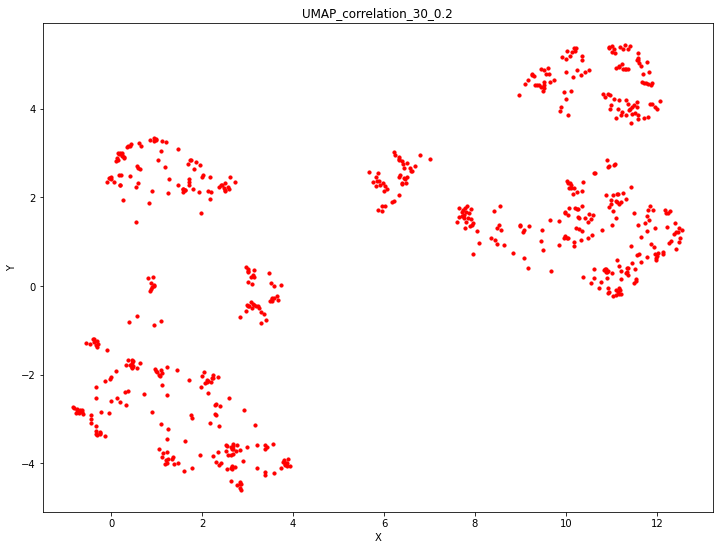

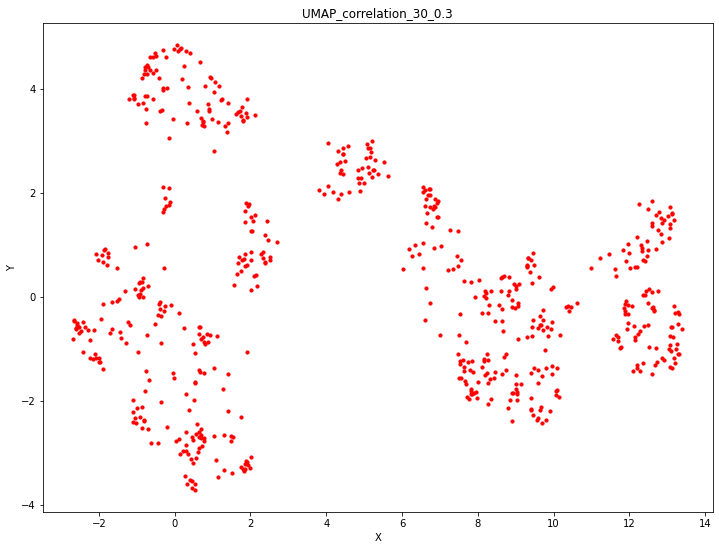

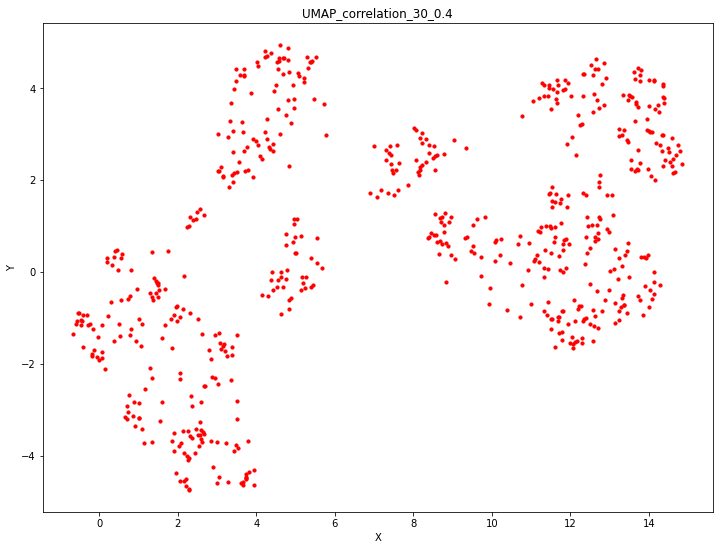

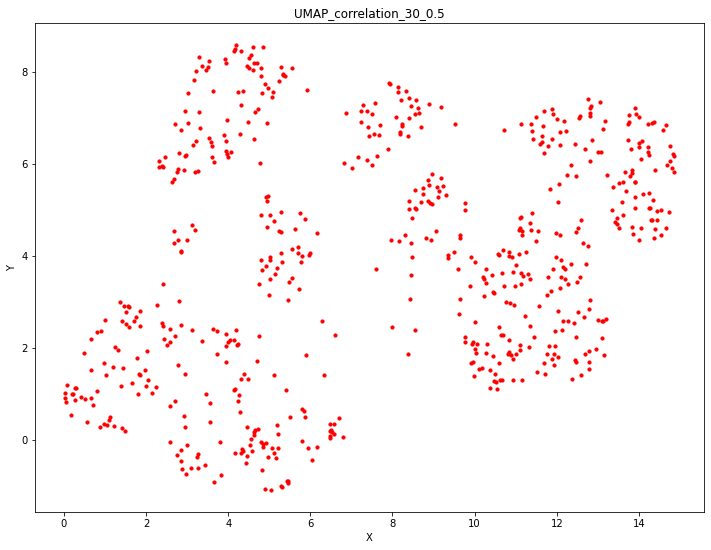

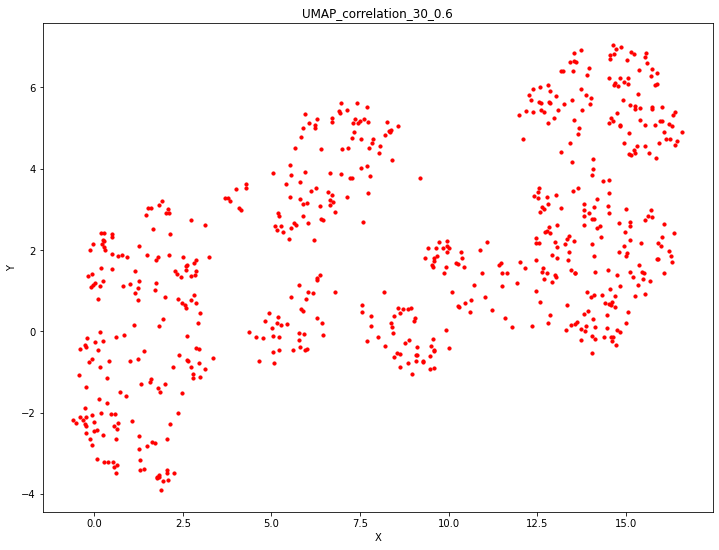

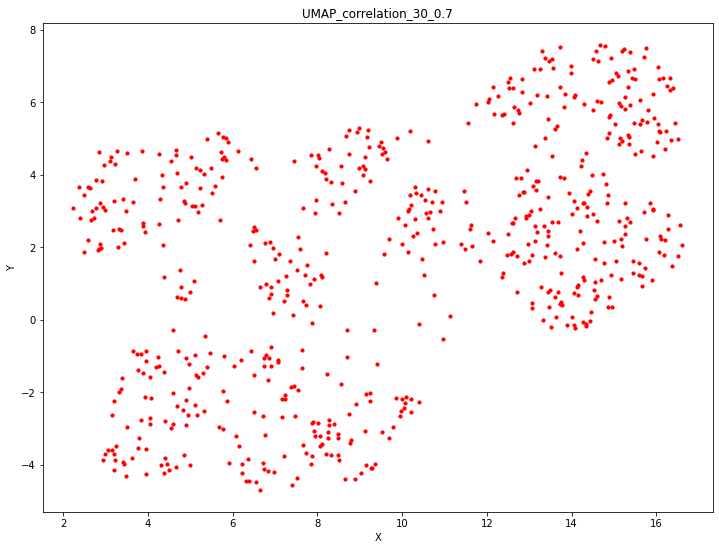

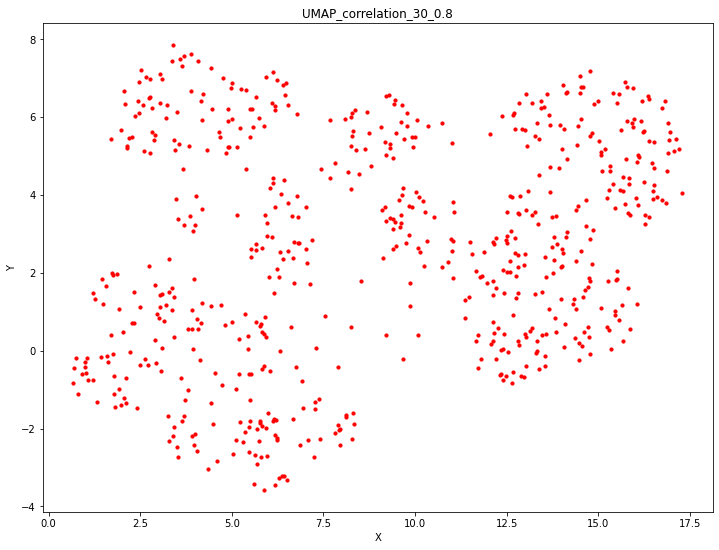

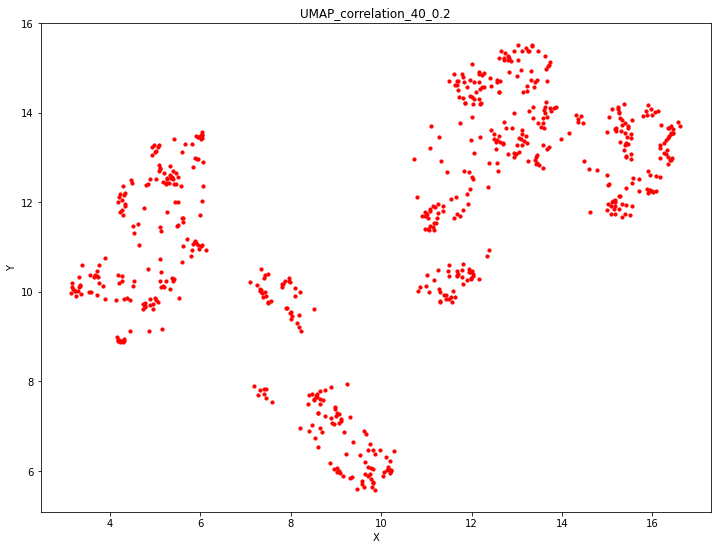

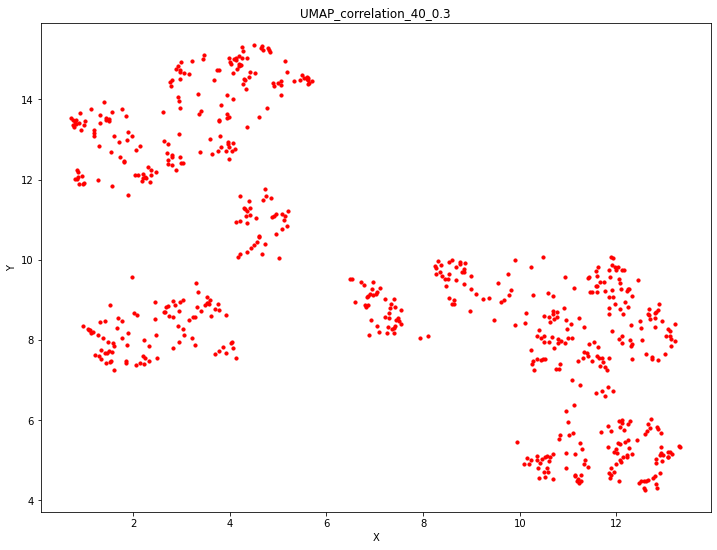

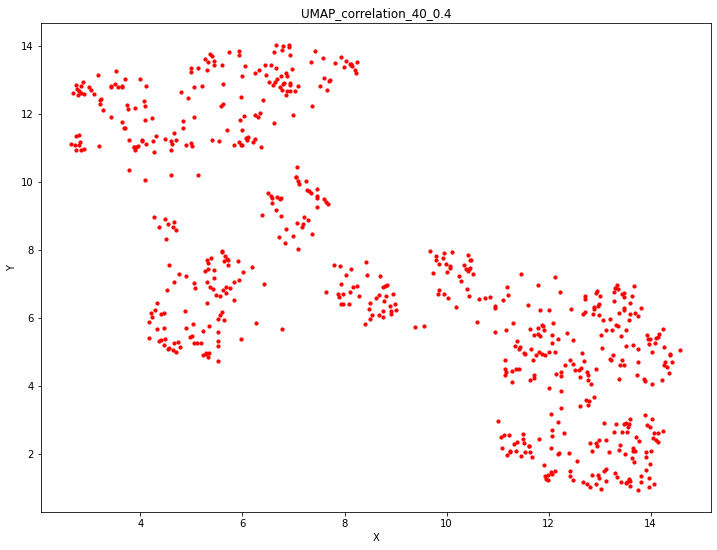

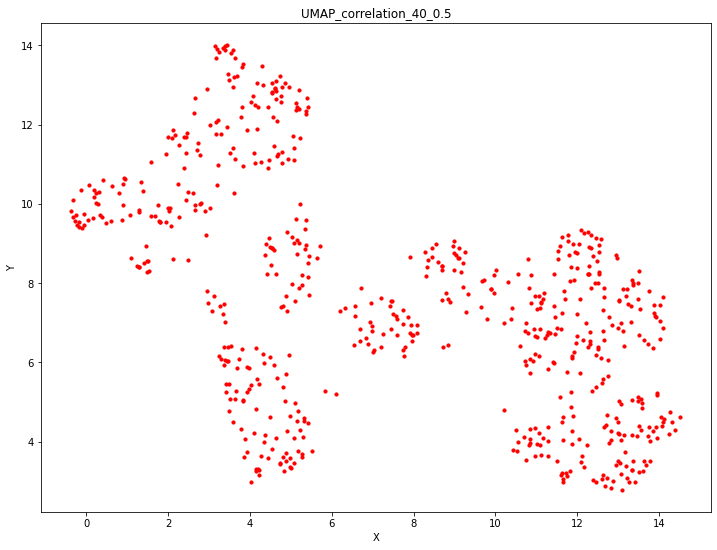

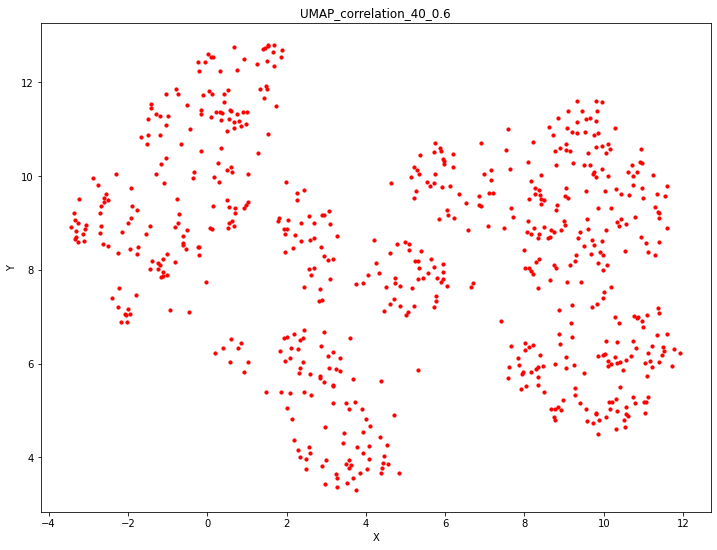

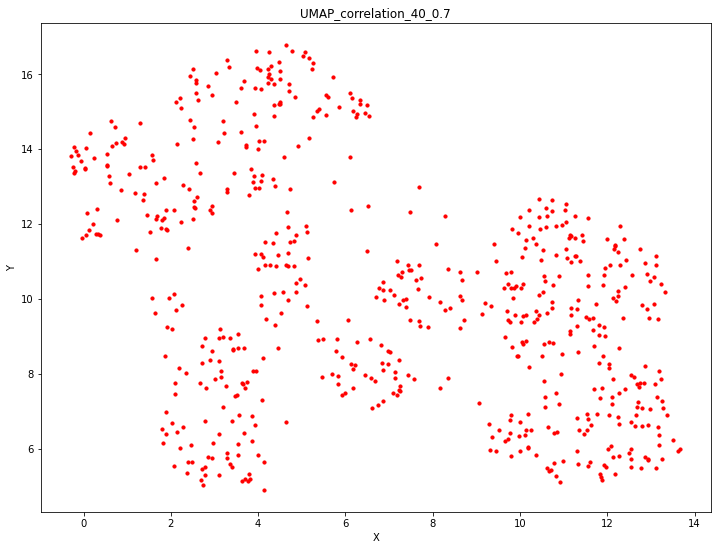

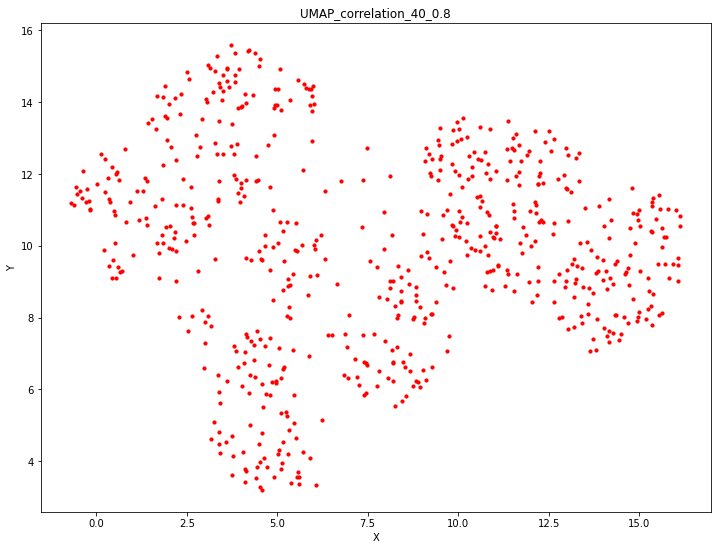

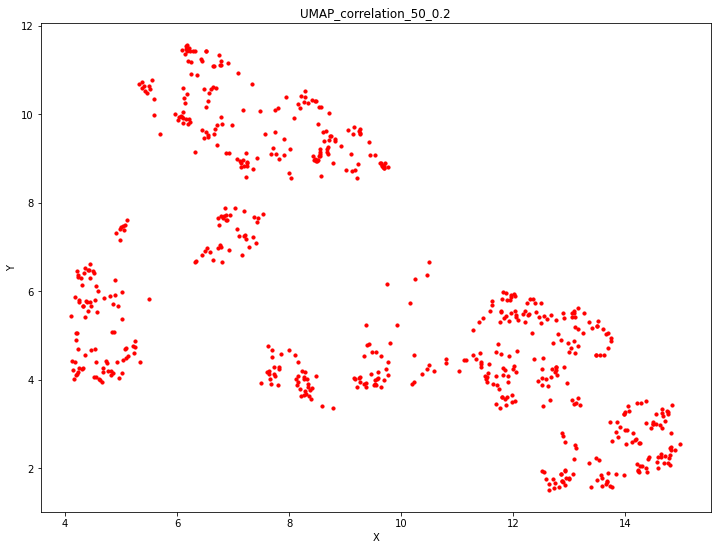

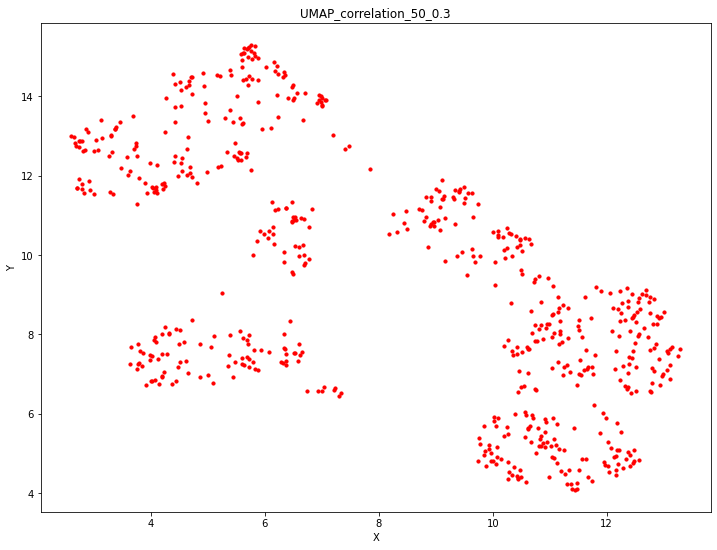

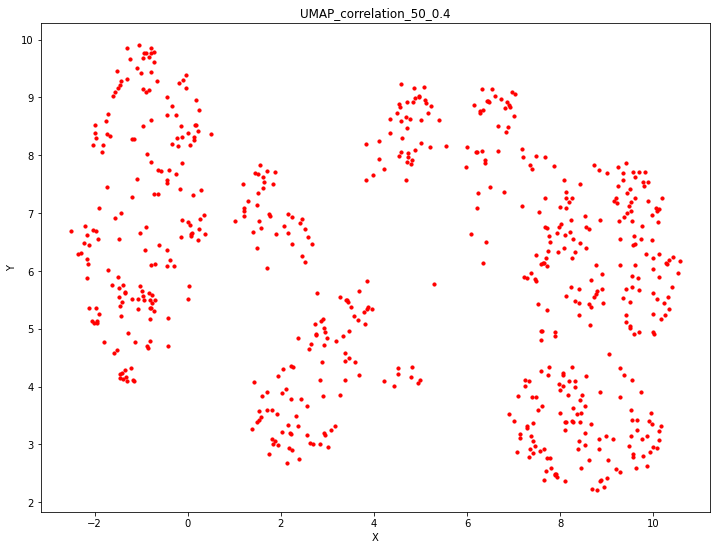

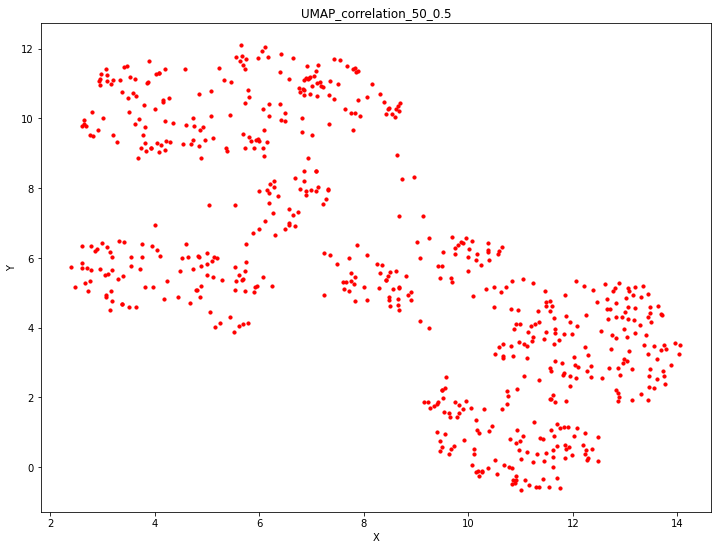

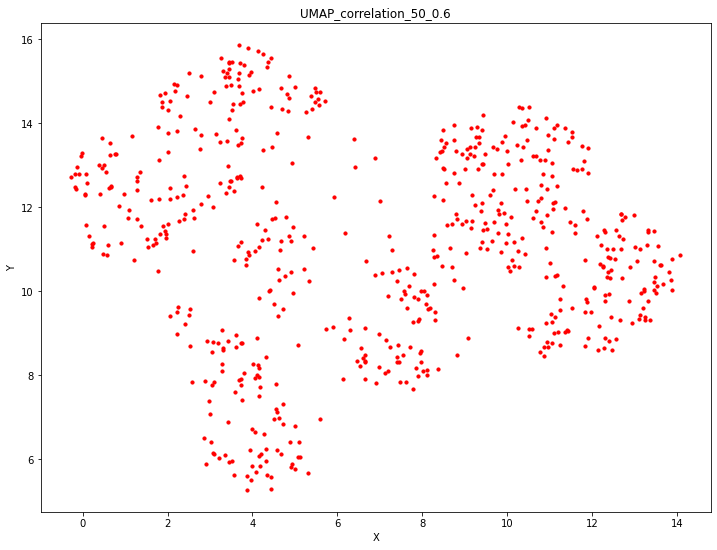

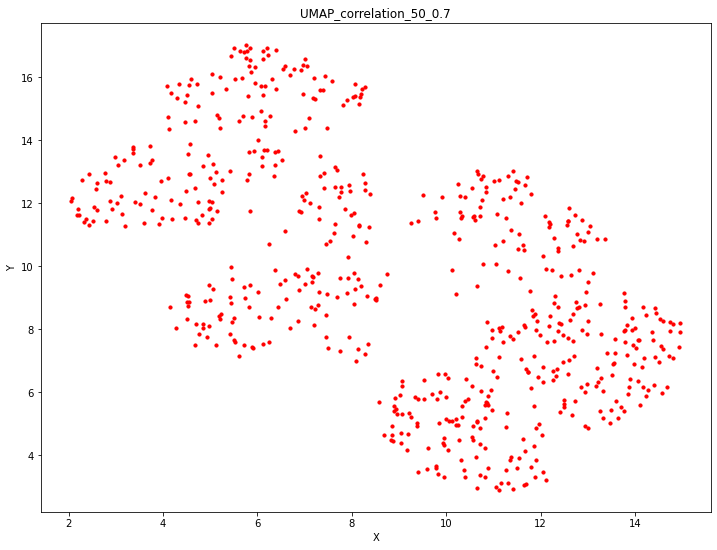

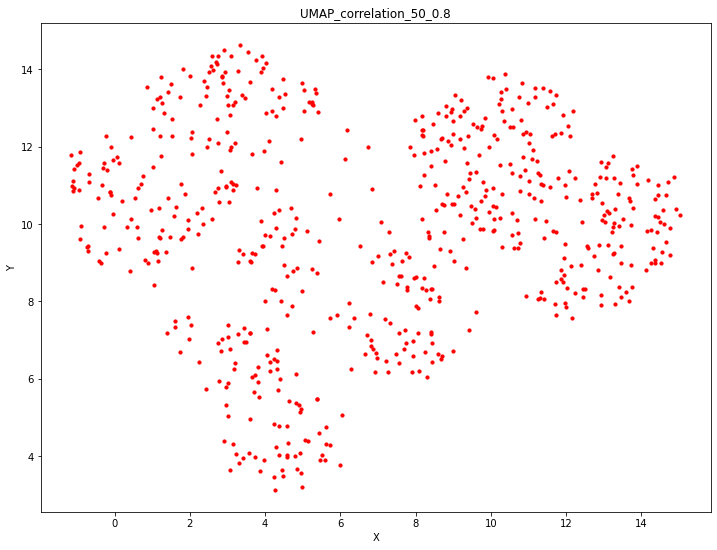

In [71]:
for metric in ['euclidean', 'cosine','correlation']:
    for n_neighbors in range(10, 60, 10):
        for min_dist in np.arange(0.2, 0.8, 0.1):
            embedding = umap.UMAP(n_components=2, n_neighbors=n_neighbors, 
                                  min_dist=min_dist, random_state=42, metric=metric)
            data_umap = embedding.fit_transform(data)
            fig = plt.figure(figsize=(12,9))
            plt.scatter(data_umap[:, 0], data_umap[:, 1], s=10, c='r')
            plt.title('UMAP_{}_{}_{}'.format(metric, str(n_neighbors), str(round(min_dist,2))))
            plt.xlabel('X')
            plt.ylabel('Y')

In [95]:
embedding = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42, metric='cosine')
data_umap = embedding.fit_transform(data)


<Figure size 1152x864 with 0 Axes>

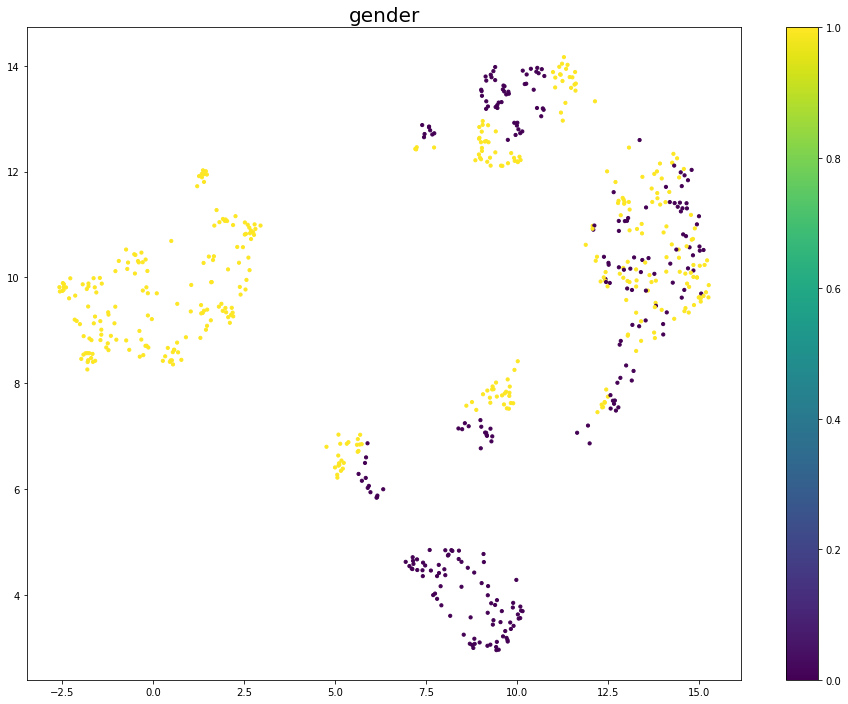

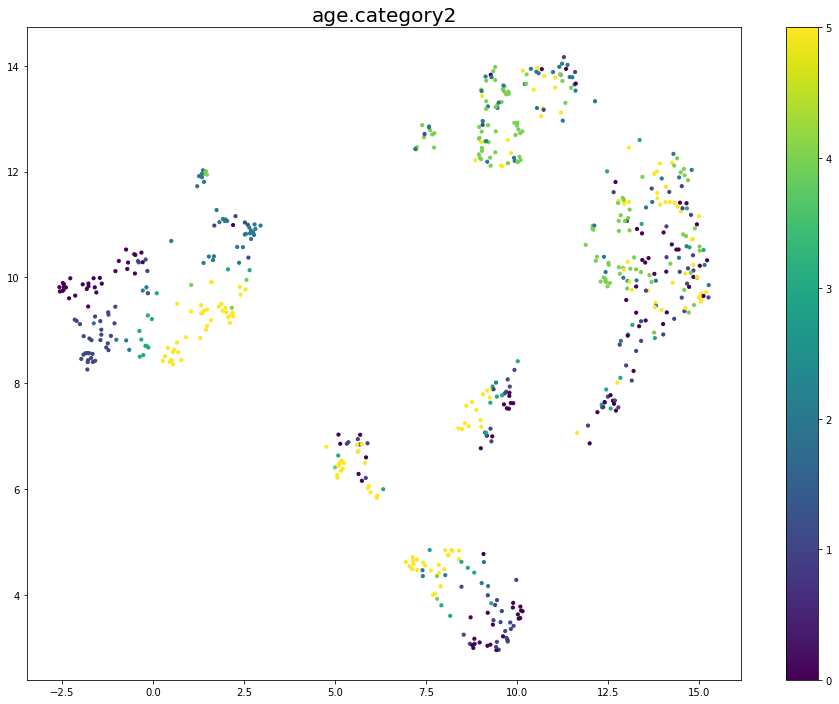

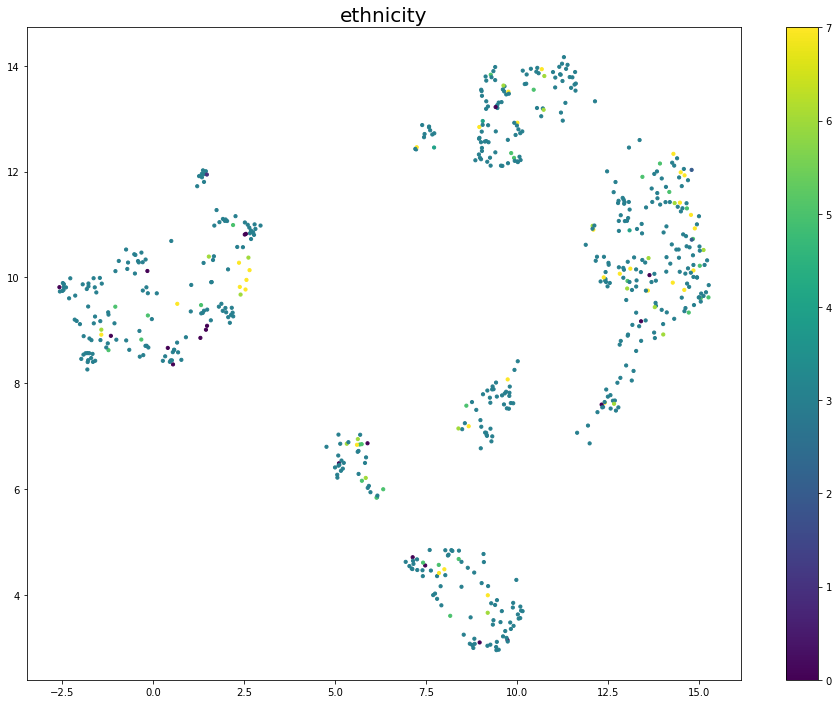

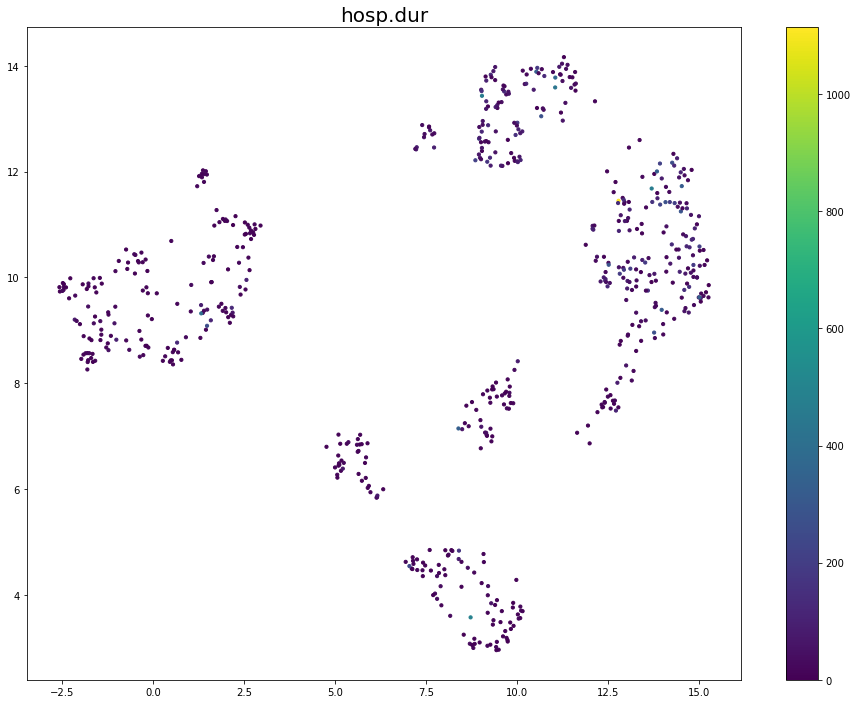

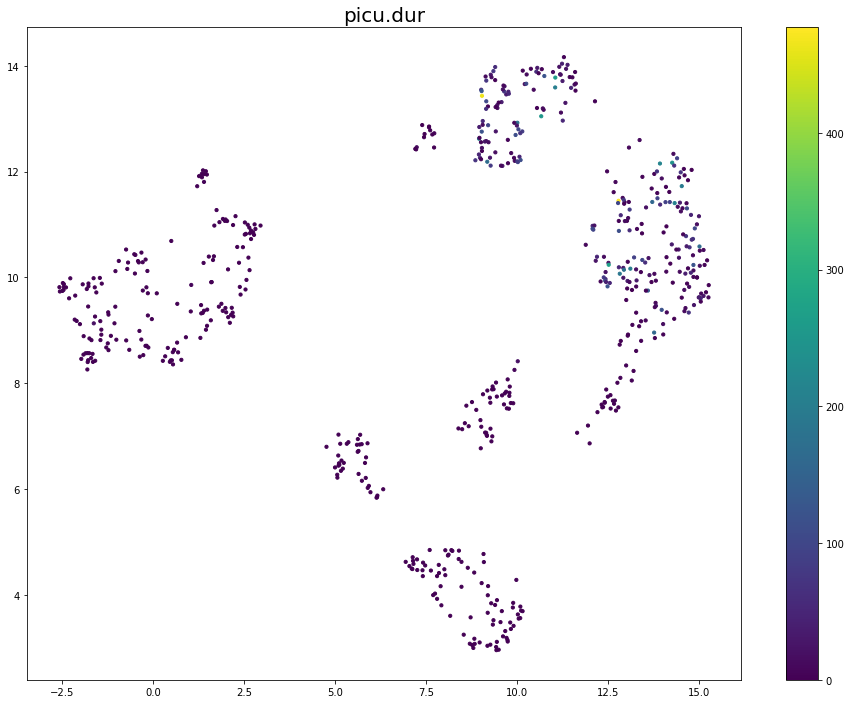

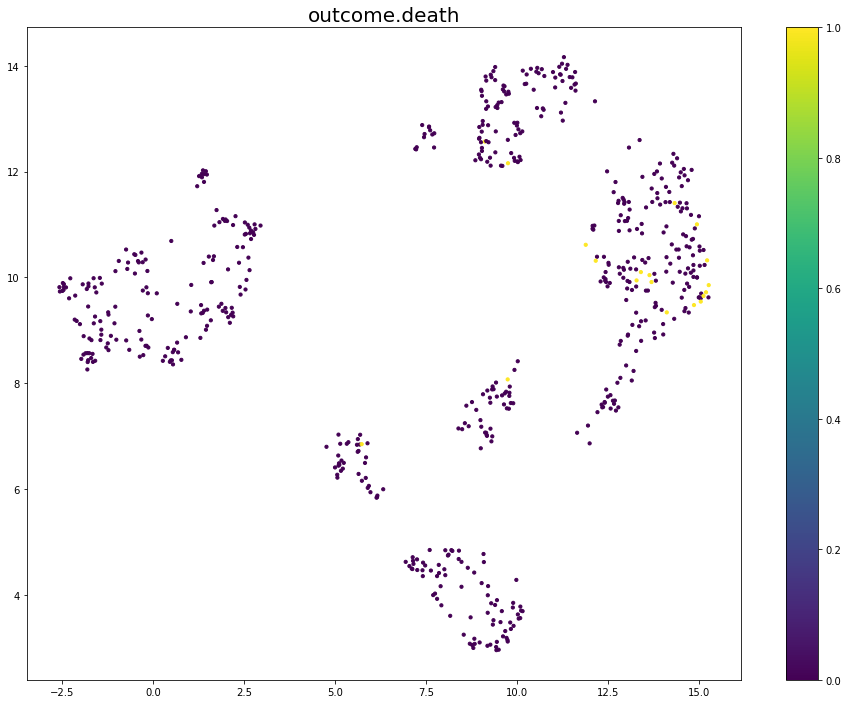

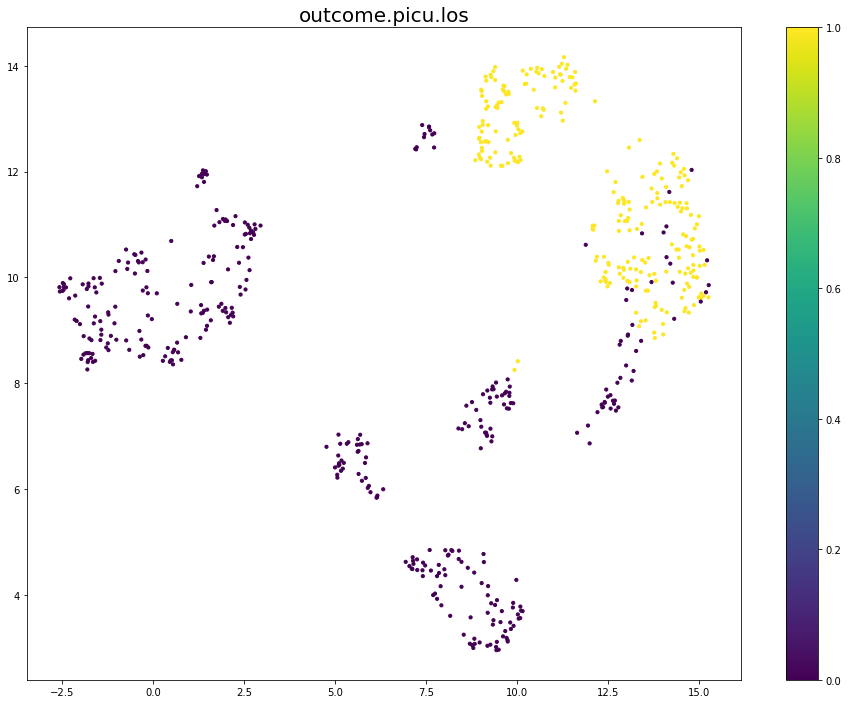

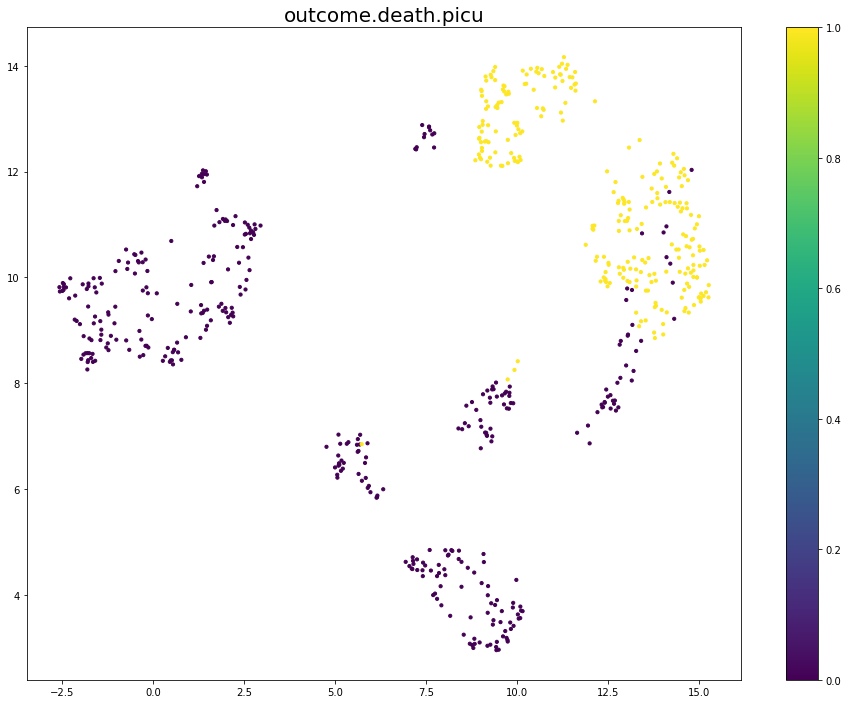

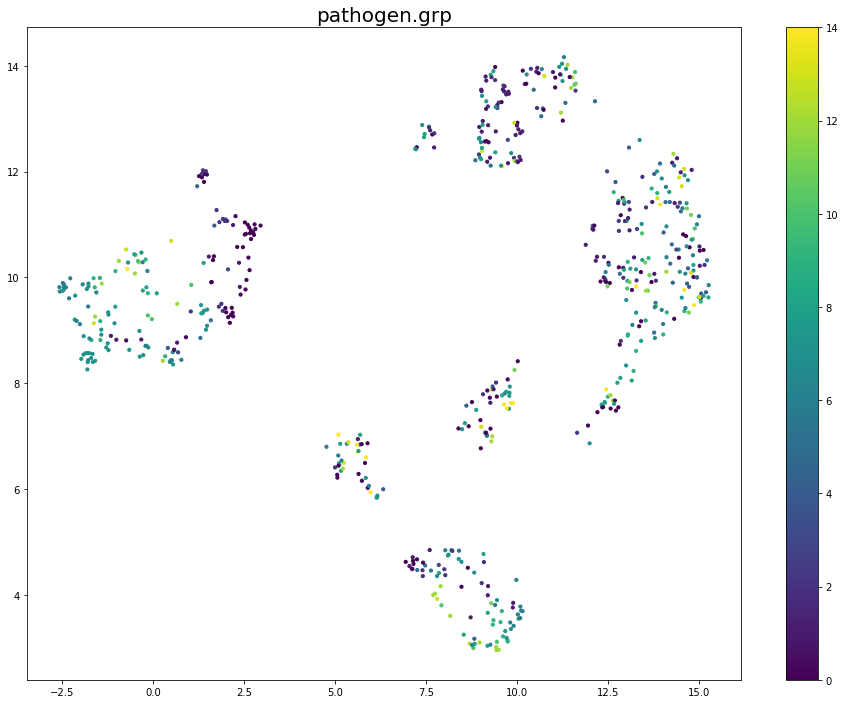

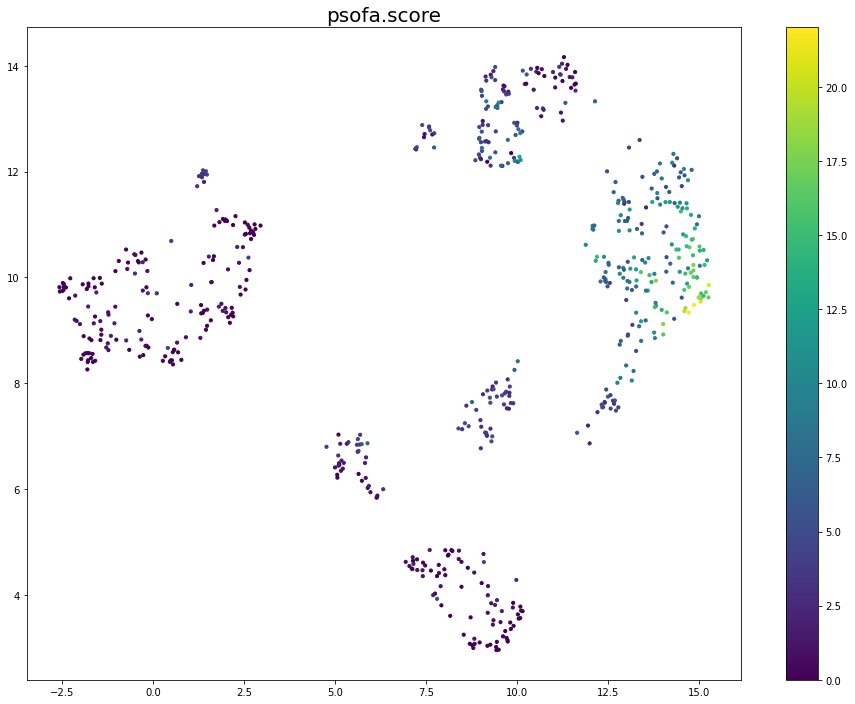

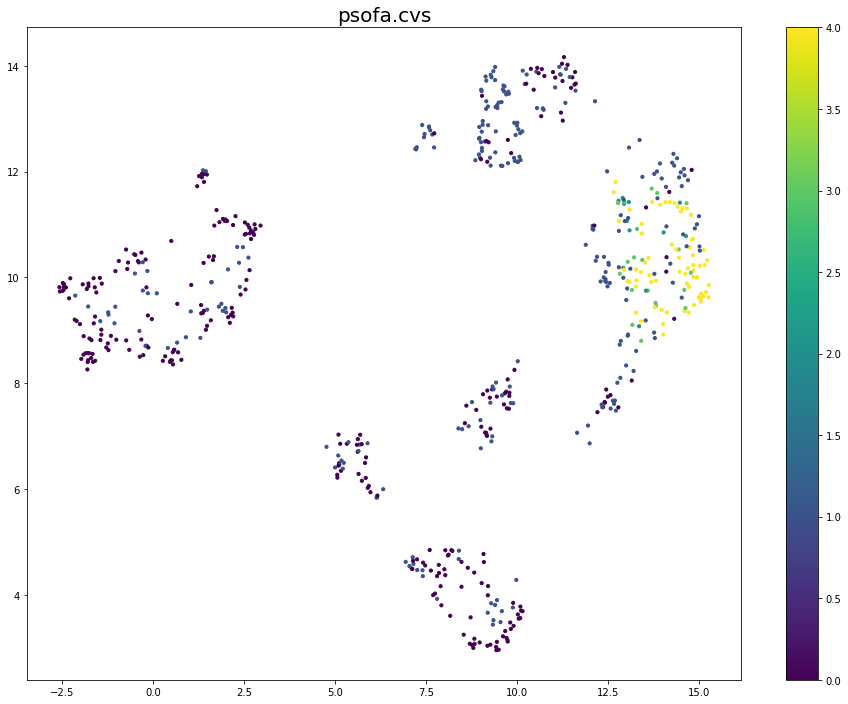

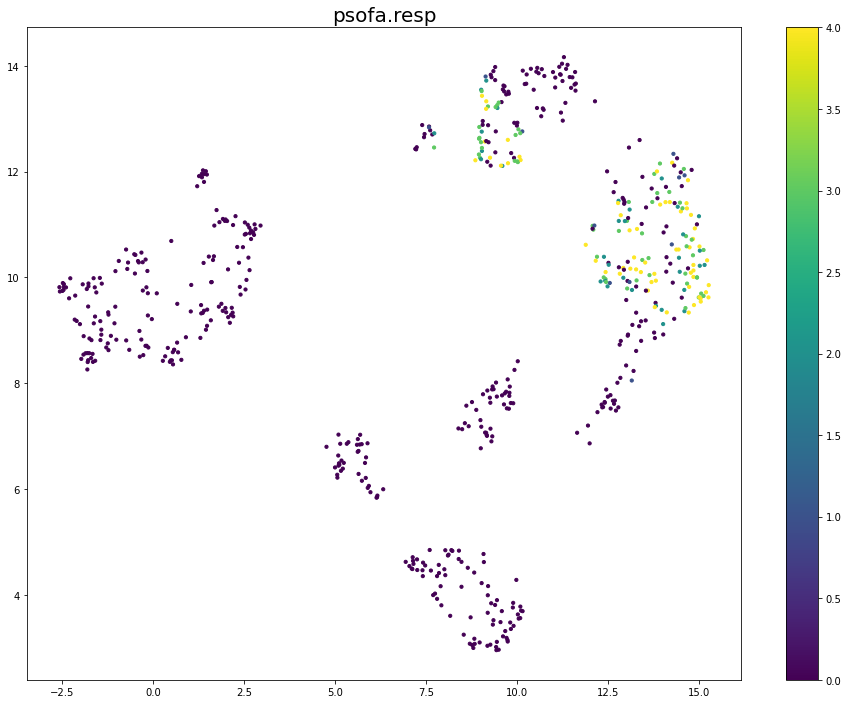

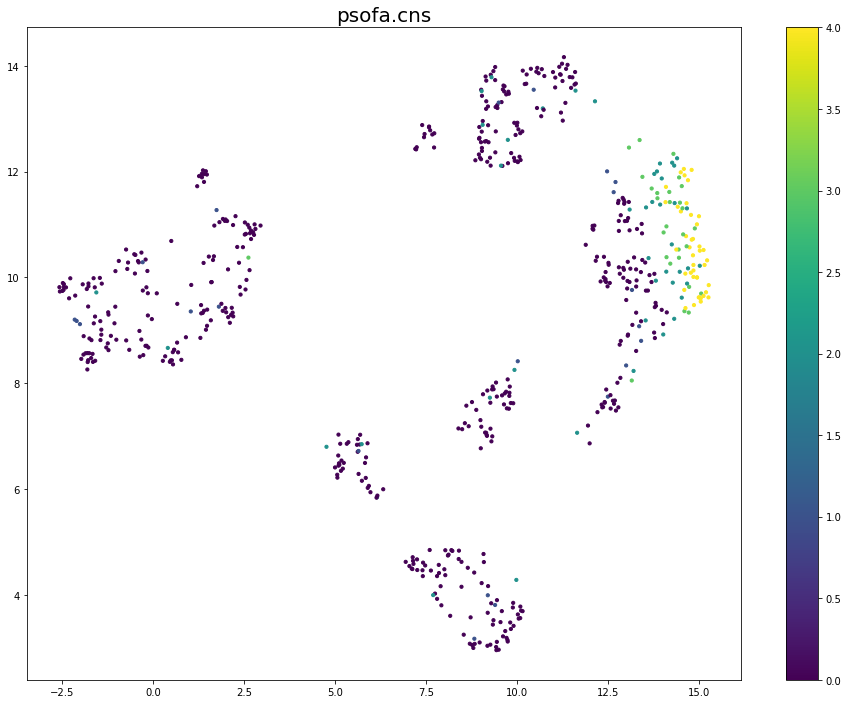

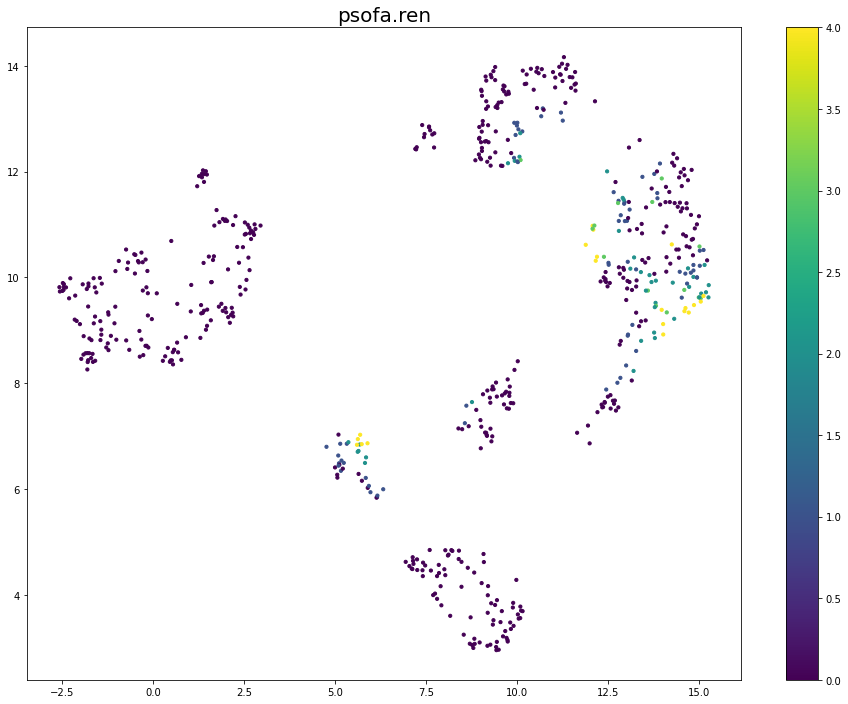

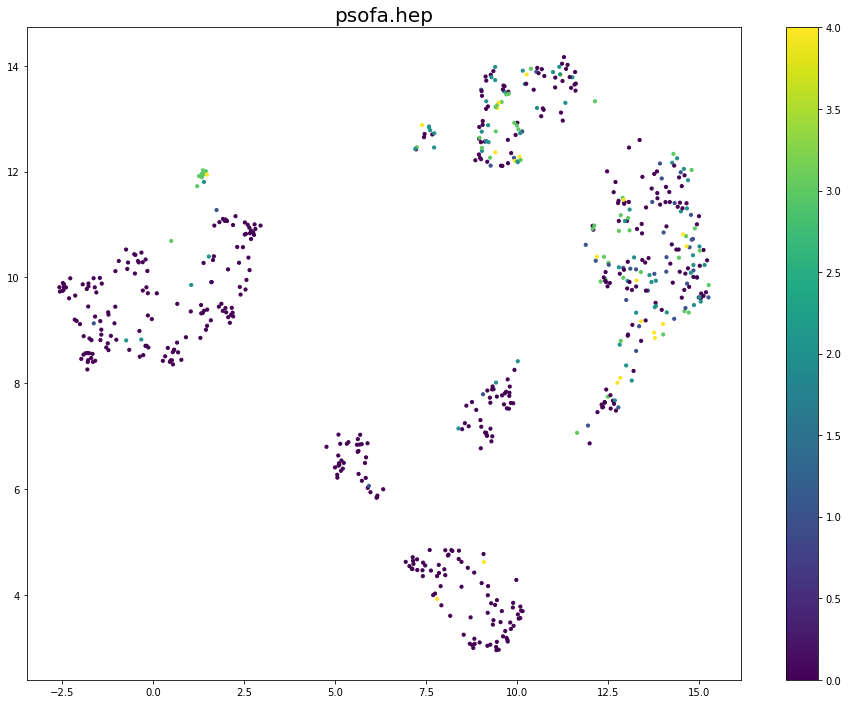

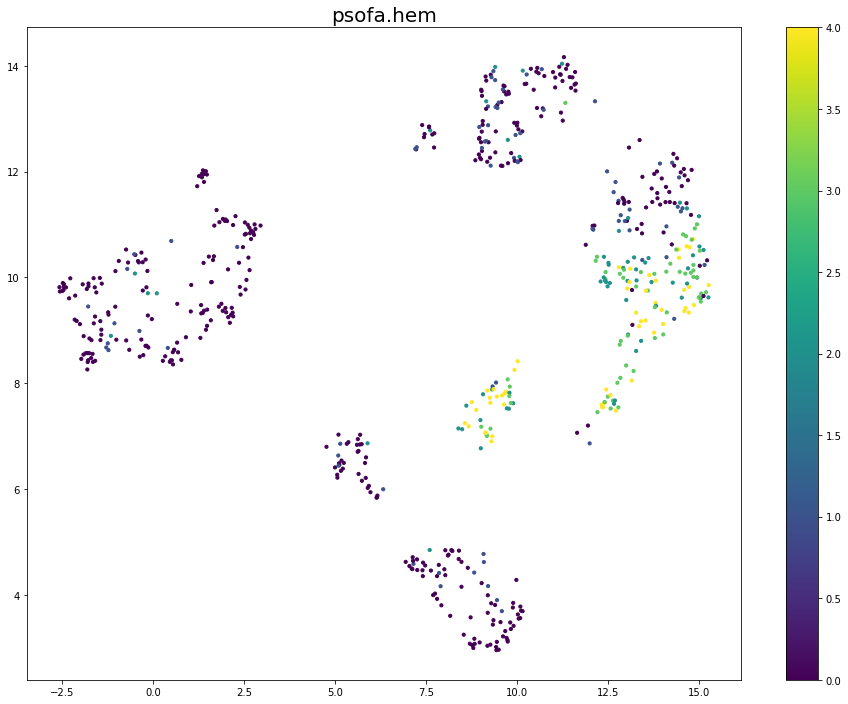

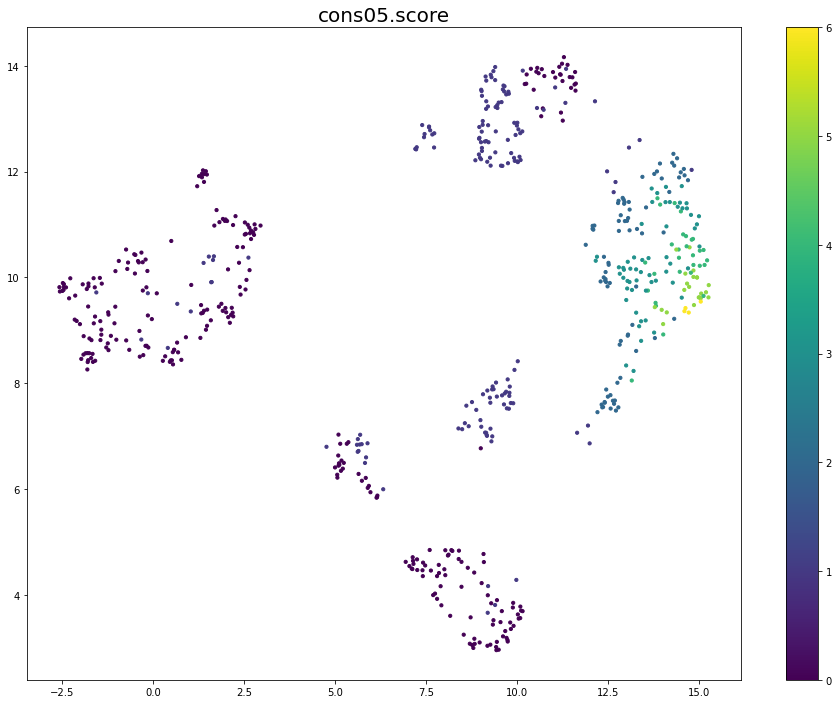

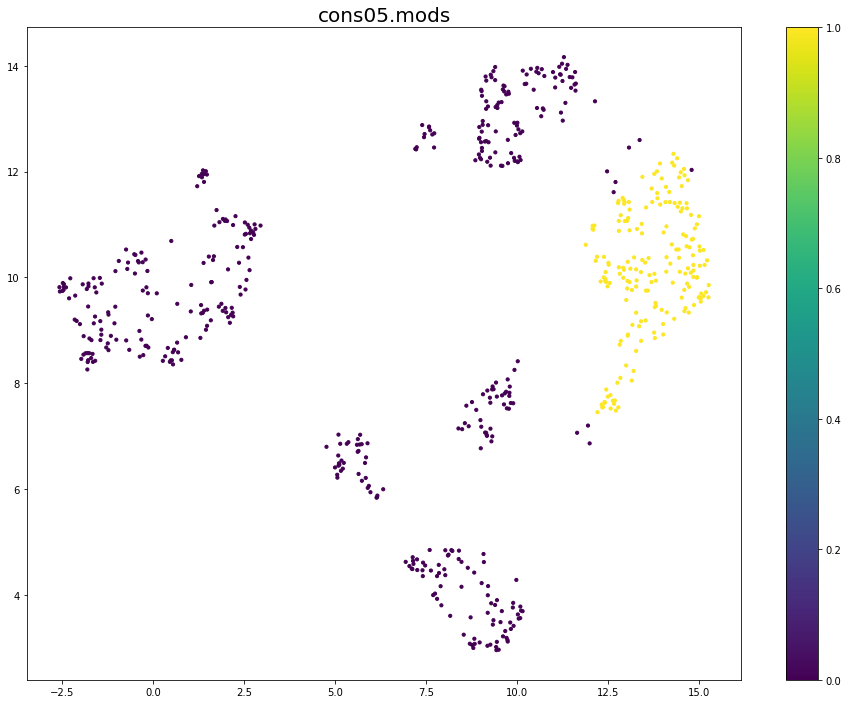

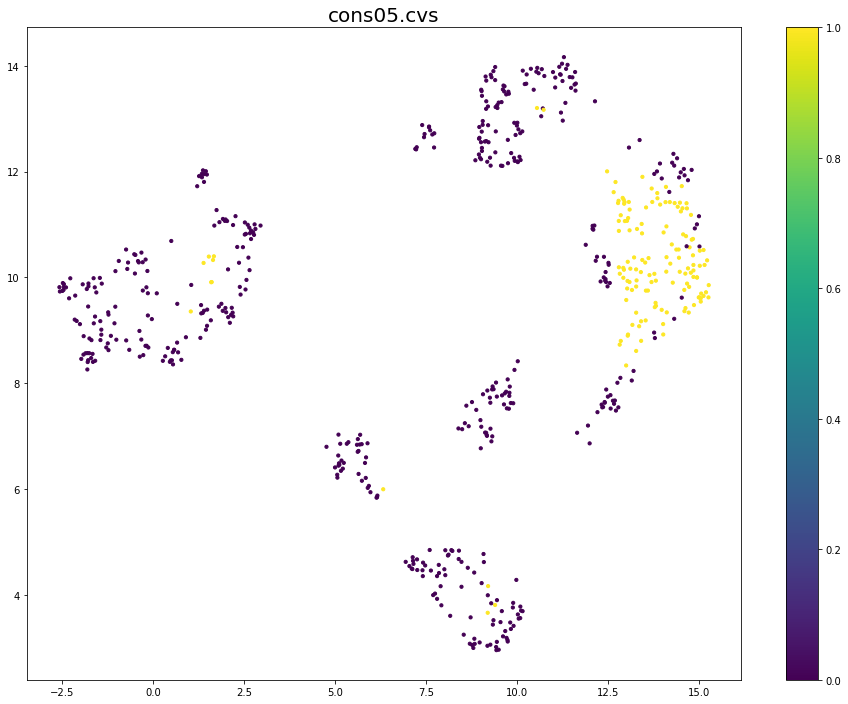

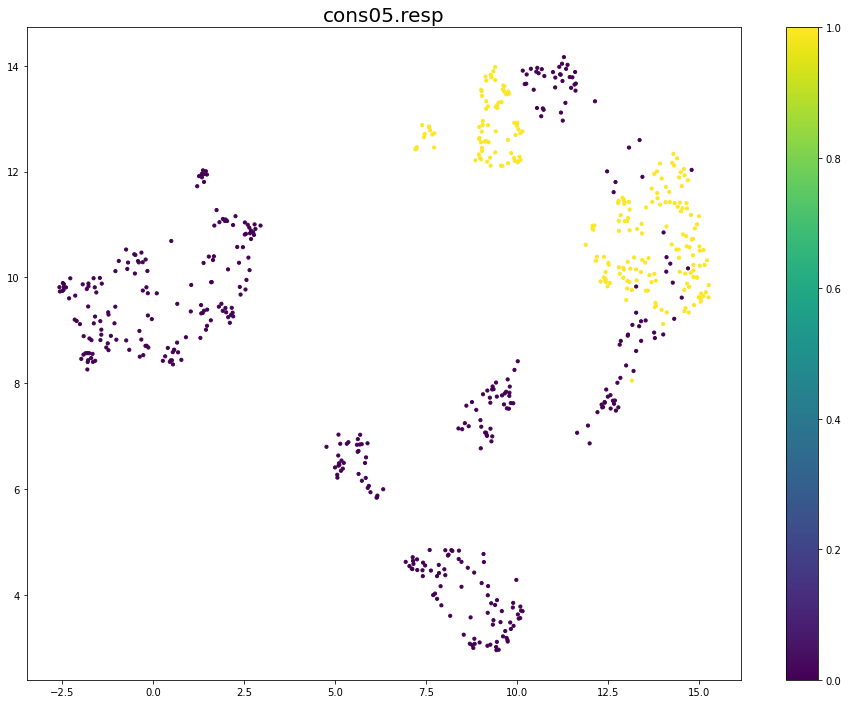

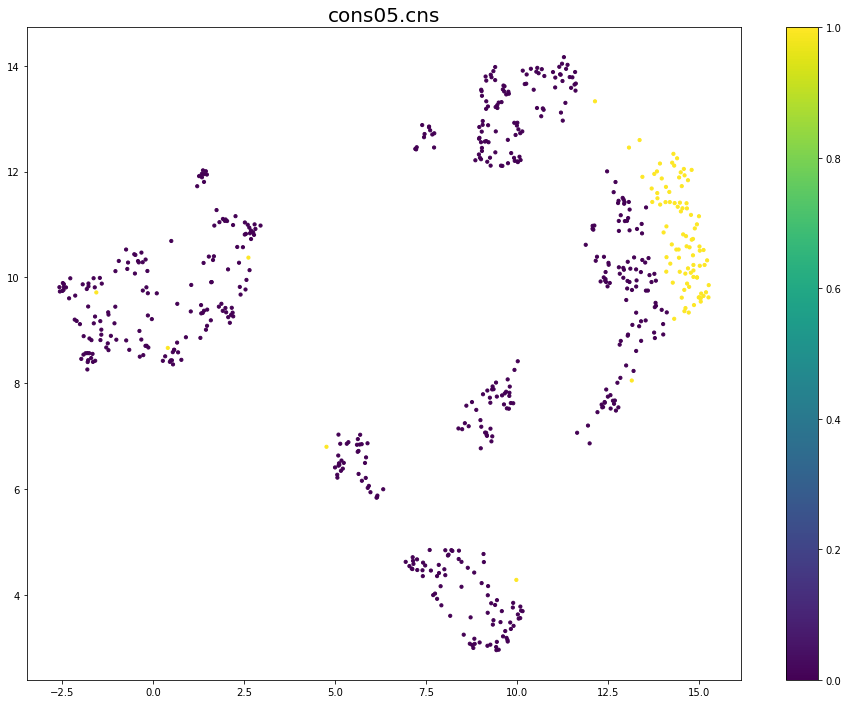

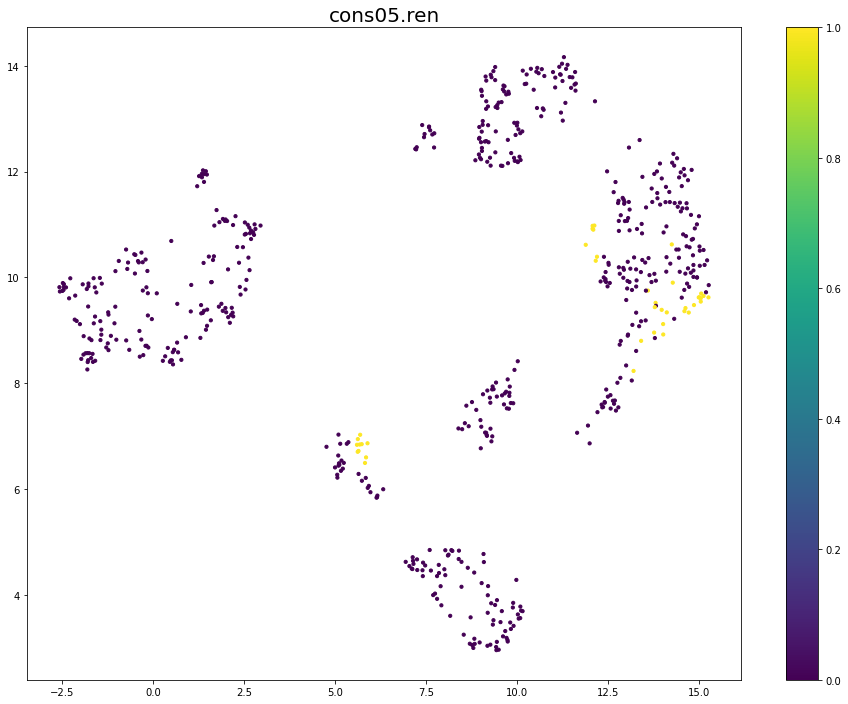

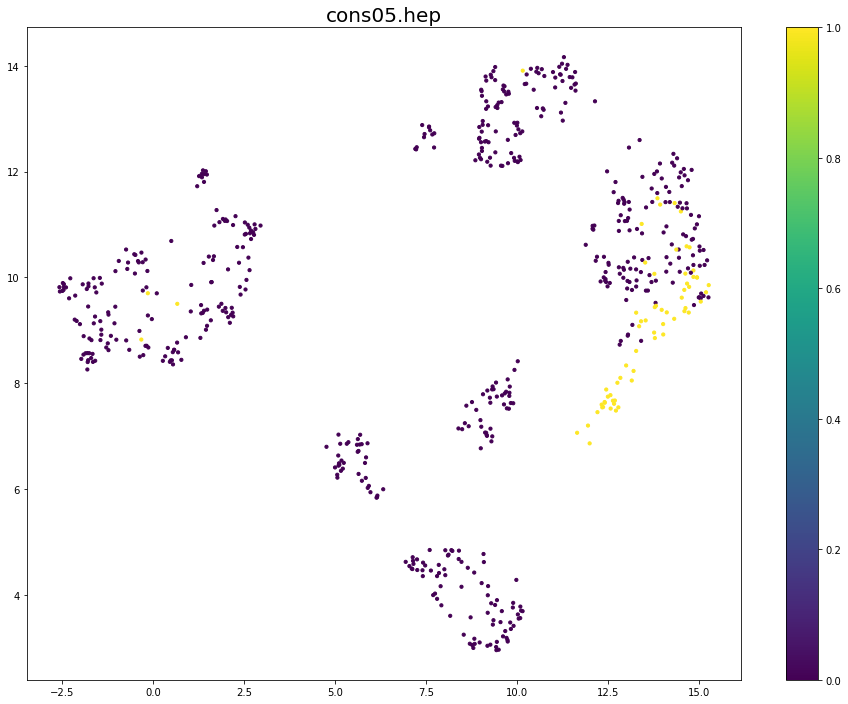

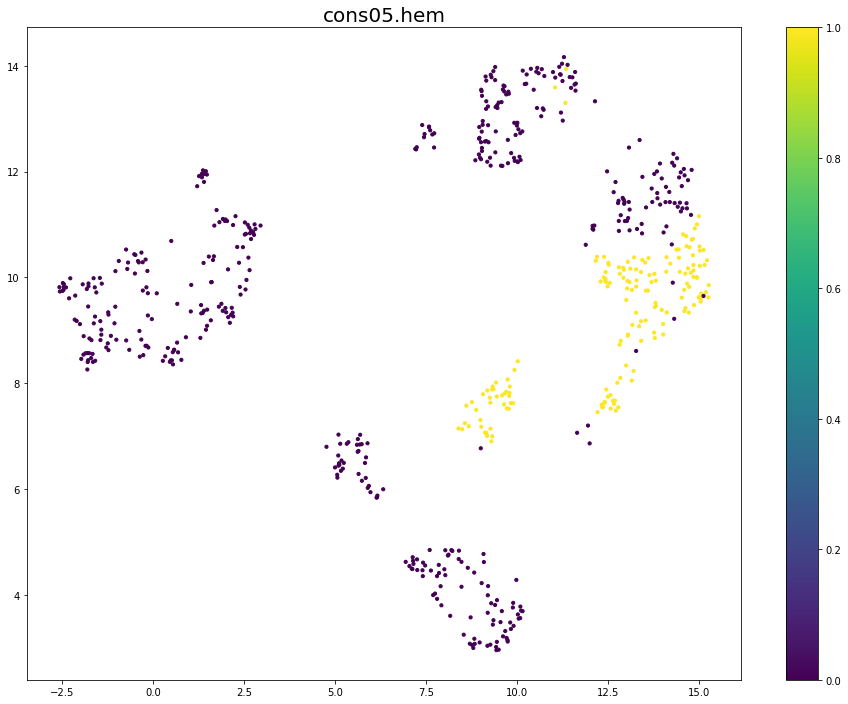

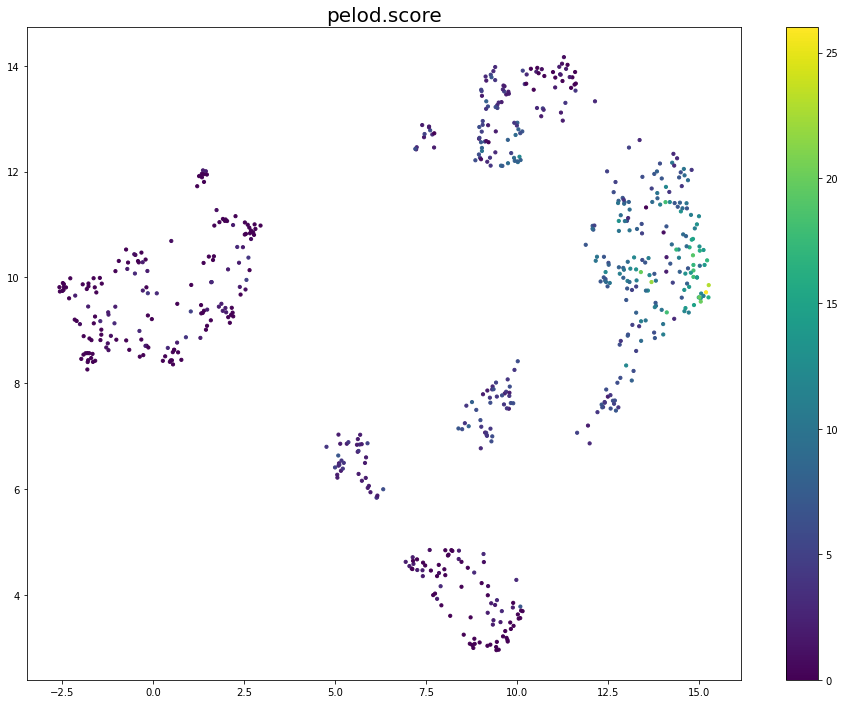

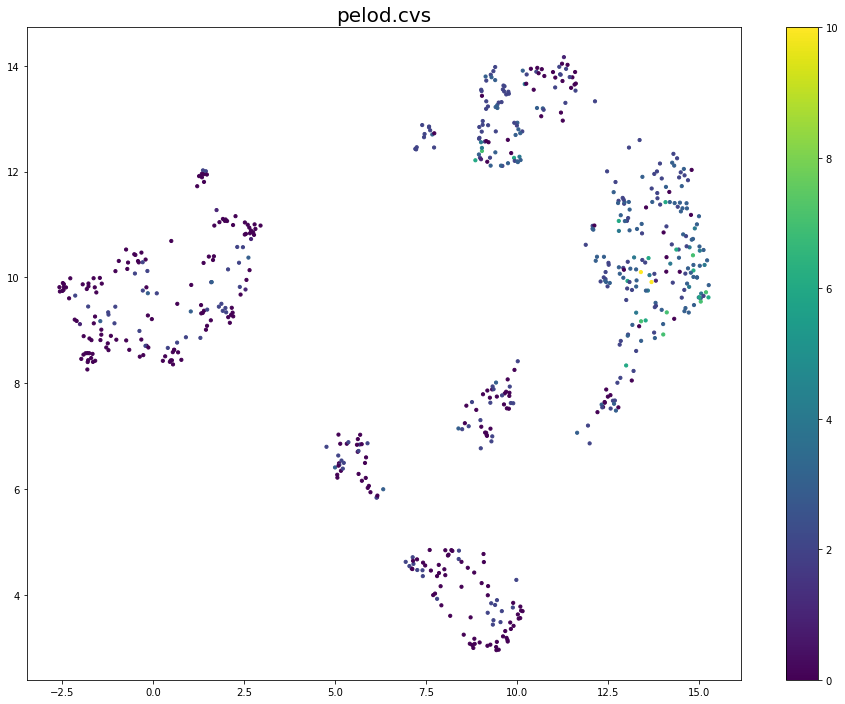

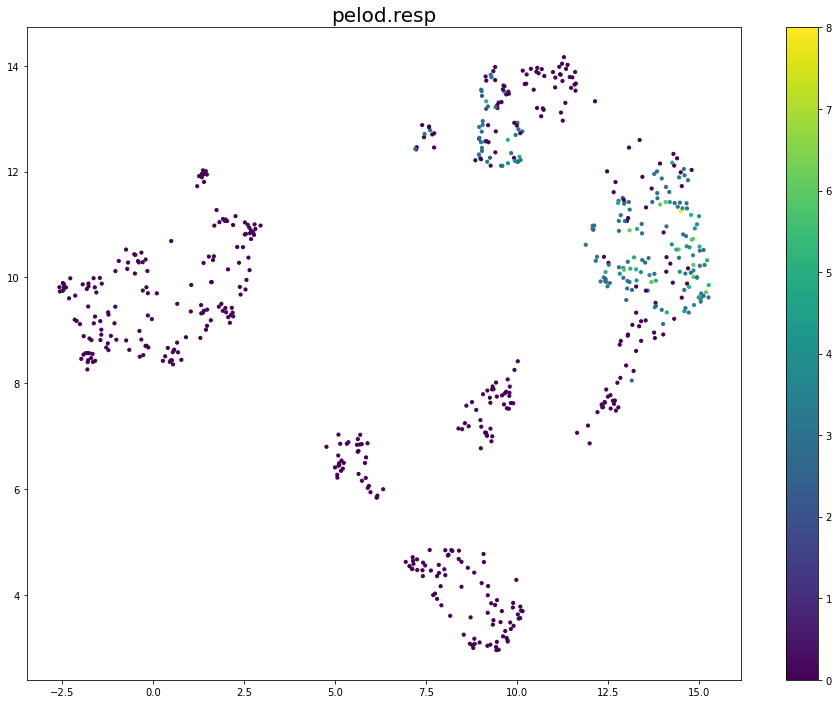

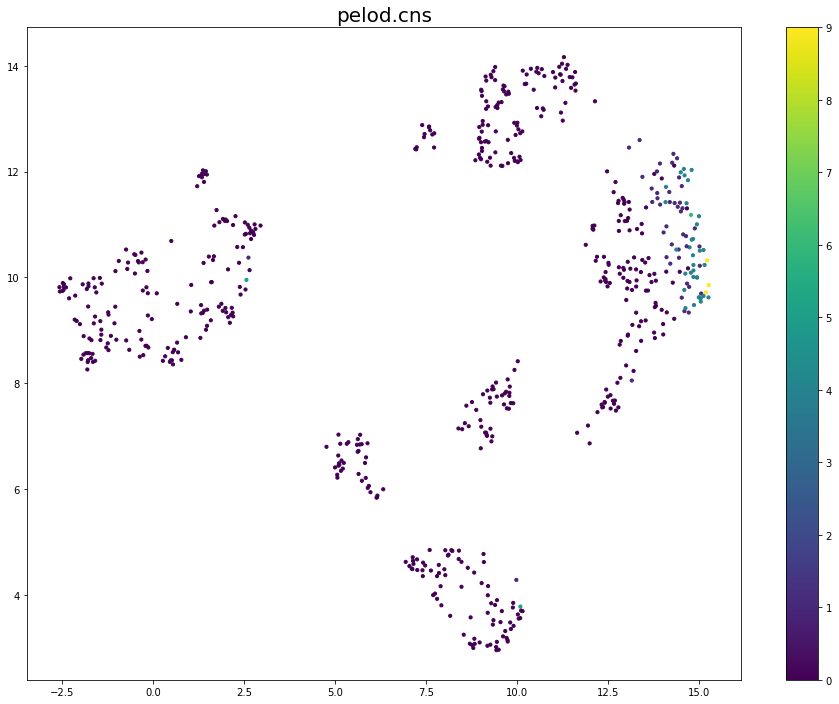

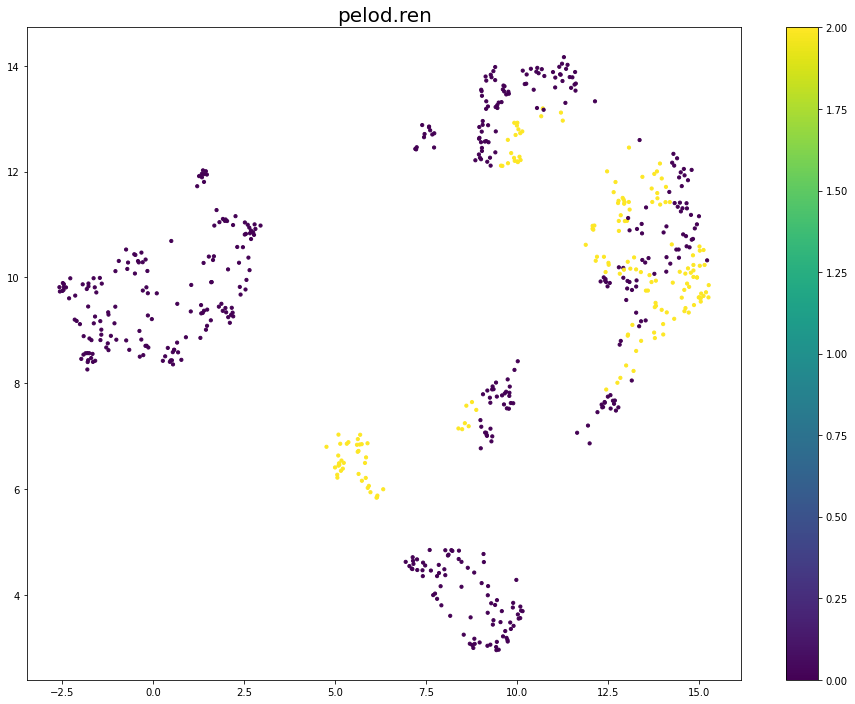

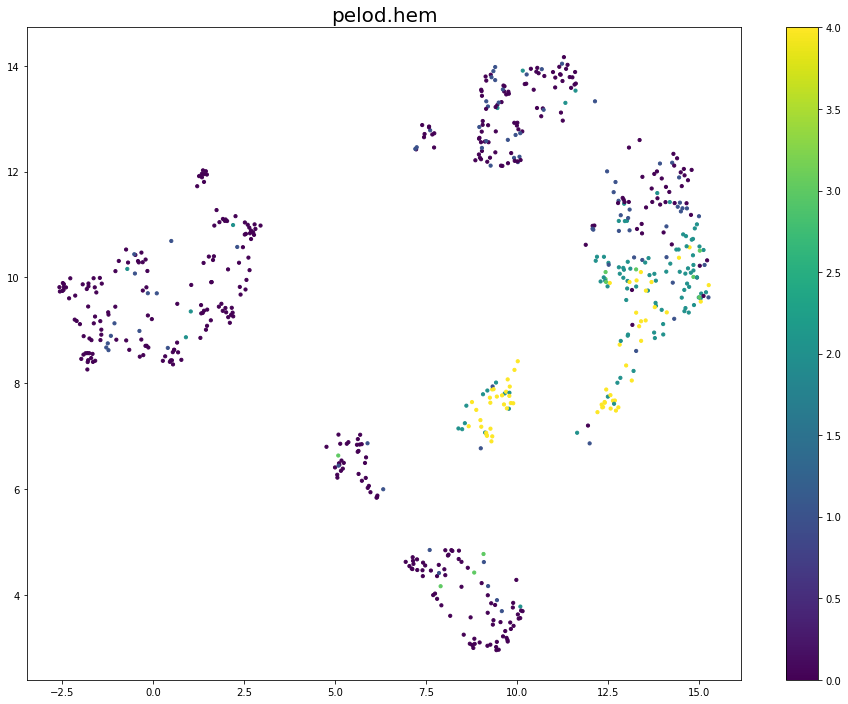

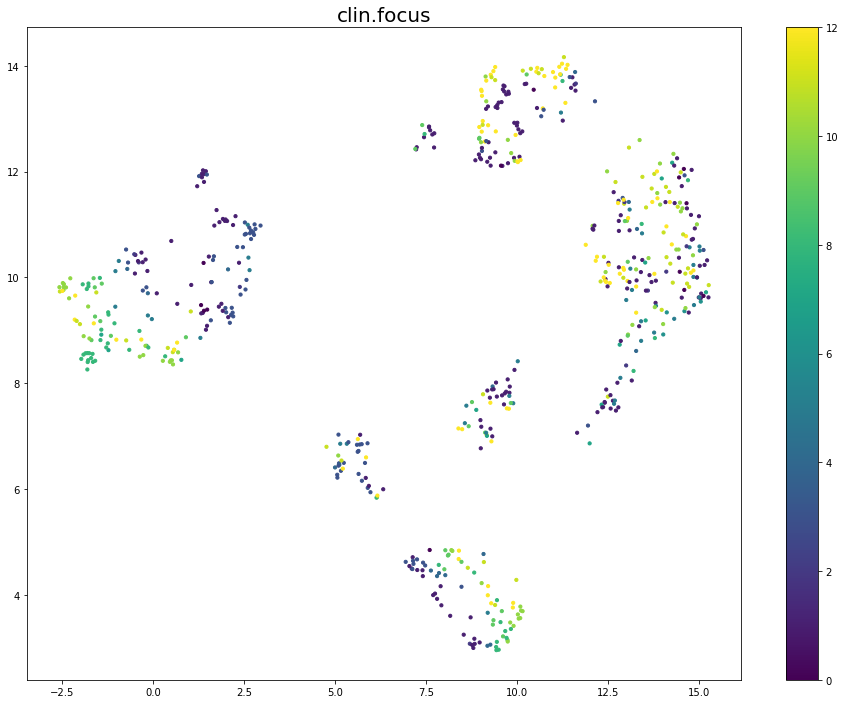

In [98]:
for column in columns:
    fig = plt.figure(figsize=(16,12))
    plt.scatter(data_umap[:, 0], data_umap[:, 1], s=10, c=phenotypes[column])
    cbar = plt.colorbar()
    plt.title(column, fontsize=20)